# TDL 7.2 Thinking with Deep Learning: Week 7 Part 2
# Deep Reinforcement Learning 

__Instructor:__ James Evans

__Teaching Assistants & Content Creators/Organisers:__ Bhargav Srinivasa Desikan (Notebook Author), James Evans (Notebook Editor), Likun Cao (Notebook Reviewer)

In this notebook we will continue from our basic reinforcement learning onto deep reinforcement learning.

# Actor Critic Method

We will be following the [Keras documentation tutorial](https://keras.io/examples/rl/actor_critic_cartpole/) by [Apoorv Nandan](https://twitter.com/NandanApoorv).

## Introduction

This script shows an implementation of Actor Critic method on CartPole-V0 environment.

### Actor Critic Method

As an agent takes actions and moves through an environment, it learns to map
the observed state of the environment to two possible outputs:

1. Recommended action: A probability value for each action in the action space.
   The part of the agent responsible for this output is called the **actor**.
2. Estimated rewards in the future: Sum of all rewards it expects to receive in the
   future. The part of the agent responsible for this output is the **critic**.

Agent and Critic learn to perform their tasks, such that the recommended actions
from the actor maximize the rewards.

### CartPole-V0

A pole is attached to a cart placed on a frictionless track. The agent has to apply
force to move the cart. It is rewarded for every time step the pole
remains upright. The agent, therefore, must learn to keep the pole from falling over.

### References

- [CartPole](http://www.derongliu.org/adp/adp-cdrom/Barto1983.pdf)
- [Actor Critic Method](https://hal.inria.fr/hal-00840470/document)


## Setup


In [ ]:
import gym
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Configuration parameters for the whole setup
seed = 42
gamma = 0.99  # Discount factor for past rewards
max_steps_per_episode = 10000
env = gym.make("CartPole-v0")  # Create the environment
env.seed(seed)
eps = np.finfo(np.float32).eps.item()  # Smallest number such that 1.0 + eps != 1.0


## Implement Actor Critic network

This network learns two functions:

1. Actor: This takes as input the state of our environment and returns a
probability value for each action in its action space.
2. Critic: This takes as input the state of our environment and returns
an estimate of total rewards in the future.

In our implementation, they share the initial layer.


In [ ]:
num_inputs = 4
num_actions = 2
num_hidden = 128

inputs = layers.Input(shape=(num_inputs,))
common = layers.Dense(num_hidden, activation="relu")(inputs)
action = layers.Dense(num_actions, activation="softmax")(common)
critic = layers.Dense(1)(common)

model = keras.Model(inputs=inputs, outputs=[action, critic])


## Train


In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=0.01)
huber_loss = keras.losses.Huber()
action_probs_history = []
critic_value_history = []
rewards_history = []
running_reward = 0
episode_count = 0

while True:  # Run until solved
    state = env.reset()
    episode_reward = 0
    with tf.GradientTape() as tape:
        for timestep in range(1, max_steps_per_episode):
            # env.render(); Adding this line would show the attempts
            # of the agent in a pop up window.

            state = tf.convert_to_tensor(state)
            state = tf.expand_dims(state, 0)

            # Predict action probabilities and estimated future rewards
            # from environment state
            action_probs, critic_value = model(state)
            critic_value_history.append(critic_value[0, 0])

            # Sample action from action probability distribution
            action = np.random.choice(num_actions, p=np.squeeze(action_probs))
            action_probs_history.append(tf.math.log(action_probs[0, action]))

            # Apply the sampled action in our environment
            state, reward, done, _ = env.step(action)
            rewards_history.append(reward)
            episode_reward += reward

            if done:
                break

        # Update running reward to check condition for solving
        running_reward = 0.05 * episode_reward + (1 - 0.05) * running_reward

        # Calculate expected value from rewards
        # - At each timestep what was the total reward received after that timestep
        # - Rewards in the past are discounted by multiplying them with gamma
        # - These are the labels for our critic
        returns = []
        discounted_sum = 0
        for r in rewards_history[::-1]:
            discounted_sum = r + gamma * discounted_sum
            returns.insert(0, discounted_sum)

        # Normalize
        returns = np.array(returns)
        returns = (returns - np.mean(returns)) / (np.std(returns) + eps)
        returns = returns.tolist()

        # Calculating loss values to update our network
        history = zip(action_probs_history, critic_value_history, returns)
        actor_losses = []
        critic_losses = []
        for log_prob, value, ret in history:
            # At this point in history, the critic estimated that we would get a
            # total reward = `value` in the future. We took an action with log probability
            # of `log_prob` and ended up recieving a total reward = `ret`.
            # The actor must be updated so that it predicts an action that leads to
            # high rewards (compared to critic's estimate) with high probability.
            diff = ret - value
            actor_losses.append(-log_prob * diff)  # actor loss

            # The critic must be updated so that it predicts a better estimate of
            # the future rewards.
            critic_losses.append(
                huber_loss(tf.expand_dims(value, 0), tf.expand_dims(ret, 0))
            )

        # Backpropagation
        loss_value = sum(actor_losses) + sum(critic_losses)
        grads = tape.gradient(loss_value, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        # Clear the loss and reward history
        action_probs_history.clear()
        critic_value_history.clear()
        rewards_history.clear()

    # Log details
    episode_count += 1
    if episode_count % 10 == 0:
        template = "running reward: {:.2f} at episode {}"
        print(template.format(running_reward, episode_count))

    if running_reward > 195:  # Condition to consider the task solved
        print("Solved at episode {}!".format(episode_count))
        break


## Visualizations
In early stages of training:
![Imgur](https://i.imgur.com/5gCs5kH.gif)

In later stages of training:
![Imgur](https://i.imgur.com/5ziiZUD.gif)


# Deep Q-Learning

The paper that started it all: [Human-level control through deep reinforcement learning](https://www.nature.com/articles/nature14236)

We will be starting the [Keras tutorial](https://keras.io/examples/rl/deep_q_network_breakout/) by [Jacob Chapman](https://twitter.com/jacoblchapman) and [Mathias Lechner](https://twitter.com/MLech20).

## Deep Q-Learning for Atari Breakout



## Introduction

This script shows an implementation of Deep Q-Learning on the
`BreakoutNoFrameskip-v4` environment.

### Deep Q-Learning

As an agent takes actions and moves through an environment, it learns to map
the observed state of the environment to an action. An agent will choose an action
in a given state based on a "Q-value", which is a weighted reward based on the
expected highest long-term reward. A Q-Learning Agent learns to perform its
task such that the recommended action maximizes the potential future rewards.
This method is considered an "Off-Policy" method,
meaning its Q values are updated assuming that the best action was chosen, even
if the best action was not chosen.

### Atari Breakout

In this environment, a board moves along the bottom of the screen returning a ball that
will destroy blocks at the top of the screen.
The aim of the game is to remove all blocks and breakout of the
level. The agent must learn to control the board by moving left and right, returning the
ball and removing all the blocks without the ball passing the board.

### Note

The Deepmind paper trained for "a total of 50 million frames (that is, around 38 days of
game experience in total)". However this script will give good results at around 10
million frames which are processed in less than 24 hours on a modern machine.

### References

- [Q-Learning](https://link.springer.com/content/pdf/10.1007/BF00992698.pdf)
- [Deep Q-Learning](https://deepmind.com/research/publications/human-level-control-through-deep-reinforcement-learning)

## Setup

In [ ]:
from baselines.common.atari_wrappers import make_atari, wrap_deepmind
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Configuration paramaters for the whole setup
seed = 42
gamma = 0.99  # Discount factor for past rewards
epsilon = 1.0  # Epsilon greedy parameter
epsilon_min = 0.1  # Minimum epsilon greedy parameter
epsilon_max = 1.0  # Maximum epsilon greedy parameter
epsilon_interval = (
    epsilon_max - epsilon_min
)  # Rate at which to reduce chance of random action being taken
batch_size = 32  # Size of batch taken from replay buffer
max_steps_per_episode = 10000

# Use the Baseline Atari environment because of Deepmind helper functions
env = make_atari("BreakoutNoFrameskip-v4")
# Warp the frames, grey scale, stake four frame and scale to smaller ratio
env = wrap_deepmind(env, frame_stack=True, scale=True)
env.seed(seed)

## Implement the Deep Q-Network

This network learns an approximation of the Q-table, which is a mapping between
the states and actions that an agent will take. For every state we'll have four
actions, that can be taken. The environment provides the state, and the action
is chosen by selecting the larger of the four Q-values predicted in the output layer.

In [ ]:
num_actions = 4


def create_q_model():
    # Network defined by the Deepmind paper
    inputs = layers.Input(shape=(84, 84, 4,))

    # Convolutions on the frames on the screen
    layer1 = layers.Conv2D(32, 8, strides=4, activation="relu")(inputs)
    layer2 = layers.Conv2D(64, 4, strides=2, activation="relu")(layer1)
    layer3 = layers.Conv2D(64, 3, strides=1, activation="relu")(layer2)

    layer4 = layers.Flatten()(layer3)

    layer5 = layers.Dense(512, activation="relu")(layer4)
    action = layers.Dense(num_actions, activation="linear")(layer5)

    return keras.Model(inputs=inputs, outputs=action)


# The first model makes the predictions for Q-values which are used to
# make a action.
model = create_q_model()
# Build a target model for the prediction of future rewards.
# The weights of a target model get updated every 10000 steps thus when the
# loss between the Q-values is calculated the target Q-value is stable.
model_target = create_q_model()


## Train

In [ ]:
# In the Deepmind paper they use RMSProp however then Adam optimizer
# improves training time
optimizer = keras.optimizers.Adam(learning_rate=0.00025, clipnorm=1.0)

# Experience replay buffers
action_history = []
state_history = []
state_next_history = []
rewards_history = []
done_history = []
episode_reward_history = []
running_reward = 0
episode_count = 0
frame_count = 0
# Number of frames to take random action and observe output
epsilon_random_frames = 50000
# Number of frames for exploration
epsilon_greedy_frames = 1000000.0
# Maximum replay length
# Note: The Deepmind paper suggests 1000000 however this causes memory issues
max_memory_length = 100000
# Train the model after 4 actions
update_after_actions = 4
# How often to update the target network
update_target_network = 10000
# Using huber loss for stability
loss_function = keras.losses.Huber()

while True:  # Run until solved
    state = np.array(env.reset())
    episode_reward = 0

    for timestep in range(1, max_steps_per_episode):
        # env.render(); Adding this line would show the attempts
        # of the agent in a pop up window.
        frame_count += 1

        # Use epsilon-greedy for exploration
        if frame_count < epsilon_random_frames or epsilon > np.random.rand(1)[0]:
            # Take random action
            action = np.random.choice(num_actions)
        else:
            # Predict action Q-values
            # From environment state
            state_tensor = tf.convert_to_tensor(state)
            state_tensor = tf.expand_dims(state_tensor, 0)
            action_probs = model(state_tensor, training=False)
            # Take best action
            action = tf.argmax(action_probs[0]).numpy()

        # Decay probability of taking random action
        epsilon -= epsilon_interval / epsilon_greedy_frames
        epsilon = max(epsilon, epsilon_min)

        # Apply the sampled action in our environment
        state_next, reward, done, _ = env.step(action)
        state_next = np.array(state_next)

        episode_reward += reward

        # Save actions and states in replay buffer
        action_history.append(action)
        state_history.append(state)
        state_next_history.append(state_next)
        done_history.append(done)
        rewards_history.append(reward)
        state = state_next

        # Update every fourth frame and once batch size is over 32
        if frame_count % update_after_actions == 0 and len(done_history) > batch_size:

            # Get indices of samples for replay buffers
            indices = np.random.choice(range(len(done_history)), size=batch_size)

            # Using list comprehension to sample from replay buffer
            state_sample = np.array([state_history[i] for i in indices])
            state_next_sample = np.array([state_next_history[i] for i in indices])
            rewards_sample = [rewards_history[i] for i in indices]
            action_sample = [action_history[i] for i in indices]
            done_sample = tf.convert_to_tensor(
                [float(done_history[i]) for i in indices]
            )

            # Build the updated Q-values for the sampled future states
            # Use the target model for stability
            future_rewards = model_target.predict(state_next_sample)
            # Q value = reward + discount factor * expected future reward
            updated_q_values = rewards_sample + gamma * tf.reduce_max(
                future_rewards, axis=1
            )

            # If final frame set the last value to -1
            updated_q_values = updated_q_values * (1 - done_sample) - done_sample

            # Create a mask so we only calculate loss on the updated Q-values
            masks = tf.one_hot(action_sample, num_actions)

            with tf.GradientTape() as tape:
                # Train the model on the states and updated Q-values
                q_values = model(state_sample)

                # Apply the masks to the Q-values to get the Q-value for action taken
                q_action = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
                # Calculate loss between new Q-value and old Q-value
                loss = loss_function(updated_q_values, q_action)

            # Backpropagation
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

        if frame_count % update_target_network == 0:
            # update the the target network with new weights
            model_target.set_weights(model.get_weights())
            # Log details
            template = "running reward: {:.2f} at episode {}, frame count {}"
            print(template.format(running_reward, episode_count, frame_count))

        # Limit the state and reward history
        if len(rewards_history) > max_memory_length:
            del rewards_history[:1]
            del state_history[:1]
            del state_next_history[:1]
            del action_history[:1]
            del done_history[:1]

        if done:
            break

    # Update running reward to check condition for solving
    episode_reward_history.append(episode_reward)
    if len(episode_reward_history) > 100:
        del episode_reward_history[:1]
    running_reward = np.mean(episode_reward_history)

    episode_count += 1

    if running_reward > 40:  # Condition to consider the task solved
        print("Solved at episode {}!".format(episode_count))
        break

## Visualizations
Before any training:
![Imgur](https://i.imgur.com/rRxXF4H.gif)

In early stages of training:
![Imgur](https://i.imgur.com/X8ghdpL.gif)

In later stages of training:
![Imgur](https://i.imgur.com/Z1K6qBQ.gif)

## Other resources

We also highly recommend this tutorial from module 12 of the [Deep Learning](https://sites.wustl.edu/jeffheaton/t81-558/) course at  [Washington University in St. Louis](https://engineering.wustl.edu/Programs/Pages/default.aspx), by  [Jeff Heaton](https://sites.wustl.edu/jeffheaton/):

- [Keras reinforce Deep Q-Learning](https://colab.research.google.com/github/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_12_03_keras_reinforce.ipynb)

# Double Deep Q Networks

The paper: [Deep Reinforcement Learning with Double Q-learning](https://arxiv.org/pdf/1509.06461.pdf)

We will be following the [PyTorch documentation tutorial](https://pytorch.org/tutorials/intermediate/mario_rl_tutorial.html) by [Yuansong Feng](https://github.com/YuansongFeng), [Suraj Subramanian](https://github.com/suraj813),  [Howard Wang](https://github.com/hw26) and [Steven Guo](https://github.com/GuoYuzhang).



## Train a Mario-playing RL Agent



In [ ]:
# !pip install gym-super-mario-bros==7.3.0

import torch
from torch import nn
from torchvision import transforms as T
from PIL import Image
import numpy as np
from pathlib import Path
from collections import deque
import random, datetime, os, copy

# Gym is an OpenAI toolkit for RL
import gym
from gym.spaces import Box
from gym.wrappers import FrameStack

# NES Emulator for OpenAI Gym
from nes_py.wrappers import JoypadSpace

# Super Mario environment for OpenAI Gym
import gym_super_mario_bros

RL Definitions
""""""""""""""""""

**Environment** The world that an agent interacts with and learns from.

**Action** $a$ : How the Agent responds to the Environment. The
set of all possible Actions is called *action-space*.

**State** $s$ : The current characteristic of the Environment. The
set of all possible States the Environment can be in is called
*state-space*.

**Reward** $r$ : Reward is the key feedback from Environment to
Agent. It is what drives the Agent to learn and to change its future
action. An aggregation of rewards over multiple time steps is called
**Return**.

**Optimal Action-Value function** $Q^*(s,a)$ : Gives the expected
return if you start in state $s$, take an arbitrary action
$a$, and then for each future time step take the action that
maximizes returns. $Q$ can be said to stand for the “quality” of
the action in a state. We try to approximate this function.




### Environment

### Initialize Environment
------------------------

In Mario, the environment consists of tubes, mushrooms and other
components.

When Mario makes an action, the environment responds with the changed
(next) state, reward and other info.




In [ ]:
# Initialize Super Mario environment
env = gym_super_mario_bros.make("SuperMarioBros-1-1-v0")

# Limit the action-space to
#   0. walk right
#   1. jump right
env = JoypadSpace(env, [["right"], ["right", "A"]])

env.reset()
next_state, reward, done, info = env.step(action=0)
print(f"{next_state.shape},\n {reward},\n {done},\n {info}")

### Preprocess Environment

Environment data is returned to the agent in ``next_state``. As you saw
above, each state is represented by a ``[3, 240, 256]`` size array.
Often that is more information than our agent needs; for instance,
Mario’s actions do not depend on the color of the pipes or the sky!

We use **Wrappers** to preprocess environment data before sending it to
the agent.

``GrayScaleObservation`` is a common wrapper to transform an RGB image
to grayscale; doing so reduces the size of the state representation
without losing useful information. Now the size of each state:
``[1, 240, 256]``

``ResizeObservation`` downsamples each observation into a square image.
New size: ``[1, 84, 84]``

``SkipFrame`` is a custom wrapper that inherits from ``gym.Wrapper`` and
implements the ``step()`` function. Because consecutive frames don’t
vary much, we can skip n-intermediate frames without losing much
information. The n-th frame aggregates rewards accumulated over each
skipped frame.

``FrameStack`` is a wrapper that allows us to squash consecutive frames
of the environment into a single observation point to feed to our
learning model. This way, we can identify if Mario was landing or
jumping based on the direction of his movement in the previous several
frames.




In [ ]:
class SkipFrame(gym.Wrapper):
    def __init__(self, env, skip):
        """Return only every `skip`-th frame"""
        super().__init__(env)
        self._skip = skip

    def step(self, action):
        """Repeat action, and sum reward"""
        total_reward = 0.0
        done = False
        for i in range(self._skip):
            # Accumulate reward and repeat the same action
            obs, reward, done, info = self.env.step(action)
            total_reward += reward
            if done:
                break
        return obs, total_reward, done, info


class GrayScaleObservation(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        obs_shape = self.observation_space.shape[:2]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def permute_orientation(self, observation):
        # permute [H, W, C] array to [C, H, W] tensor
        observation = np.transpose(observation, (2, 0, 1))
        observation = torch.tensor(observation.copy(), dtype=torch.float)
        return observation

    def observation(self, observation):
        observation = self.permute_orientation(observation)
        transform = T.Grayscale()
        observation = transform(observation)
        return observation


class ResizeObservation(gym.ObservationWrapper):
    def __init__(self, env, shape):
        super().__init__(env)
        if isinstance(shape, int):
            self.shape = (shape, shape)
        else:
            self.shape = tuple(shape)

        obs_shape = self.shape + self.observation_space.shape[2:]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def observation(self, observation):
        transforms = T.Compose(
            [T.Resize(self.shape), T.Normalize(0, 255)]
        )
        observation = transforms(observation).squeeze(0)
        return observation


# Apply Wrappers to environment
env = SkipFrame(env, skip=4)
env = GrayScaleObservation(env)
env = ResizeObservation(env, shape=84)
env = FrameStack(env, num_stack=4)

After applying the above wrappers to the environment, the final wrapped
state consists of 4 gray-scaled consecutive frames stacked together, as
shown above in the image on the left. Each time Mario makes an action,
the environment responds with a state of this structure. The structure
is represented by a 3-D array of size ``[4, 84, 84]``.

.. figure:: /_static/img/mario_env.png
   :alt: picture





### Agent


We create a class ``Mario`` to represent our agent in the game. Mario
should be able to:

-  **Act** according to the optimal action policy based on the current
   state (of the environment).

-  **Remember** experiences. Experience = (current state, current
   action, reward, next state). Mario *caches* and later *recalls* his
   experiences to update his action policy.

-  **Learn** a better action policy over time




In [ ]:
class Mario:
    def __init__():
        pass

    def act(self, state):
        """Given a state, choose an epsilon-greedy action"""
        pass

    def cache(self, experience):
        """Add the experience to memory"""
        pass

    def recall(self):
        """Sample experiences from memory"""
        pass

    def learn(self):
        """Update online action value (Q) function with a batch of experiences"""
        pass

In the following sections, we will populate Mario’s parameters and
define his functions.




### Act

For any given state, an agent can choose to do the most optimal action
(**exploit**) or a random action (**explore**).

Mario randomly explores with a chance of ``self.exploration_rate``; when
he chooses to exploit, he relies on ``MarioNet`` (implemented in
``Learn`` section) to provide the most optimal action.




In [ ]:
class Mario:
    def __init__(self, state_dim, action_dim, save_dir):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.save_dir = save_dir

        self.use_cuda = torch.cuda.is_available()

        # Mario's DNN to predict the most optimal action - we implement this in the Learn section
        self.net = MarioNet(self.state_dim, self.action_dim).float()
        if self.use_cuda:
            self.net = self.net.to(device="cuda")

        self.exploration_rate = 1
        self.exploration_rate_decay = 0.99999975
        self.exploration_rate_min = 0.1
        self.curr_step = 0

        self.save_every = 5e5  # no. of experiences between saving Mario Net

    def act(self, state):
        """
    Given a state, choose an epsilon-greedy action and update value of step.

    Inputs:
    state(LazyFrame): A single observation of the current state, dimension is (state_dim)
    Outputs:
    action_idx (int): An integer representing which action Mario will perform
    """
        # EXPLORE
        if np.random.rand() < self.exploration_rate:
            action_idx = np.random.randint(self.action_dim)

        # EXPLOIT
        else:
            state = state.__array__()
            if self.use_cuda:
                state = torch.tensor(state).cuda()
            else:
                state = torch.tensor(state)
            state = state.unsqueeze(0)
            action_values = self.net(state, model="online")
            action_idx = torch.argmax(action_values, axis=1).item()

        # decrease exploration_rate
        self.exploration_rate *= self.exploration_rate_decay
        self.exploration_rate = max(self.exploration_rate_min, self.exploration_rate)

        # increment step
        self.curr_step += 1
        return action_idx

### Cache and Recall


These two functions serve as Mario’s “memory” process.

``cache()``: Each time Mario performs an action, he stores the
``experience`` to his memory. His experience includes the current
*state*, *action* performed, *reward* from the action, the *next state*,
and whether the game is *done*.

``recall()``: Mario randomly samples a batch of experiences from his
memory, and uses that to learn the game.




In [ ]:
class Mario(Mario):  # subclassing for continuity
    def __init__(self, state_dim, action_dim, save_dir):
        super().__init__(state_dim, action_dim, save_dir)
        self.memory = deque(maxlen=100000)
        self.batch_size = 32

    def cache(self, state, next_state, action, reward, done):
        """
        Store the experience to self.memory (replay buffer)

        Inputs:
        state (LazyFrame),
        next_state (LazyFrame),
        action (int),
        reward (float),
        done(bool))
        """
        state = state.__array__()
        next_state = next_state.__array__()

        if self.use_cuda:
            state = torch.tensor(state).cuda()
            next_state = torch.tensor(next_state).cuda()
            action = torch.tensor([action]).cuda()
            reward = torch.tensor([reward]).cuda()
            done = torch.tensor([done]).cuda()
        else:
            state = torch.tensor(state)
            next_state = torch.tensor(next_state)
            action = torch.tensor([action])
            reward = torch.tensor([reward])
            done = torch.tensor([done])

        self.memory.append((state, next_state, action, reward, done,))

    def recall(self):
        """
        Retrieve a batch of experiences from memory
        """
        batch = random.sample(self.memory, self.batch_size)
        state, next_state, action, reward, done = map(torch.stack, zip(*batch))
        return state, next_state, action.squeeze(), reward.squeeze(), done.squeeze()

### Learn

Mario uses the `DDQN algorithm <https://arxiv.org/pdf/1509.06461>`__
under the hood. DDQN uses two ConvNets - $Q_{online}$ and
$Q_{target}$ - that independently approximate the optimal
action-value function.

In our implementation, we share feature generator ``features`` across
$Q_{online}$ and $Q_{target}$, but maintain separate FC
classifiers for each. $\theta_{target}$ (the parameters of
$Q_{target}$) is frozen to prevent updation by backprop. Instead,
it is periodically synced with $\theta_{online}$ (more on this
later).

Neural Network
~~~~~~~~~~~~~~~~~~



In [ ]:
class MarioNet(nn.Module):
    """mini cnn structure
  input -> (conv2d + relu) x 3 -> flatten -> (dense + relu) x 2 -> output
  """

    def __init__(self, input_dim, output_dim):
        super().__init__()
        c, h, w = input_dim

        if h != 84:
            raise ValueError(f"Expecting input height: 84, got: {h}")
        if w != 84:
            raise ValueError(f"Expecting input width: 84, got: {w}")

        self.online = nn.Sequential(
            nn.Conv2d(in_channels=c, out_channels=32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3136, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim),
        )

        self.target = copy.deepcopy(self.online)

        # Q_target parameters are frozen.
        for p in self.target.parameters():
            p.requires_grad = False

    def forward(self, input, model):
        if model == "online":
            return self.online(input)
        elif model == "target":
            return self.target(input)

TD Estimate & TD Target
~~~~~~~~~~~~~~~~~~~~~~~~~~

Two values are involved in learning:

**TD Estimate** - the predicted optimal $Q^*$ for a given state
$s$

\begin{align}{TD}_e = Q_{online}^*(s,a)\end{align}

**TD Target** - aggregation of current reward and the estimated
$Q^*$ in the next state $s'$

\begin{align}a' = argmax_{a} Q_{online}(s', a)\end{align}

\begin{align}{TD}_t = r + \gamma Q_{target}^*(s',a')\end{align}

Because we don’t know what next action $a'$ will be, we use the
action $a'$ maximizes $Q_{online}$ in the next state
$s'$.

Notice we use the
`@torch.no_grad() <https://pytorch.org/docs/stable/generated/torch.no_grad.html#no-grad>`__
decorator on ``td_target()`` to disable gradient calculations here
(because we don’t need to backpropagate on $\theta_{target}$).




In [ ]:
class Mario(Mario):
    def __init__(self, state_dim, action_dim, save_dir):
        super().__init__(state_dim, action_dim, save_dir)
        self.gamma = 0.9

    def td_estimate(self, state, action):
        current_Q = self.net(state, model="online")[
            np.arange(0, self.batch_size), action
        ]  # Q_online(s,a)
        return current_Q

    @torch.no_grad()
    def td_target(self, reward, next_state, done):
        next_state_Q = self.net(next_state, model="online")
        best_action = torch.argmax(next_state_Q, axis=1)
        next_Q = self.net(next_state, model="target")[
            np.arange(0, self.batch_size), best_action
        ]
        return (reward + (1 - done.float()) * self.gamma * next_Q).float()

Updating the model
~~~~~~~~~~~~~~~~~~~~~~

As Mario samples inputs from his replay buffer, we compute $TD_t$
and $TD_e$ and backpropagate this loss down $Q_{online}$ to
update its parameters $\theta_{online}$ ($\alpha$ is the
learning rate ``lr`` passed to the ``optimizer``)

\begin{align}\theta_{online} \leftarrow \theta_{online} + \alpha \nabla(TD_e - TD_t)\end{align}

$\theta_{target}$ does not update through backpropagation.
Instead, we periodically copy $\theta_{online}$ to
$\theta_{target}$

\begin{align}\theta_{target} \leftarrow \theta_{online}\end{align}





In [ ]:
class Mario(Mario):
    def __init__(self, state_dim, action_dim, save_dir):
        super().__init__(state_dim, action_dim, save_dir)
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=0.00025)
        self.loss_fn = torch.nn.SmoothL1Loss()

    def update_Q_online(self, td_estimate, td_target):
        loss = self.loss_fn(td_estimate, td_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()

    def sync_Q_target(self):
        self.net.target.load_state_dict(self.net.online.state_dict())

Save checkpoint
~~~~~~~~~~~~~~~~~~




In [ ]:
class Mario(Mario):
    def save(self):
        save_path = (
            self.save_dir / f"mario_net_{int(self.curr_step // self.save_every)}.chkpt"
        )
        torch.save(
            dict(model=self.net.state_dict(), exploration_rate=self.exploration_rate),
            save_path,
        )
        print(f"MarioNet saved to {save_path} at step {self.curr_step}")

Putting it all together
~~~~~~~~~~~~~~~~~~~~~~~~~~




In [ ]:
class Mario(Mario):
    def __init__(self, state_dim, action_dim, save_dir):
        super().__init__(state_dim, action_dim, save_dir)
        self.burnin = 1e4  # min. experiences before training
        self.learn_every = 3  # no. of experiences between updates to Q_online
        self.sync_every = 1e4  # no. of experiences between Q_target & Q_online sync

    def learn(self):
        if self.curr_step % self.sync_every == 0:
            self.sync_Q_target()

        if self.curr_step % self.save_every == 0:
            self.save()

        if self.curr_step < self.burnin:
            return None, None

        if self.curr_step % self.learn_every != 0:
            return None, None

        # Sample from memory
        state, next_state, action, reward, done = self.recall()

        # Get TD Estimate
        td_est = self.td_estimate(state, action)

        # Get TD Target
        td_tgt = self.td_target(reward, next_state, done)

        # Backpropagate loss through Q_online
        loss = self.update_Q_online(td_est, td_tgt)

        return (td_est.mean().item(), loss)

### Logging





In [ ]:
import numpy as np
import time, datetime
import matplotlib.pyplot as plt


class MetricLogger:
    def __init__(self, save_dir):
        self.save_log = save_dir / "log"
        with open(self.save_log, "w") as f:
            f.write(
                f"{'Episode':>8}{'Step':>8}{'Epsilon':>10}{'MeanReward':>15}"
                f"{'MeanLength':>15}{'MeanLoss':>15}{'MeanQValue':>15}"
                f"{'TimeDelta':>15}{'Time':>20}\n"
            )
        self.ep_rewards_plot = save_dir / "reward_plot.jpg"
        self.ep_lengths_plot = save_dir / "length_plot.jpg"
        self.ep_avg_losses_plot = save_dir / "loss_plot.jpg"
        self.ep_avg_qs_plot = save_dir / "q_plot.jpg"

        # History metrics
        self.ep_rewards = []
        self.ep_lengths = []
        self.ep_avg_losses = []
        self.ep_avg_qs = []

        # Moving averages, added for every call to record()
        self.moving_avg_ep_rewards = []
        self.moving_avg_ep_lengths = []
        self.moving_avg_ep_avg_losses = []
        self.moving_avg_ep_avg_qs = []

        # Current episode metric
        self.init_episode()

        # Timing
        self.record_time = time.time()

    def log_step(self, reward, loss, q):
        self.curr_ep_reward += reward
        self.curr_ep_length += 1
        if loss:
            self.curr_ep_loss += loss
            self.curr_ep_q += q
            self.curr_ep_loss_length += 1

    def log_episode(self):
        "Mark end of episode"
        self.ep_rewards.append(self.curr_ep_reward)
        self.ep_lengths.append(self.curr_ep_length)
        if self.curr_ep_loss_length == 0:
            ep_avg_loss = 0
            ep_avg_q = 0
        else:
            ep_avg_loss = np.round(self.curr_ep_loss / self.curr_ep_loss_length, 5)
            ep_avg_q = np.round(self.curr_ep_q / self.curr_ep_loss_length, 5)
        self.ep_avg_losses.append(ep_avg_loss)
        self.ep_avg_qs.append(ep_avg_q)

        self.init_episode()

    def init_episode(self):
        self.curr_ep_reward = 0.0
        self.curr_ep_length = 0
        self.curr_ep_loss = 0.0
        self.curr_ep_q = 0.0
        self.curr_ep_loss_length = 0

    def record(self, episode, epsilon, step):
        mean_ep_reward = np.round(np.mean(self.ep_rewards[-100:]), 3)
        mean_ep_length = np.round(np.mean(self.ep_lengths[-100:]), 3)
        mean_ep_loss = np.round(np.mean(self.ep_avg_losses[-100:]), 3)
        mean_ep_q = np.round(np.mean(self.ep_avg_qs[-100:]), 3)
        self.moving_avg_ep_rewards.append(mean_ep_reward)
        self.moving_avg_ep_lengths.append(mean_ep_length)
        self.moving_avg_ep_avg_losses.append(mean_ep_loss)
        self.moving_avg_ep_avg_qs.append(mean_ep_q)

        last_record_time = self.record_time
        self.record_time = time.time()
        time_since_last_record = np.round(self.record_time - last_record_time, 3)

        print(
            f"Episode {episode} - "
            f"Step {step} - "
            f"Epsilon {epsilon} - "
            f"Mean Reward {mean_ep_reward} - "
            f"Mean Length {mean_ep_length} - "
            f"Mean Loss {mean_ep_loss} - "
            f"Mean Q Value {mean_ep_q} - "
            f"Time Delta {time_since_last_record} - "
            f"Time {datetime.datetime.now().strftime('%Y-%m-%dT%H:%M:%S')}"
        )

        with open(self.save_log, "a") as f:
            f.write(
                f"{episode:8d}{step:8d}{epsilon:10.3f}"
                f"{mean_ep_reward:15.3f}{mean_ep_length:15.3f}{mean_ep_loss:15.3f}{mean_ep_q:15.3f}"
                f"{time_since_last_record:15.3f}"
                f"{datetime.datetime.now().strftime('%Y-%m-%dT%H:%M:%S'):>20}\n"
            )

        for metric in ["ep_rewards", "ep_lengths", "ep_avg_losses", "ep_avg_qs"]:
            plt.plot(getattr(self, f"moving_avg_{metric}"))
            plt.savefig(getattr(self, f"{metric}_plot"))
            plt.clf()

Let’s play!
"""""""""""""""

In this example we run the training loop for 10 episodes, but for Mario to truly learn the ways of
his world, we suggest running the loop for at least 40,000 episodes!




In [ ]:
use_cuda = torch.cuda.is_available()
print(f"Using CUDA: {use_cuda}")
print()

save_dir = Path("checkpoints") / datetime.datetime.now().strftime("%Y-%m-%dT%H-%M-%S")
save_dir.mkdir(parents=True)

mario = Mario(state_dim=(4, 84, 84), action_dim=env.action_space.n, save_dir=save_dir)

logger = MetricLogger(save_dir)

episodes = 10
for e in range(episodes):

    state = env.reset()

    # Play the game!
    while True:

        # Run agent on the state
        action = mario.act(state)

        # Agent performs action
        next_state, reward, done, info = env.step(action)

        # Remember
        mario.cache(state, next_state, action, reward, done)

        # Learn
        q, loss = mario.learn()

        # Logging
        logger.log_step(reward, loss, q)

        # Update state
        state = next_state

        # Check if end of game
        if done or info["flag_get"]:
            break

    logger.log_episode()

    if e % 20 == 0:
        logger.record(episode=e, epsilon=mario.exploration_rate, step=mario.curr_step)

Conclusion
"""""""""""""""

In this tutorial, we saw how we can use PyTorch to train a game-playing AI. You can use the same methods
to train an AI to play any of the games at the `OpenAI gym <https://gym.openai.com/>`__. Hope you enjoyed this tutorial, feel free to reach us at
`our github <https://github.com/yuansongFeng/MadMario/>`__!



# Deep Deterministic Policy Gradient

We will be following the [Keras DDPG tutorial](https://keras.io/examples/rl/ddpg_pendulum/) by [amifunny](https://github.com/amifunny).

## Introduction

**Deep Deterministic Policy Gradient (DDPG)** is a model-free off-policy algorithm for
learning continous actions.

It combines ideas from DPG (Deterministic Policy Gradient) and DQN (Deep Q-Network).
It uses Experience Replay and slow-learning target networks from DQN, and it is based on
DPG,
which can operate over continuous action spaces.

This tutorial closely follow this paper -
[Continuous control with deep reinforcement learning](https://arxiv.org/pdf/1509.02971.pdf)

## Problem

We are trying to solve the classic **Inverted Pendulum** control problem.
In this setting, we can take only two actions: swing left or swing right.

What make this problem challenging for Q-Learning Algorithms is that actions
are **continuous** instead of being **discrete**. That is, instead of using two
discrete actions like `-1` or `+1`, we have to select from infinite actions
ranging from `-2` to `+2`.

## Quick theory

Just like the Actor-Critic method, we have two networks:

1. Actor - It proposes an action given a state.
2. Critic - It predicts if the action is good (positive value) or bad (negative value)
given a state and an action.

DDPG uses two more techniques not present in the original DQN:

**First, it uses two Target networks.**

**Why?** Because it add stability to training. In short, we are learning from estimated
targets and Target networks are updated slowly, hence keeping our estimated targets
stable.

Conceptually, this is like saying, "I have an idea of how to play this well,
I'm going to try it out for a bit until I find something better",
as opposed to saying "I'm going to re-learn how to play this entire game after every
move".
See this [StackOverflow answer](https://stackoverflow.com/a/54238556/13475679).

**Second, it uses Experience Replay.**

We store list of tuples `(state, action, reward, next_state)`, and instead of
learning only from recent experience, we learn from sampling all of our experience
accumulated so far.

Now, let's see how is it implemented.

In [ ]:
import gym
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

We use [OpenAIGym](http://gym.openai.com/docs) to create the environment.
We will use the `upper_bound` parameter to scale our actions later.

In [ ]:
problem = "Pendulum-v0"
env = gym.make(problem)

num_states = env.observation_space.shape[0]
print("Size of State Space ->  {}".format(num_states))
num_actions = env.action_space.shape[0]
print("Size of Action Space ->  {}".format(num_actions))

upper_bound = env.action_space.high[0]
lower_bound = env.action_space.low[0]

print("Max Value of Action ->  {}".format(upper_bound))
print("Min Value of Action ->  {}".format(lower_bound))

To implement better exploration by the Actor network, we use noisy perturbations,
specifically
an **Ornstein-Uhlenbeck process** for generating noise, as described in the paper.
It samples noise from a correlated normal distribution.

In [ ]:

class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        # Formula taken from https://www.wikipedia.org/wiki/Ornstein-Uhlenbeck_process.
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        # Store x into x_prev
        # Makes next noise dependent on current one
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)


The `Buffer` class implements Experience Replay.

---
![Algorithm](https://i.imgur.com/mS6iGyJ.jpg)
---


**Critic loss** - Mean Squared Error of `y - Q(s, a)`
where `y` is the expected return as seen by the Target network,
and `Q(s, a)` is action value predicted by the Critic network. `y` is a moving target
that the critic model tries to achieve; we make this target
stable by updating the Target model slowly.

**Actor loss** - This is computed using the mean of the value given by the Critic network
for the actions taken by the Actor network. We seek to maximize this quantity.

Hence we update the Actor network so that it produces actions that get
the maximum predicted value as seen by the Critic, for a given state.

In [ ]:

class Buffer:
    def __init__(self, buffer_capacity=100000, batch_size=64):
        # Number of "experiences" to store at max
        self.buffer_capacity = buffer_capacity
        # Num of tuples to train on.
        self.batch_size = batch_size

        # Its tells us num of times record() was called.
        self.buffer_counter = 0

        # Instead of list of tuples as the exp.replay concept go
        # We use different np.arrays for each tuple element
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))

    # Takes (s,a,r,s') obervation tuple as input
    def record(self, obs_tuple):
        # Set index to zero if buffer_capacity is exceeded,
        # replacing old records
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]

        self.buffer_counter += 1

    # Eager execution is turned on by default in TensorFlow 2. Decorating with tf.function allows
    # TensorFlow to build a static graph out of the logic and computations in our function.
    # This provides a large speed up for blocks of code that contain many small TensorFlow operations such as this one.
    @tf.function
    def update(
        self, state_batch, action_batch, reward_batch, next_state_batch,
    ):
        # Training and updating Actor & Critic networks.
        # See Pseudo Code.
        with tf.GradientTape() as tape:
            target_actions = target_actor(next_state_batch, training=True)
            y = reward_batch + gamma * target_critic(
                [next_state_batch, target_actions], training=True
            )
            critic_value = critic_model([state_batch, action_batch], training=True)
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables)
        critic_optimizer.apply_gradients(
            zip(critic_grad, critic_model.trainable_variables)
        )

        with tf.GradientTape() as tape:
            actions = actor_model(state_batch, training=True)
            critic_value = critic_model([state_batch, actions], training=True)
            # Used `-value` as we want to maximize the value given
            # by the critic for our actions
            actor_loss = -tf.math.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables)
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor_model.trainable_variables)
        )

    # We compute the loss and update parameters
    def learn(self):
        # Get sampling range
        record_range = min(self.buffer_counter, self.buffer_capacity)
        # Randomly sample indices
        batch_indices = np.random.choice(record_range, self.batch_size)

        # Convert to tensors
        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])

        self.update(state_batch, action_batch, reward_batch, next_state_batch)


# This update target parameters slowly
# Based on rate `tau`, which is much less than one.
@tf.function
def update_target(target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))


## Actor and Critic Networks

Here we define the Actor and Critic networks. These are basic Dense models
with `ReLU` activation.

Note: We need the initialization for last layer of the Actor to be between
`-0.003` and `0.003` as this prevents us from getting `1` or `-1` output values in
the initial stages, which would squash our gradients to zero,
as we use the `tanh` activation.

In [ ]:

def get_actor():
    # Initialize weights between -3e-3 and 3-e3
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)

    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(256, activation="relu")(inputs)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(1, activation="tanh", kernel_initializer=last_init)(out)

    # Our upper bound is 2.0 for Pendulum.
    outputs = outputs * upper_bound
    model = tf.keras.Model(inputs, outputs)
    return model


def get_critic():
    # State as input
    state_input = layers.Input(shape=(num_states))
    state_out = layers.Dense(16, activation="relu")(state_input)
    state_out = layers.Dense(32, activation="relu")(state_out)

    # Action as input
    action_input = layers.Input(shape=(num_actions))
    action_out = layers.Dense(32, activation="relu")(action_input)

    # Both are passed through seperate layer before concatenating
    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(256, activation="relu")(concat)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(1)(out)

    # Outputs single value for give state-action
    model = tf.keras.Model([state_input, action_input], outputs)

    return model


`policy()` returns an action sampled from our Actor network plus some noise for
exploration.

In [ ]:

def policy(state, noise_object):
    sampled_actions = tf.squeeze(actor_model(state))
    noise = noise_object()
    # Adding noise to action
    sampled_actions = sampled_actions.numpy() + noise

    # We make sure action is within bounds
    legal_action = np.clip(sampled_actions, lower_bound, upper_bound)

    return [np.squeeze(legal_action)]


## Training hyperparameters

In [ ]:
std_dev = 0.2
ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))

actor_model = get_actor()
critic_model = get_critic()

target_actor = get_actor()
target_critic = get_critic()

# Making the weights equal initially
target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())

# Learning rate for actor-critic models
critic_lr = 0.002
actor_lr = 0.001

critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)

total_episodes = 100
# Discount factor for future rewards
gamma = 0.99
# Used to update target networks
tau = 0.005

buffer = Buffer(50000, 64)

Now we implement our main training loop, and iterate over episodes.
We sample actions using `policy()` and train with `learn()` at each time step,
along with updating the Target networks at a rate `tau`.

In [ ]:
# To store reward history of each episode
ep_reward_list = []
# To store average reward history of last few episodes
avg_reward_list = []

# Takes about 4 min to train
for ep in range(total_episodes):

    prev_state = env.reset()
    episodic_reward = 0

    while True:
        # Uncomment this to see the Actor in action
        # But not in a python notebook.
        # env.render()

        tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)

        action = policy(tf_prev_state, ou_noise)
        # Recieve state and reward from environment.
        state, reward, done, info = env.step(action)

        buffer.record((prev_state, action, reward, state))
        episodic_reward += reward

        buffer.learn()
        update_target(target_actor.variables, actor_model.variables, tau)
        update_target(target_critic.variables, critic_model.variables, tau)

        # End this episode when `done` is True
        if done:
            break

        prev_state = state

    ep_reward_list.append(episodic_reward)

    # Mean of last 40 episodes
    avg_reward = np.mean(ep_reward_list[-40:])
    print("Episode * {} * Avg Reward is ==> {}".format(ep, avg_reward))
    avg_reward_list.append(avg_reward)

# Plotting graph
# Episodes versus Avg. Rewards
plt.plot(avg_reward_list)
plt.xlabel("Episode")
plt.ylabel("Avg. Epsiodic Reward")
plt.show()

If training proceeds correctly, the average episodic reward will increase with time.

Feel free to try different learning rates, `tau` values, and architectures for the
Actor and Critic networks.

The Inverted Pendulum problem has low complexity, but DDPG work great on many other
problems.

Another great environment to try this on is `LunarLandingContinuous-v2`, but it will take
more episodes to obtain good results.

In [ ]:
# Save the weights
actor_model.save_weights("pendulum_actor.h5")
critic_model.save_weights("pendulum_critic.h5")

target_actor.save_weights("pendulum_target_actor.h5")
target_critic.save_weights("pendulum_target_critic.h5")

Before Training:

![before_img](https://i.imgur.com/ox6b9rC.gif)

After 100 episodes:

![after_img](https://i.imgur.com/eEH8Cz6.gif)

# Tensorflow Agents tutorial - RL on real world data with DDPG

A popular way to navigate Reinforcement Learning is through [Tensorflow Agents](https://github.com/tensorflow/agents). The example we will see next uses these agents to solve a problem of paying off mortgage and saving for retirement. Before you dive in, we recommend peaking at these tutorials on Tensorflow Agents: 

- [Hvaas-Labs RL tutorial](https://colab.research.google.com/github/Hvass-Labs/TensorFlow-Tutorials/blob/master/16_Reinforcement_Learning.ipynb#scrollTo=82khyceYqTGI)

- [Tensorflow Agents official tutorial](https://colab.research.google.com/github/tensorflow/agents/blob/master/docs/tutorials/1_dqn_tutorial.ipynb)

- [Jeff Heaton's Deep Learning class module 12, tutorial 4](https://colab.research.google.com/github/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_12_04_atari.ipynb#scrollTo=jbY4yrjTEyc9)

The code below is also from a Jeff Heaton tutorial.



Creating an environment is the first step to applying TF-Agent-based reinforcement learning to a problem with your design.  In this part, we will see how to create your environment and apply it to an agent that allows actions to be floating-point values, rather than the discrete actions employed by the Deep Q-Networks (DQN) that we used earlier in this chapter. This new type of agent is called a Deep Deterministic Policy Gradients (DDPG) network. From an application standpoint, the primary difference between DDPG and DQN is that DQN only supports discrete actions, whereas DDPG supports continuous actions; however, there are other essential differences that we will cover later in this chapter.

The environment that I will demonstrate in this chapter simulates paying off a mortgage and saving for retirement.  This simulation allows the agent to allocate their income between several types of account, buying luxury items, and paying off their mortgage. The goal is to maximize net worth.  Because we wish to provide the agent with the ability to distribute their income among several accounts, we provide continuous (floating point) actions that determine this distribution of the agent's salary.

We begin, similarly to previous TF-Agent examples in this chapter, by importing needed packages.




In [ ]:
import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay
import math
import numpy as np

import tensorflow as tf

from tf_agents.agents.ddpg import actor_network
from tf_agents.agents.ddpg import critic_network
from tf_agents.agents.ddpg import ddpg_agent

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import q_network
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.trajectories import policy_step
from tf_agents.utils import common

import gym
from gym import spaces
from gym.utils import seeding
from gym.envs.registration import register
import PIL.ImageDraw
import PIL.Image
from PIL import ImageFont

Note, if you get the following error, restart and rerun the Google CoLab environment.  Sometimes a restart is needed after installing TF-Agents.

```
AttributeError: module 'google.protobuf.descriptor' has no 
    attribute '_internal_create_key'
```

We create a virtual display so that we can view the simulation in a Jupyter notebook.

In [ ]:
# Set up a virtual display for rendering OpenAI gym environments.
vdisplay = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

### Create an Environment of your Own

An environment is a simulator that your agent runs in. An environment must have a current state. Some of this state is visible to the agent. However, the environment also hides some aspects of the state from the agent.  Likewise, the agent takes actions that will affect the state of the environment.  There may also be internal actions that occur outside of the control of the agent.  For example, in the finance simulator demonstrated in this section, the agent does not control the investment returns or rate of inflation. Instead, the agent must react to these external actions and state components.

The environment class that you create must contain these elements:

* Be a child class of **gym.Env**
* Implement a **seed** function that sets a seed that governs the simulation's random aspects. For this environment, the seed oversees the random fluctuations in inflation and rates of return.
* Implement a **reset** function that resets the state for a new episode.
* Implement a **render** function that renders one frame of the simulation.  The rendering is only for display and does not affect reinforcement learning.
* Implement a **step** function that performs one step of your simulation.

The class presented below implements a financial planning simulation.  The agent must save for retirement and should attempt to amass the greatest possible net worth.  The simulation includes the following key elements:

* Random starting salary between 40K (USD) and 60K (USD).
* Home loan for a house with a random purchase price that is between 1.5 and 4 times the starting salary.
* Home loan is a standard amortized 30-year loan with a fixed monthly payment.
* Paying higher than the home's monthly payment pays the loan down quicker. Paying below the monthly payment results in late fees and eventually foreclosure.
* Ability to allocate income between luxury purchases, home payments (above or below payment amount), as well as a taxable and tax-advantaged savings account.

The state is composed of the following floating point values:

* **age** - The agent's current age in months (steps) 
* **salary** - The agent's starting salary, increases relative to inflation. 
* **home_value** - The value of the agent's home, increases relative to inflation.
* **home_loan** - How much the agent still owes on their home.
* **req_home_pmt** - The minimum required home payment.
* **acct_tax_adv** - The balance of the tax advantaged retirement account.
* **acct_tax**  - The balance of the taxable retuirement account.

The action space is composed of the following floating-point values (between 0 and 1):

* **home_loan** - The amount to apply to a home loan.
* **savings_tax_adv** - The amount to deposit in a tax-advantaged savings account.
* **savings taxable** - The amount to deposit in a taxable savings account.
* **luxury** - The amount to spend on luxury items/services.

The actions are weights that the program converts to a percentage of the total.  For example, the home loan percentage is the home loan action value divided by all actions (including a home loan).  The following code implements the environment and provides implementation details in the comments.

In [ ]:
class SimpleGameOfLifeEnv(gym.Env):
    metadata = {
        'render.modes': ['human', 'rgb_array'],
        'video.frames_per_second': 1
    }

    STATE_ELEMENTS = 7
    STATES = ['age', 'salary', 'home_value', 'home_loan', 'req_home_pmt', 
              'acct_tax_adv', 'acct_tax', "expenses", "actual_home_pmt", 
              "tax_deposit", 
              "tax_adv_deposit", "net_worth"]
    STATE_AGE = 0
    STATE_SALARY = 1
    STATE_HOME_VALUE = 2
    STATE_HOME_LOAN = 3
    STATE_HOME_REQ_PAYMENT = 4
    STATE_SAVE_TAX_ADV = 5
    STATE_SAVE_TAXABLE = 6

    MEG = 1.0e6

    ACTION_ELEMENTS = 4
    ACTION_HOME_LOAN = 0
    ACTION_SAVE_TAX_ADV = 1
    ACTION_SAVE_TAXABLE = 2
    ACTION_LUXURY = 3

    INFLATION = (0.015)/12.0
    INTEREST = (0.05)/12.0
    TAX_RATE = (.142)/12.0
    EXPENSES = 0.6
    INVEST_RETURN = 0.065/12.0
    SALARY_LOW = 40000.0
    SALARY_HIGH = 60000.0
    START_AGE = 18
    RETIRE_AGE = 80

    def __init__(self, goal_velocity=0):
      self.verbose = False
      self.viewer = None

      self.action_space = spaces.Box(
          low=0.0,
          high=1.0,
          shape=(SimpleGameOfLifeEnv.ACTION_ELEMENTS,),
          dtype=np.float32
      )
      self.observation_space = spaces.Box(
          low=0,
          high=2,
          shape=(SimpleGameOfLifeEnv.STATE_ELEMENTS,),
          dtype=np.float32
      )

      self.seed()
      self.reset()

      self.state_log = []

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def _calc_net_worth(self):
      home_value = self.state[SimpleGameOfLifeEnv.STATE_HOME_VALUE]
      principal = self.state[SimpleGameOfLifeEnv.STATE_HOME_LOAN]
      worth = home_value - principal
      worth += self.state[SimpleGameOfLifeEnv.STATE_SAVE_TAX_ADV]
      worth += self.state[SimpleGameOfLifeEnv.STATE_SAVE_TAXABLE]
      return worth

    def _eval_action(self, action, payment):
      # Calculate actions
      act_home_payment = action[SimpleGameOfLifeEnv.ACTION_HOME_LOAN]
      act_tax_adv_pay = action[SimpleGameOfLifeEnv.ACTION_SAVE_TAX_ADV]
      act_taxable = action[SimpleGameOfLifeEnv.ACTION_SAVE_TAXABLE]
      act_luxury = action[SimpleGameOfLifeEnv.ACTION_LUXURY]
      if payment <=0:
        act_home_payment = 0
      total_act = act_home_payment + act_tax_adv_pay + act_taxable + \
            act_luxury + self.expenses

      if total_act <1e-2:
        pct_home_payment = 0
        pct_tax_adv_pay = 0
        pct_taxable = 0
        pct_luxury = 0
      else:
        pct_home_payment = act_home_payment / total_act
        pct_tax_adv_pay = act_tax_adv_pay / total_act
        pct_taxable = act_taxable / total_act
        pct_luxury = act_luxury / total_act

      return pct_home_payment, pct_tax_adv_pay, pct_taxable, pct_luxury

    def step(self, action):
      self.last_action = action
      age = self.state[SimpleGameOfLifeEnv.STATE_AGE]
      salary = self.state[SimpleGameOfLifeEnv.STATE_SALARY]
      home_value = self.state[SimpleGameOfLifeEnv.STATE_HOME_VALUE]
      principal = self.state[SimpleGameOfLifeEnv.STATE_HOME_LOAN]
      payment = self.state[SimpleGameOfLifeEnv.STATE_HOME_REQ_PAYMENT]
      net1 = self._calc_net_worth()
      remaining_salary = salary

      # Calculate actions
      pct_home_payment, pct_tax_adv_pay, pct_taxable, pct_luxury = \
        self._eval_action(action,payment)

      # Expenses
      current_expenses = salary * self.expenses
      remaining_salary -= current_expenses
      if self.verbose:
        print(f"Expenses: {current_expenses}")
        print(f"Remaining Salary: {remaining_salary}")

      # Tax advantaged deposit action
      my_tax_adv_deposit = min(salary * pct_tax_adv_pay, remaining_salary)
      my_tax_adv_deposit = min(my_tax_adv_deposit, \
        self.year_tax_adv_deposit_left) # Govt CAP
      self.year_tax_adv_deposit_left -= my_tax_adv_deposit
      remaining_salary -= my_tax_adv_deposit
      tax_adv_deposit = my_tax_adv_deposit * 1.05 # Company match
      self.state[SimpleGameOfLifeEnv.STATE_SAVE_TAX_ADV] += \
        int(tax_adv_deposit)

      if self.verbose:
        print(f"IRA Deposit: {tax_adv_deposit}")
        print(f"Remaining Salary: {remaining_salary}")

      # Tax
      remaining_salary -= remaining_salary * SimpleGameOfLifeEnv.TAX_RATE
      if self.verbose:
        print(f"Tax Salary: {remaining_salary}")

      # Home payment
      actual_payment = min(salary * pct_home_payment, remaining_salary)

      if principal>0:
        ipart = principal * SimpleGameOfLifeEnv.INTEREST
        ppart = actual_payment - ipart
        principal = int(principal-ppart)
        if principal<=0:
          principal = 0
          self.state[SimpleGameOfLifeEnv.STATE_HOME_REQ_PAYMENT] = 0
        elif actual_payment < payment:
          self.late_count += 1
          if self.late_count>15:
            sell = (home_value-principal)/2
            sell -= 20000
            sell = max(sell,0)
            self.state[SimpleGameOfLifeEnv.STATE_SAVE_TAXABLE] += sell
            principal = 0
            home_value = 0
            self.expenses += .3
            self.state[SimpleGameOfLifeEnv.STATE_HOME_REQ_PAYMENT] = 0
            if self.verbose:
              print(f"Foreclosure!!")
          else:
            late_fee = payment * 0.1
            principal += late_fee
            if self.verbose:
              print(f"Late Fee: {late_fee}")


        self.state[SimpleGameOfLifeEnv.STATE_HOME_LOAN] = principal
        remaining_salary -= actual_payment

      if self.verbose:
        print(f"Home Payment: {actual_payment}")
        print(f"Remaining Salary: {remaining_salary}")

      # Taxable savings
      actual_savings = remaining_salary * pct_taxable
      self.state[SimpleGameOfLifeEnv.STATE_SAVE_TAXABLE] += actual_savings
      remaining_salary -= actual_savings

      if self.verbose:
        print(f"Tax Save: {actual_savings}")
        print(f"Remaining Salary (goes to Luxury): {remaining_salary}")

      # Investment income
      return_taxable = self.state[SimpleGameOfLifeEnv.STATE_SAVE_TAXABLE] * \
          self.invest_return
      return_tax_adv = self.state[SimpleGameOfLifeEnv.STATE_SAVE_TAX_ADV] * \
          self.invest_return

      return_taxable *= 1-SimpleGameOfLifeEnv.TAX_RATE
      self.state[SimpleGameOfLifeEnv.STATE_SAVE_TAXABLE] += return_taxable
      self.state[SimpleGameOfLifeEnv.STATE_SAVE_TAX_ADV] += return_tax_adv

      # Yearly events
      if age>0 and age % 12 == 0:
        self.perform_yearly()

      # Monthly events
      self.state[SimpleGameOfLifeEnv.STATE_AGE] += 1
      
      # Time to retire (by age?)
      done = self.state[SimpleGameOfLifeEnv.STATE_AGE] > \
        (SimpleGameOfLifeEnv.RETIRE_AGE*12)

      # Calculate reward 
      net2 = self._calc_net_worth()
      reward = net2 - net1

      # Track progress
      if self.verbose:
        print(f"Networth: {nw}")
        print(f"*** End Step {self.step_num}: State={self.state}, \
          Reward={reward}")
      self.state_log.append(self.state + [current_expenses, actual_payment, 
      actual_savings, my_tax_adv_deposit, net2])
      self.step_num += 1

      # Normalize state and finish up
      norm_state = [x/SimpleGameOfLifeEnv.MEG for x in self.state]
      return norm_state, reward/SimpleGameOfLifeEnv.MEG, done, {}

    def perform_yearly(self):
      salary = self.state[SimpleGameOfLifeEnv.STATE_SALARY]
      home_value = self.state[SimpleGameOfLifeEnv.STATE_HOME_VALUE]
      
      self.inflation = SimpleGameOfLifeEnv.INTEREST + \
          self.np_random.normal(loc=0,scale=1e-2)
      self.invest_return = SimpleGameOfLifeEnv.INVEST_RETURN + \
          self.np_random.normal(loc=0,scale=1e-2)

      self.year_tax_adv_deposit_left = 19000
      self.state[SimpleGameOfLifeEnv.STATE_SALARY] = \
        int(salary * (1+self.inflation))

      self.state[SimpleGameOfLifeEnv.STATE_HOME_VALUE] \
        = int(home_value * (1+self.inflation))

    def reset(self):
      self.expenses = SimpleGameOfLifeEnv.EXPENSES
      self.late_count = 0
      self.step_num = 0
      self.last_action = [0] * SimpleGameOfLifeEnv.ACTION_ELEMENTS
      self.state = [0] * SimpleGameOfLifeEnv.STATE_ELEMENTS
      self.state_log = []
      salary = float(self.np_random.randint(low=\
                SimpleGameOfLifeEnv.SALARY_LOW,\
                high=SimpleGameOfLifeEnv.SALARY_HIGH))
      house_mult = self.np_random.uniform(low=1.5,high=4)
      value = round(salary*house_mult)
      p = (value*0.9)
      i = SimpleGameOfLifeEnv.INTEREST
      n = 30 * 12
      m = float(int(p *  ( i * (1 + i)**n ) / ( (1 + i)**n - 1)))
      self.state[SimpleGameOfLifeEnv.STATE_AGE] = \
        SimpleGameOfLifeEnv.START_AGE * 12
      self.state[SimpleGameOfLifeEnv.STATE_SALARY] = salary / 12.0
      self.state[SimpleGameOfLifeEnv.STATE_HOME_VALUE] = value
      self.state[SimpleGameOfLifeEnv.STATE_HOME_LOAN] = p
      self.state[SimpleGameOfLifeEnv.STATE_HOME_REQ_PAYMENT] = m
      self.year_tax_adv_deposit_left = 19000
      self.perform_yearly()
      return np.array(self.state)

    def render(self, mode='human'):
        screen_width = 600
        screen_height = 400

        img = PIL.Image.new('RGB', (600, 400))
        d = PIL.ImageDraw.Draw(img)
        font = ImageFont.load_default()
        y = 0
        _, height = d.textsize("W", font)
  
        age = self.state[SimpleGameOfLifeEnv.STATE_AGE]
        salary = self.state[SimpleGameOfLifeEnv.STATE_SALARY]*12
        home_value = self.state[SimpleGameOfLifeEnv.STATE_HOME_VALUE]
        home_loan = self.state[SimpleGameOfLifeEnv.STATE_HOME_LOAN]
        home_payment = self.state[SimpleGameOfLifeEnv.STATE_HOME_REQ_PAYMENT]
        balance_tax_adv = self.state[SimpleGameOfLifeEnv.STATE_SAVE_TAX_ADV]
        balance_taxable = self.state[SimpleGameOfLifeEnv.STATE_SAVE_TAXABLE]
        net_worth = self._calc_net_worth()

        d.text((0, y), f"Age: {age/12}", fill=(0, 255, 0))
        y+=height
        d.text((0, y), f"Salary: {salary:,}", fill=(0, 255, 0))
        y+=height
        d.text((0, y), f"Home Value: {home_value:,}", \
                fill=(0, 255, 0))
        y+=height
        d.text((0, y), f"Home Loan: {home_loan:,}", \
               fill=(0, 255, 0))
        y+=height
        d.text((0, y), f"Home Payment: {home_payment:,}", \
               fill=(0, 255, 0))
        y+=height
        d.text((0, y), f"Balance Tax Adv: {balance_tax_adv:,}", \
               fill=(0, 255, 0))
        y+=height
        d.text((0, y), f"Balance Taxable: {balance_taxable:,}", \
               fill=(0, 255, 0))
        y+=height
        d.text((0, y), f"Net Worth: {net_worth:,}", fill=(0, 255, 0))
        y+=height*2

        payment = self.state[SimpleGameOfLifeEnv.STATE_HOME_REQ_PAYMENT]
        pct_home_payment, pct_tax_adv_pay, pct_taxable, pct_luxury = \
          self._eval_action(self.last_action,payment)
        d.text((0, y), f"Percent Home Payment: {pct_home_payment}", \
               fill=(0, 255, 0))
        y+=height
        d.text((0, y), f"Percent Tax Adv: {pct_tax_adv_pay}", 
               fill=(0, 255, 0))
        y+=height
        d.text((0, y), f"Percent Taxable: {pct_taxable}", fill=(0, 255, 0))
        y+=height
        d.text((0, y), f"Percent Luxury: {pct_luxury}", fill=(0, 255, 0))

        return np.array(img)

    def close(self):
        pass

You must register the environment class with TF-Agents before your program can use it.

In [ ]:
register(
    id='simple-game-of-life-v0',
    entry_point=f'{__name__}:SimpleGameOfLifeEnv',
)

### Testing the Environment

This financial planning environment is complex.  It took me some degree of testing to perfect it.  Even at the current state of this simulator, it is far from a complete financial simulator.  The primary objective of this simulator is to demonstrate creating your own environment for a non-video game project.

I used the following code to help test this simulator.  I ran the simulator with fixed actions and then loaded the state into a Pandas data frame for easy viewing.

In [ ]:
env_name = 'simple-game-of-life-v0'
env = gym.make(env_name)

env.reset()
done = False

i = 0
env.verbose = False
while not done:
    i += 1
    #if i>36: break
    # ACTION_HOME_LOAN = 0, ACTION_SAVE_TAX_ADV = 1, ACTION_SAVE_TAXABLE = 2
    # ACTION_LUXURY = 3
    state, reward, done, _ = env.step([1,1,0,0])
    env.render()
    
env.close()
print(env._calc_net_worth())

8012911.816196918


In [ ]:
import pandas as pd

df = pd.DataFrame(env.state_log, columns=SimpleGameOfLifeEnv.STATES)
df = df.round(0)
df['age'] = df['age']/12
df['age'] = df['age'].round(2)
for col in df.columns:
  df[col] = df[col].apply(lambda x : "{:,}".format(x))

pd.set_option('display.max_columns', 7)
pd.set_option('display.max_rows', 12)
display(df)

age salary home_value  ... tax_deposit tax_adv_deposit    net_worth
0    18.08  4,189     90,751  ...         0.0         1,604.0     10,305.0
1    18.17  4,189     90,751  ...         0.0         1,611.0     11,677.0
2    18.25  4,189     90,751  ...         0.0         1,611.0     13,050.0
3    18.33  4,189     90,751  ...         0.0         1,611.0     14,422.0
4    18.42  4,189     90,751  ...         0.0         1,611.0     15,795.0
..     ...    ...        ...  ...         ...             ...          ...
740  79.75  5,591    121,865  ...         0.0           559.0  7,378,407.0
741  79.83  5,591    121,865  ...         0.0           559.0  7,531,492.0
742  79.92  5,591    121,865  ...         0.0           559.0  7,687,793.0
743   80.0  5,591    121,865  ...         0.0           559.0  7,847,379.0
744  80.08  5,710    124,459  ...         0.0           559.0  8,012,912.0

[745 rows x 12 columns]

1810888.5833333335

## Hyperparameters

I tuned the following hyperparamaters to get a reasonable result from training the agent.  Further optimization would be beneficial.

In [ ]:
# How long should training run?
num_iterations = 50000 
# How many initial random steps, before training start, to
# collect initial data.
initial_collect_steps = 1000   
# How many steps should we run each iteration to collect 
# data from.
collect_steps_per_iteration = 50
# How much data should we store for training examples.
replay_buffer_max_length = 100000

batch_size = 64  
#learning_rate = 1e-4 
# How often should the program provide an update.
log_interval = 2500  

# How many episodes should the program use for each evaluation.
num_eval_episodes = 100
# How often should an evaluation occur.
eval_interval = 5000  

## Instanciate the Environment

We are now ready to make use of our environment.  Because we registered the environment with TF-Agents the program can load the environment by its name "simple-game-of-life-v".  You can also try the continuous version of the mountain car environment by switching the name given below.  The continuous mountain car works similar to the discrete mountain car seen previously.  However, the continuous mountain car allows the degree of forward or backward force to be specified.

In [ ]:
env_name = 'simple-game-of-life-v0'
#env_name = 'MountainCarContinuous-v0'
env = suite_gym.load(env_name)

We can now have a quick look at the first state rendered. Here we can see the random salary and home values are chosen for an agent.  The learned policy must be able to take into consideration different starting salaries and home values and find an appropriate strategy.

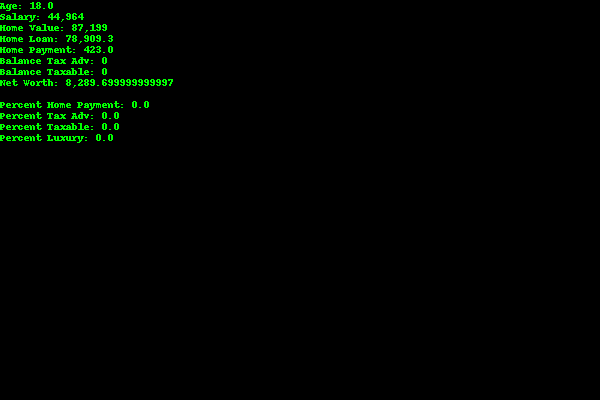

In [ ]:
env.reset()
PIL.Image.fromarray(env.render())

Just as before, the program instantiates two environments: one for training and one for evaluation. 

In [ ]:
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

You might be wondering why a DQN does not support continuous actions.  The reason for this limitation is that the DQN algorithm maps each action is an output neuron. Each of these neurons predicts the likely future reward fo taking each action. Generally, the DQN agent will perform the action that has the highest reward. The algorithm knows the future rewards for each particular action.  However, because a continuous number represented in a computer has an effectively infinite number of possible values, it is not possible to calculate a future reward estimate for all of them.

To provide a continuous action space we will use the Deep Deterministic Policy Gradients (DDPG) algorithm. [[Cite:lillicrap2015continuous]](https://arxiv.org/abs/1509.02971) This technique uses two neural networks.  The first neural network, called an actor, acts as the agent and predicts the expected reward for a given value of the action.  The second neural network, called a critic, is trained to predict the accuracy of the actor-network.  Training two neural networks in parallel that operator adversarially to each other is a  popular technique.  Earlier in this course, we saw that Generative Adversarial Networks (GAN) made use of a similar method. Figure 12.DDPG shows the structure of the DDPG network that we will use. 

**Figure 12.DDPG: Actor Critic Model**
![Deep Q-Learning](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/actor-critic.png "Actor Critic Model")

The environment provides the same input ($x(t)$) for each time step to both the actor and critic networks. The temporal difference error ($r(t)$) reports the difference between the estimated reward at any given state or time step and the actual reward. 

The following code creates the actor and critic neural networks.

In [ ]:
actor_fc_layers=(400, 300)
critic_obs_fc_layers=(400,)
critic_action_fc_layers=None
critic_joint_fc_layers=(300,)
ou_stddev=0.2
ou_damping=0.15
target_update_tau=0.05
target_update_period=5
dqda_clipping=None
td_errors_loss_fn=tf.compat.v1.losses.huber_loss
gamma=0.995
reward_scale_factor=1.0
gradient_clipping=None

actor_learning_rate=1e-4
critic_learning_rate=1e-3
debug_summaries=False
summarize_grads_and_vars=False

global_step = tf.compat.v1.train.get_or_create_global_step()

actor_net = actor_network.ActorNetwork(
        train_env.time_step_spec().observation,
        train_env.action_spec(),
        fc_layer_params=actor_fc_layers,
    )

critic_net_input_specs = (train_env.time_step_spec().observation,
                          train_env.action_spec())

critic_net = critic_network.CriticNetwork(
    critic_net_input_specs,
    observation_fc_layer_params=critic_obs_fc_layers,
    action_fc_layer_params=critic_action_fc_layers,
    joint_fc_layer_params=critic_joint_fc_layers,
)

tf_agent = ddpg_agent.DdpgAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    actor_network=actor_net,
    critic_network=critic_net,
    actor_optimizer=tf.compat.v1.train.AdamOptimizer(
        learning_rate=actor_learning_rate),
    critic_optimizer=tf.compat.v1.train.AdamOptimizer(
        learning_rate=critic_learning_rate),
    ou_stddev=ou_stddev,
    ou_damping=ou_damping,
    target_update_tau=target_update_tau,
    target_update_period=target_update_period,
    dqda_clipping=dqda_clipping,
    td_errors_loss_fn=td_errors_loss_fn,
    gamma=gamma,
    reward_scale_factor=reward_scale_factor,
    gradient_clipping=gradient_clipping,
    debug_summaries=debug_summaries,
    summarize_grads_and_vars=summarize_grads_and_vars,
    train_step_counter=global_step)
tf_agent.initialize()



## Metrics and Evaluation

Just as in previous examples, we will compute the average return over several episodes to evaluate performance.


In [ ]:
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]


# See also the metrics module for standard implementations of 
# different metrics.
# https://github.com/tensorflow/agents/tree/master/tf_agents/metrics

## Data Collection

Now execute the random policy in the environment for a few steps, recording the data in the replay buffer.

In [ ]:
def collect_step(environment, policy, buffer):
  time_step = environment.current_time_step()
  action_step = policy.action(time_step)
  next_time_step = environment.step(action_step.action)
  traj = trajectory.from_transition(time_step, action_step, next_time_step)

  # Add trajectory to the replay buffer
  buffer.add_batch(traj)

def collect_data(env, policy, buffer, steps):
  for _ in range(steps):
    collect_step(env, policy, buffer)

random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=tf_agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length)

collect_data(train_env, random_policy, replay_buffer, steps=100)

# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=batch_size, 
    num_steps=2).prefetch(3)


## Training the agent

We are now ready to train the agent. This process can take many hours, depending on how many episodes you wish to run through. As training occurs, this code will update on both the loss and average return. As training becomes more successful, the average return should increase. The losses reported reflecting the average loss for individual training batches.

In [ ]:
iterator = iter(dataset)

# (Optional) Optimize by wrapping some of the code in a graph using 
# TF function.
tf_agent.train = common.function(tf_agent.train)

# Reset the train step
tf_agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, tf_agent.policy, \
                                num_eval_episodes)
returns = [avg_return]

for _ in range(num_iterations):

  # Collect a few steps using collect_policy and save to the replay buffer.
  for _ in range(collect_steps_per_iteration):
    collect_step(train_env, tf_agent.collect_policy, replay_buffer)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = tf_agent.train(experience).loss

  step = tf_agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, tf_agent.policy, \
                                    num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)

step = 2500: loss = 0.00048063506255857646
step = 5000: loss = 0.0009628287516534328
step = 5000: Average Return = 5.293339252471924
step = 7500: loss = 0.0018985542701557279
step = 10000: loss = 0.0003614715242292732
step = 10000: Average Return = 8.426756858825684
step = 12500: loss = 0.001215201336890459
step = 15000: loss = 0.000617831654381007
step = 15000: Average Return = 10.426517486572266
step = 17500: loss = 0.0016348579665645957
step = 20000: loss = 0.0035204419400542974
step = 20000: Average Return = 8.884005546569824
step = 22500: loss = 0.5189836025238037
step = 25000: loss = 0.004120268858969212
step = 25000: Average Return = 10.956489562988281
step = 27500: loss = 0.003848570864647627
step = 30000: loss = 0.01014926191419363
step = 30000: Average Return = 8.715755462646484
step = 32500: loss = 0.010892617516219616
step = 35000: loss = 0.0060949139297008514
step = 35000: Average Return = 11.159963607788086
step = 37500: loss = 0.003919485956430435
step = 40000: loss = 0.

## Visualization

The notebook can plot the average return over training iterations. The average return should increase as the program performs more training iterations.

### Plots

Use **matplotlib.pyplot** to chart how the policy improved during training.

One iteration of **Cartpole-v0** consists of 200 time steps. The environment gives a reward of `+1` for each step the pole stays up, so the maximum return for one episode is 200. The charts show the return increasing towards that maximum each time it is evaluated during training. (It may be a little unstable and not increase each time monotonically.)

(4.931626772880554, 50.0)

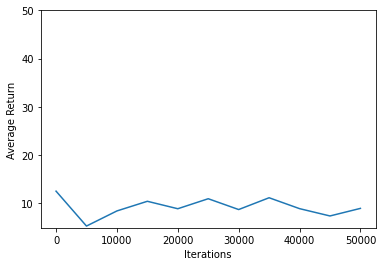

In [ ]:
iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=50)

### Videos

We use the following functions to produce video in Jupyter notebook.

In [ ]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

def create_policy_eval_video(policy, filename, num_episodes=5, fps=30):
  filename = filename + ".mp4"
  with imageio.get_writer(filename, fps=fps) as video:
    for _ in range(num_episodes):
      time_step = eval_env.reset()
      video.append_data(eval_py_env.render())
      while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = eval_env.step(action_step.action)
        video.append_data(eval_py_env.render())
  return embed_mp4(filename)

create_policy_eval_video(tf_agent.policy, "trained-agent")

# Proximal Policy Optimization

Proximal Policy Optimization is another way to navigate our policies.

OpenAI post on PPO: https://openai.com/blog/openai-baselines-ppo/

## Setup

## Install Dependencies


In [ ]:

################# Clone repository from github to colab session ################

"""

run this section if you want to clone all the preTrained networks, logs, graph figures, gifs 
from the GitHub repository to this colab session

"""


print("============================================================================================")

!git clone https://github.com/nikhilbarhate99/PPO-PyTorch

print("============================================================================================")



In [ ]:

"""

run this section if you want to copy all files and folders from cloned folder (PPO-PyTorch)
to current directory (/content/ or ./)

So you can load preTrained networks and log files without changing any paths

**  This will overwrite any saved networks, logs, graph figures, or gifs 
    that are created in this session before copying having the same name (or number)

"""

print("============================================================================================")

!cp -rv ./PPO-PyTorch/* ./

print("============================================================================================")


In [ ]:

"""

run this section if you want to delete original cloned folder and the cloned ipynb file
(after you have copied its contents to current directory)

"""


print("============================================================================================")

# delete original cloned folder
!rm -r ./PPO-PyTorch

# delete cloned ipynb file
!rm ./PPO_colab.ipynb

print("============================================================================================")



## **Introduction**
The notebook is divided into 5 major parts : 

*   **Part I** : define actor-critic network and PPO algorithm
*   **Part II** : train PPO algorithm and save network weights and log files
*   **Part III** : load (preTrained) network weights and test PPO algorithm
*   **Part IV** : load log files and plot graphs
*   **Part V** : install xvbf, load (preTrained) network weights and save images for gif and then generate gif



## Define actor critic methods and PPO algorithm

*   define actor critic networks
*   define PPO algorithm



In [ ]:


############################### Import libraries ###############################


import os
import glob
import time
from datetime import datetime

import torch
import torch.nn as nn
from torch.distributions import MultivariateNormal
from torch.distributions import Categorical

import numpy as np

import gym
import roboschool
import pybullet_envs


################################## set device ##################################

print("============================================================================================")


# set device to cpu or cuda
device = torch.device('cpu')

if(torch.cuda.is_available()): 
    device = torch.device('cuda:0') 
    torch.cuda.empty_cache()
    print("Device set to : " + str(torch.cuda.get_device_name(device)))
else:
    print("Device set to : cpu")
    
print("============================================================================================")




################################## PPO Policy ##################################


class RolloutBuffer:
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.is_terminals = []
    

    def clear(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.is_terminals[:]


class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, has_continuous_action_space, action_std_init):
        super(ActorCritic, self).__init__()

        self.has_continuous_action_space = has_continuous_action_space

        if has_continuous_action_space:
            self.action_dim = action_dim
            self.action_var = torch.full((action_dim,), action_std_init * action_std_init).to(device)

        # actor
        if has_continuous_action_space :
            self.actor = nn.Sequential(
                            nn.Linear(state_dim, 64),
                            nn.Tanh(),
                            nn.Linear(64, 64),
                            nn.Tanh(),
                            nn.Linear(64, action_dim),
                            nn.Tanh()
                        )
        else:
            self.actor = nn.Sequential(
                            nn.Linear(state_dim, 64),
                            nn.Tanh(),
                            nn.Linear(64, 64),
                            nn.Tanh(),
                            nn.Linear(64, action_dim),
                            nn.Softmax(dim=-1)
                        )

        
        # critic
        self.critic = nn.Sequential(
                        nn.Linear(state_dim, 64),
                        nn.Tanh(),
                        nn.Linear(64, 64),
                        nn.Tanh(),
                        nn.Linear(64, 1)
                    )
        
    def set_action_std(self, new_action_std):

        if self.has_continuous_action_space:
            self.action_var = torch.full((self.action_dim,), new_action_std * new_action_std).to(device)
        else:
            print("--------------------------------------------------------------------------------------------")
            print("WARNING : Calling ActorCritic::set_action_std() on discrete action space policy")
            print("--------------------------------------------------------------------------------------------")


    def forward(self):
        raise NotImplementedError
    

    def act(self, state):

        if self.has_continuous_action_space:
            action_mean = self.actor(state)
            cov_mat = torch.diag(self.action_var).unsqueeze(dim=0)
            dist = MultivariateNormal(action_mean, cov_mat)
        else:
            action_probs = self.actor(state)
            dist = Categorical(action_probs)

        action = dist.sample()
        action_logprob = dist.log_prob(action)
        
        return action.detach(), action_logprob.detach()
    

    def evaluate(self, state, action):

        if self.has_continuous_action_space:
            action_mean = self.actor(state)
            action_var = self.action_var.expand_as(action_mean)
            cov_mat = torch.diag_embed(action_var).to(device)
            dist = MultivariateNormal(action_mean, cov_mat)
            
            # for single action continuous environments
            if self.action_dim == 1:
                action = action.reshape(-1, self.action_dim)

        else:
            action_probs = self.actor(state)
            dist = Categorical(action_probs)

        action_logprobs = dist.log_prob(action)
        dist_entropy = dist.entropy()
        state_values = self.critic(state)
        
        return action_logprobs, state_values, dist_entropy


class PPO:
    def __init__(self, state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip, has_continuous_action_space, action_std_init=0.6):

        self.has_continuous_action_space = has_continuous_action_space

        if has_continuous_action_space:
            self.action_std = action_std_init

        self.gamma = gamma
        self.eps_clip = eps_clip
        self.K_epochs = K_epochs
        
        self.buffer = RolloutBuffer()

        self.policy = ActorCritic(state_dim, action_dim, has_continuous_action_space, action_std_init).to(device)
        self.optimizer = torch.optim.Adam([
                        {'params': self.policy.actor.parameters(), 'lr': lr_actor},
                        {'params': self.policy.critic.parameters(), 'lr': lr_critic}
                    ])

        self.policy_old = ActorCritic(state_dim, action_dim, has_continuous_action_space, action_std_init).to(device)
        self.policy_old.load_state_dict(self.policy.state_dict())
        
        self.MseLoss = nn.MSELoss()


    def set_action_std(self, new_action_std):
        
        if self.has_continuous_action_space:
            self.action_std = new_action_std
            self.policy.set_action_std(new_action_std)
            self.policy_old.set_action_std(new_action_std)
        
        else:
            print("--------------------------------------------------------------------------------------------")
            print("WARNING : Calling PPO::set_action_std() on discrete action space policy")
            print("--------------------------------------------------------------------------------------------")


    def decay_action_std(self, action_std_decay_rate, min_action_std):
        print("--------------------------------------------------------------------------------------------")

        if self.has_continuous_action_space:
            self.action_std = self.action_std - action_std_decay_rate
            self.action_std = round(self.action_std, 4)
            if (self.action_std <= min_action_std):
                self.action_std = min_action_std
                print("setting actor output action_std to min_action_std : ", self.action_std)
            else:
                print("setting actor output action_std to : ", self.action_std)
            self.set_action_std(self.action_std)

        else:
            print("WARNING : Calling PPO::decay_action_std() on discrete action space policy")

        print("--------------------------------------------------------------------------------------------")


    def select_action(self, state):

        if self.has_continuous_action_space:
            with torch.no_grad():
                state = torch.FloatTensor(state).to(device)
                action, action_logprob = self.policy_old.act(state)

            self.buffer.states.append(state)
            self.buffer.actions.append(action)
            self.buffer.logprobs.append(action_logprob)

            return action.detach().cpu().numpy().flatten()

        else:
            with torch.no_grad():
                state = torch.FloatTensor(state).to(device)
                action, action_logprob = self.policy_old.act(state)
            
            self.buffer.states.append(state)
            self.buffer.actions.append(action)
            self.buffer.logprobs.append(action_logprob)

            return action.item()


    def update(self):

        # Monte Carlo estimate of returns
        rewards = []
        discounted_reward = 0
        for reward, is_terminal in zip(reversed(self.buffer.rewards), reversed(self.buffer.is_terminals)):
            if is_terminal:
                discounted_reward = 0
            discounted_reward = reward + (self.gamma * discounted_reward)
            rewards.insert(0, discounted_reward)
            
        # Normalizing the rewards
        rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-7)

        # convert list to tensor
        old_states = torch.squeeze(torch.stack(self.buffer.states, dim=0)).detach().to(device)
        old_actions = torch.squeeze(torch.stack(self.buffer.actions, dim=0)).detach().to(device)
        old_logprobs = torch.squeeze(torch.stack(self.buffer.logprobs, dim=0)).detach().to(device)

        
        # Optimize policy for K epochs
        for _ in range(self.K_epochs):

            # Evaluating old actions and values
            logprobs, state_values, dist_entropy = self.policy.evaluate(old_states, old_actions)

            # match state_values tensor dimensions with rewards tensor
            state_values = torch.squeeze(state_values)
            
            # Finding the ratio (pi_theta / pi_theta__old)
            ratios = torch.exp(logprobs - old_logprobs.detach())

            # Finding Surrogate Loss
            advantages = rewards - state_values.detach()   
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1-self.eps_clip, 1+self.eps_clip) * advantages

            # final loss of clipped objective PPO
            loss = -torch.min(surr1, surr2) + 0.5*self.MseLoss(state_values, rewards) - 0.01*dist_entropy
            
            # take gradient step
            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()
            
        # Copy new weights into old policy
        self.policy_old.load_state_dict(self.policy.state_dict())

        # clear buffer
        self.buffer.clear()
    
    
    def save(self, checkpoint_path):
        torch.save(self.policy_old.state_dict(), checkpoint_path)
   

    def load(self, checkpoint_path):
        self.policy_old.load_state_dict(torch.load(checkpoint_path, map_location=lambda storage, loc: storage))
        self.policy.load_state_dict(torch.load(checkpoint_path, map_location=lambda storage, loc: storage))
        
        
       



Device set to : cpu


In [ ]:



################################# End of Part I ################################




## Train PPO algorithm on environments

*   train PPO algorithm on environments
*   save preTrained networks weights and log files



In [ ]:

print("============================================================================================")


################################### Training ###################################


####### initialize environment hyperparameters ######

env_name = "CartPole-v1"
has_continuous_action_space = False

max_ep_len = 400                    # max timesteps in one episode
max_training_timesteps = int(1e5)   # break training loop if timeteps > max_training_timesteps

print_freq = max_ep_len * 4     # print avg reward in the interval (in num timesteps)
log_freq = max_ep_len * 2       # log avg reward in the interval (in num timesteps)
save_model_freq = int(2e4)      # save model frequency (in num timesteps)

action_std = None


#####################################################


## Note : print/log frequencies should be > than max_ep_len


################ PPO hyperparameters ################


update_timestep = max_ep_len * 4      # update policy every n timesteps
K_epochs = 40               # update policy for K epochs
eps_clip = 0.2              # clip parameter for PPO
gamma = 0.99                # discount factor

lr_actor = 0.0003       # learning rate for actor network
lr_critic = 0.001       # learning rate for critic network

random_seed = 0         # set random seed if required (0 = no random seed)

#####################################################



print("training environment name : " + env_name)

env = gym.make(env_name)

# state space dimension
state_dim = env.observation_space.shape[0]

# action space dimension
if has_continuous_action_space:
    action_dim = env.action_space.shape[0]
else:
    action_dim = env.action_space.n



###################### logging ######################

#### log files for multiple runs are NOT overwritten

log_dir = "PPO_logs"
if not os.path.exists(log_dir):
      os.makedirs(log_dir)

log_dir = log_dir + '/' + env_name + '/'
if not os.path.exists(log_dir):
      os.makedirs(log_dir)


#### get number of log files in log directory
run_num = 0
current_num_files = next(os.walk(log_dir))[2]
run_num = len(current_num_files)


#### create new log file for each run 
log_f_name = log_dir + '/PPO_' + env_name + "_log_" + str(run_num) + ".csv"

print("current logging run number for " + env_name + " : ", run_num)
print("logging at : " + log_f_name)

#####################################################


################### checkpointing ###################

run_num_pretrained = 0      #### change this to prevent overwriting weights in same env_name folder

directory = "PPO_preTrained"
if not os.path.exists(directory):
      os.makedirs(directory)

directory = directory + '/' + env_name + '/'
if not os.path.exists(directory):
      os.makedirs(directory)


checkpoint_path = directory + "PPO_{}_{}_{}.pth".format(env_name, random_seed, run_num_pretrained)
print("save checkpoint path : " + checkpoint_path)

#####################################################


############# print all hyperparameters #############

print("--------------------------------------------------------------------------------------------")

print("max training timesteps : ", max_training_timesteps)
print("max timesteps per episode : ", max_ep_len)

print("model saving frequency : " + str(save_model_freq) + " timesteps")
print("log frequency : " + str(log_freq) + " timesteps")
print("printing average reward over episodes in last : " + str(print_freq) + " timesteps")

print("--------------------------------------------------------------------------------------------")

print("state space dimension : ", state_dim)
print("action space dimension : ", action_dim)

print("--------------------------------------------------------------------------------------------")

if has_continuous_action_space:
    print("Initializing a continuous action space policy")
    print("--------------------------------------------------------------------------------------------")
    print("starting std of action distribution : ", action_std)
    print("decay rate of std of action distribution : ", action_std_decay_rate)
    print("minimum std of action distribution : ", min_action_std)
    print("decay frequency of std of action distribution : " + str(action_std_decay_freq) + " timesteps")

else:
    print("Initializing a discrete action space policy")

print("--------------------------------------------------------------------------------------------")

print("PPO update frequency : " + str(update_timestep) + " timesteps") 
print("PPO K epochs : ", K_epochs)
print("PPO epsilon clip : ", eps_clip)
print("discount factor (gamma) : ", gamma)

print("--------------------------------------------------------------------------------------------")

print("optimizer learning rate actor : ", lr_actor)
print("optimizer learning rate critic : ", lr_critic)

if random_seed:
    print("--------------------------------------------------------------------------------------------")
    print("setting random seed to ", random_seed)
    torch.manual_seed(random_seed)
    env.seed(random_seed)
    np.random.seed(random_seed)

#####################################################

print("============================================================================================")

################# training procedure ################

# initialize a PPO agent
ppo_agent = PPO(state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip, has_continuous_action_space, action_std)


# track total training time
start_time = datetime.now().replace(microsecond=0)
print("Started training at (GMT) : ", start_time)

print("============================================================================================")


# logging file
log_f = open(log_f_name,"w+")
log_f.write('episode,timestep,reward\n')


# printing and logging variables
print_running_reward = 0
print_running_episodes = 0

log_running_reward = 0
log_running_episodes = 0

time_step = 0
i_episode = 0


# training loop
while time_step <= max_training_timesteps:
    
    state = env.reset()
    current_ep_reward = 0

    for t in range(1, max_ep_len+1):
        
        # select action with policy
        action = ppo_agent.select_action(state)
        state, reward, done, _ = env.step(action)
        
        # saving reward and is_terminals
        ppo_agent.buffer.rewards.append(reward)
        ppo_agent.buffer.is_terminals.append(done)
        
        time_step +=1
        current_ep_reward += reward

        # update PPO agent
        if time_step % update_timestep == 0:
            ppo_agent.update()

        # if continuous action space; then decay action std of ouput action distribution
        if has_continuous_action_space and time_step % action_std_decay_freq == 0:
            ppo_agent.decay_action_std(action_std_decay_rate, min_action_std)

        # log in logging file
        if time_step % log_freq == 0:

            # log average reward till last episode
            log_avg_reward = log_running_reward / log_running_episodes
            log_avg_reward = round(log_avg_reward, 4)

            log_f.write('{},{},{}\n'.format(i_episode, time_step, log_avg_reward))
            log_f.flush()

            log_running_reward = 0
            log_running_episodes = 0

        # printing average reward
        if time_step % print_freq == 0:

            # print average reward till last episode
            print_avg_reward = print_running_reward / print_running_episodes
            print_avg_reward = round(print_avg_reward, 2)

            print("Episode : {} \t\t Timestep : {} \t\t Average Reward : {}".format(i_episode, time_step, print_avg_reward))

            print_running_reward = 0
            print_running_episodes = 0
            
        # save model weights
        if time_step % save_model_freq == 0:
            print("--------------------------------------------------------------------------------------------")
            print("saving model at : " + checkpoint_path)
            ppo_agent.save(checkpoint_path)
            print("model saved")
            print("Elapsed Time  : ", datetime.now().replace(microsecond=0) - start_time)
            print("--------------------------------------------------------------------------------------------")
            
        # break; if the episode is over
        if done:
            break

    print_running_reward += current_ep_reward
    print_running_episodes += 1

    log_running_reward += current_ep_reward
    log_running_episodes += 1

    i_episode += 1


log_f.close()
env.close()




# print total training time
print("============================================================================================")
end_time = datetime.now().replace(microsecond=0)
print("Started training at (GMT) : ", start_time)
print("Finished training at (GMT) : ", end_time)
print("Total training time  : ", end_time - start_time)
print("============================================================================================")







In [ ]:



################################ End of Part II ################################




## Load and test preTrained networks on environments





In [ ]:


print("============================================================================================")


#################################### Testing ###################################


################## hyperparameters ##################

env_name = "CartPole-v1"
has_continuous_action_space = False
max_ep_len = 400
action_std = None


# env_name = "LunarLander-v2"
# has_continuous_action_space = False
# max_ep_len = 300
# action_std = None


# env_name = "BipedalWalker-v2"
# has_continuous_action_space = True
# max_ep_len = 1500           # max timesteps in one episode
# action_std = 0.1            # set same std for action distribution which was used while saving


# env_name = "RoboschoolWalker2d-v1"
# has_continuous_action_space = True
# max_ep_len = 1000           # max timesteps in one episode
# action_std = 0.1            # set same std for action distribution which was used while saving


total_test_episodes = 10    # total num of testing episodes

K_epochs = 80               # update policy for K epochs
eps_clip = 0.2              # clip parameter for PPO
gamma = 0.99                # discount factor

lr_actor = 0.0003           # learning rate for actor
lr_critic = 0.001           # learning rate for critic

#####################################################


env = gym.make(env_name)

# state space dimension
state_dim = env.observation_space.shape[0]

# action space dimension
if has_continuous_action_space:
    action_dim = env.action_space.shape[0]
else:
    action_dim = env.action_space.n


# initialize a PPO agent
ppo_agent = PPO(state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip, has_continuous_action_space, action_std)


# preTrained weights directory

random_seed = 0             #### set this to load a particular checkpoint trained on random seed
run_num_pretrained = 0      #### set this to load a particular checkpoint num


directory = "PPO_preTrained" + '/' + env_name + '/'
checkpoint_path = directory + "PPO_{}_{}_{}.pth".format(env_name, random_seed, run_num_pretrained)
print("loading network from : " + checkpoint_path)

ppo_agent.load(checkpoint_path)

print("--------------------------------------------------------------------------------------------")



test_running_reward = 0

for ep in range(1, total_test_episodes+1):
    ep_reward = 0
    state = env.reset()
    
    for t in range(1, max_ep_len+1):
        action = ppo_agent.select_action(state)
        state, reward, done, _ = env.step(action)
        ep_reward += reward
        
        if done:
            break

    # clear buffer    
    ppo_agent.buffer.clear()

    test_running_reward +=  ep_reward
    print('Episode: {} \t\t Reward: {}'.format(ep, round(ep_reward, 2)))
    ep_reward = 0

env.close()


print("============================================================================================")

avg_test_reward = test_running_reward / total_test_episodes
avg_test_reward = round(avg_test_reward, 2)
print("average test reward : " + str(avg_test_reward))

print("============================================================================================")







loading network from : PPO_preTrained/RoboschoolWalker2d-v1/PPO_RoboschoolWalker2d-v1_0_0.pth
--------------------------------------------------------------------------------------------
Episode: 1 		 Reward: 1644.37
Episode: 2 		 Reward: 1630.13
Episode: 3 		 Reward: 116.13
Episode: 4 		 Reward: 1600.93
Episode: 5 		 Reward: 1635.95
Episode: 6 		 Reward: 1647.41
Episode: 7 		 Reward: 1639.05
Episode: 8 		 Reward: 1629.42
Episode: 9 		 Reward: 33.27
Episode: 10 		 Reward: 1623.71
average test reward : 1320.04


In [ ]:



################################ End of Part III ###############################





## Load log files and plot graph

*   load log files using pandas
*   plot graph using matplotlib



loading data from : PPO_logs/RoboschoolWalker2d-v1//PPO_RoboschoolWalker2d-v1_log_0.csv
data shape :  (1500, 3)
--------------------------------------------------------------------------------------------
loading data from : PPO_logs/RoboschoolWalker2d-v1//PPO_RoboschoolWalker2d-v1_log_1.csv
data shape :  (1500, 3)
--------------------------------------------------------------------------------------------
loading data from : PPO_logs/RoboschoolWalker2d-v1//PPO_RoboschoolWalker2d-v1_log_2.csv
data shape :  (1500, 3)
--------------------------------------------------------------------------------------------
figure saved at :  PPO_figs/RoboschoolWalker2d-v1//PPO_RoboschoolWalker2d-v1_fig_0.png


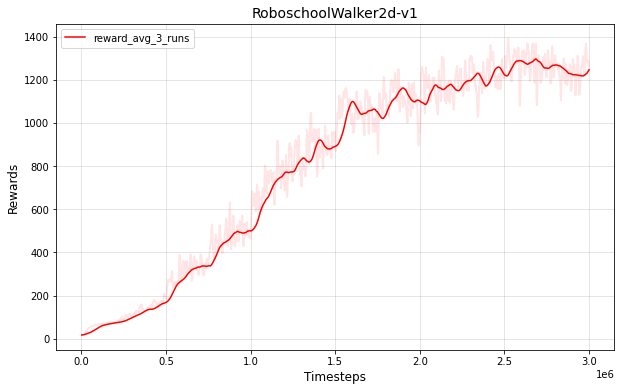

In [ ]:

import os
import pandas as pd
import matplotlib.pyplot as plt


print("============================================================================================")

env_name = 'CartPole-v1'
# env_name = 'LunarLander-v2'
# env_name = 'BipedalWalker-v2'
# env_name = 'RoboschoolWalker2d-v1'


fig_num = 0     #### change this to prevent overwriting figures in same env_name folder

plot_avg = True    # plot average of all runs; else plot all runs separately

fig_width = 10
fig_height = 6


# smooth out rewards to get a smooth and a less smooth (var) plot lines
window_len_smooth = 50
min_window_len_smooth = 1
linewidth_smooth = 1.5
alpha_smooth = 1

window_len_var = 5
min_window_len_var = 1
linewidth_var = 2
alpha_var = 0.1


colors = ['red', 'blue', 'green', 'orange', 'purple', 'olive', 'brown', 'magenta', 'cyan', 'crimson','gray', 'black']


# make directory for saving figures
figures_dir = "PPO_figs"
if not os.path.exists(figures_dir):
    os.makedirs(figures_dir)

# make environment directory for saving figures
figures_dir = figures_dir + '/' + env_name + '/'
if not os.path.exists(figures_dir):
    os.makedirs(figures_dir)


fig_save_path = figures_dir + '/PPO_' + env_name + '_fig_' + str(fig_num) + '.png'


# get number of log files in directory
log_dir = "PPO_logs" + '/' + env_name + '/'

current_num_files = next(os.walk(log_dir))[2]
num_runs = len(current_num_files)


all_runs = []

for run_num in range(num_runs):

    log_f_name = log_dir + '/PPO_' + env_name + "_log_" + str(run_num) + ".csv"
    print("loading data from : " + log_f_name)
    data = pd.read_csv(log_f_name)
    data = pd.DataFrame(data)
    
    print("data shape : ", data.shape)
    
    all_runs.append(data)
    print("--------------------------------------------------------------------------------------------")


ax = plt.gca()

if plot_avg:
    # average all runs
    df_concat = pd.concat(all_runs)
    df_concat_groupby = df_concat.groupby(df_concat.index)
    data_avg = df_concat_groupby.mean()

    # smooth out rewards to get a smooth and a less smooth (var) plot lines
    data_avg['reward_smooth'] = data_avg['reward'].rolling(window=window_len_smooth, win_type='triang', min_periods=min_window_len_smooth).mean()
    data_avg['reward_var'] = data_avg['reward'].rolling(window=window_len_var, win_type='triang', min_periods=min_window_len_var).mean()

    data_avg.plot(kind='line', x='timestep' , y='reward_smooth',ax=ax,color=colors[0],  linewidth=linewidth_smooth, alpha=alpha_smooth)
    data_avg.plot(kind='line', x='timestep' , y='reward_var',ax=ax,color=colors[0],  linewidth=linewidth_var, alpha=alpha_var)

    # keep only reward_smooth in the legend and rename it
    handles, labels = ax.get_legend_handles_labels()
    ax.legend([handles[0]], ["reward_avg_" + str(len(all_runs)) + "_runs"], loc=2)


else:
    for i, run in enumerate(all_runs):
        # smooth out rewards to get a smooth and a less smooth (var) plot lines
        run['reward_smooth_' + str(i)] = run['reward'].rolling(window=window_len_smooth, win_type='triang', min_periods=min_window_len_smooth).mean()
        run['reward_var_' + str(i)] = run['reward'].rolling(window=window_len_var, win_type='triang', min_periods=min_window_len_var).mean()
        
        # plot the lines
        run.plot(kind='line', x='timestep' , y='reward_smooth_' + str(i),ax=ax,color=colors[i % len(colors)],  linewidth=linewidth_smooth, alpha=alpha_smooth)
        run.plot(kind='line', x='timestep' , y='reward_var_' + str(i),ax=ax,color=colors[i % len(colors)],  linewidth=linewidth_var, alpha=alpha_var)

    # keep alternate elements (reward_smooth_i) in the legend
    handles, labels = ax.get_legend_handles_labels()
    new_handles = []
    new_labels = []
    for i in range(len(handles)):
        if(i%2 == 0):
            new_handles.append(handles[i])
            new_labels.append(labels[i])
    ax.legend(new_handles, new_labels, loc=2)



# ax.set_yticks(np.arange(0, 1800, 200))
# ax.set_xticks(np.arange(0, int(4e6), int(5e5)))


ax.grid(color='gray', linestyle='-', linewidth=1, alpha=0.2)

ax.set_xlabel("Timesteps", fontsize=12)
ax.set_ylabel("Rewards", fontsize=12)

plt.title(env_name, fontsize=14)


fig = plt.gcf()
fig.set_size_inches(fig_width, fig_height)

print("============================================================================================")

plt.savefig(fig_save_path)
print("figure saved at : ", fig_save_path)

print("============================================================================================")


plt.show()




In [ ]:



################################ End of Part IV ################################




## Final plots

*   install virtual display libraries for rendering on colab / remote server ^
*   load preTrained networks and save images for gif
*   generate and save gif from previously saved images

*   ^ If running locally; do not install xvbf and pyvirtualdisplay. Just comment out the virtual display code and render it normally. 
*   ^ You will still require to use ipythondisplay, if you want to render it in the Jupyter Notebook.


In [ ]:


#### to render on colab / server / headless machine install virtual display libraries

!apt-get install -y xvfb python-opengl > /dev/null 2>&1

!pip install gym pyvirtualdisplay > /dev/null 2>&1



In [ ]:


############################# save images for gif ##############################


import os
import glob

import gym
import roboschool
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


from IPython import display as ipythondisplay

from pyvirtualdisplay import Display



"""
One frame corresponding to each timestep is saved in a folder :

PPO_gif_images/env_name/000001.jpg
PPO_gif_images/env_name/000002.jpg
PPO_gif_images/env_name/000003.jpg
...
...
...


if this section is run multiple times or for multiple episodes for the same env_name; 
then the saved images will be overwritten.

"""




#### beginning of virtual display code section

display = Display(visible=0, size=(400, 300))
display.start()

#### end of virtual display code section



print("============================================================================================")


################## hyperparameters ##################

env_name = "CartPole-v1"
has_continuous_action_space = False
max_ep_len = 400
action_std = None


# env_name = "LunarLander-v2"
# has_continuous_action_space = False
# max_ep_len = 300
# action_std = None

# env_name = "BipedalWalker-v2"
# has_continuous_action_space = True
# max_ep_len = 1500           # max timesteps in one episode
# action_std = 0.1            # set same std for action distribution which was used while saving

# env_name = "RoboschoolWalker2d-v1"
# has_continuous_action_space = True
# max_ep_len = 1000           # max timesteps in one episode
# action_std = 0.1            # set same std for action distribution which was used while saving


total_test_episodes = 1     # save gif for only one episode

render_ipython = False      # plot the images using matplotlib and ipythondisplay before saving (slow)

K_epochs = 80               # update policy for K epochs
eps_clip = 0.2              # clip parameter for PPO
gamma = 0.99                # discount factor

lr_actor = 0.0003         # learning rate for actor
lr_critic = 0.001         # learning rate for critic

#####################################################


env = gym.make(env_name)

# state space dimension
state_dim = env.observation_space.shape[0]

# action space dimension
if has_continuous_action_space:
    action_dim = env.action_space.shape[0]
else:
    action_dim = env.action_space.n



# make directory for saving gif images
gif_images_dir = "PPO_gif_images" + '/'
if not os.path.exists(gif_images_dir):
    os.makedirs(gif_images_dir)

# make environment directory for saving gif images
gif_images_dir = gif_images_dir + '/' + env_name + '/'
if not os.path.exists(gif_images_dir):
    os.makedirs(gif_images_dir)

# make directory for gif
gif_dir = "PPO_gifs" + '/'
if not os.path.exists(gif_dir):
    os.makedirs(gif_dir)

# make environment directory for gif
gif_dir = gif_dir + '/' + env_name  + '/'
if not os.path.exists(gif_dir):
    os.makedirs(gif_dir)



ppo_agent = PPO(state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip, has_continuous_action_space, action_std)


# preTrained weights directory

random_seed = 0             #### set this to load a particular checkpoint trained on random seed
run_num_pretrained = 0      #### set this to load a particular checkpoint num


directory = "PPO_preTrained" + '/' + env_name + '/'
checkpoint_path = directory + "PPO_{}_{}_{}.pth".format(env_name, random_seed, run_num_pretrained)
print("loading network from : " + checkpoint_path)

ppo_agent.load(checkpoint_path)

print("--------------------------------------------------------------------------------------------")



test_running_reward = 0

for ep in range(1, total_test_episodes+1):
    
    ep_reward = 0
    state = env.reset()

    for t in range(1, max_ep_len+1):
        action = ppo_agent.select_action(state)
        state, reward, done, _ = env.step(action)
        ep_reward += reward

        img = env.render(mode = 'rgb_array')


        #### beginning of ipythondisplay code section 1

        if render_ipython:
            plt.imshow(img)
            ipythondisplay.clear_output(wait=True)
            ipythondisplay.display(plt.gcf())

        #### end of ipythondisplay code section 1


        img = Image.fromarray(img)
        img.save(gif_images_dir + '/' + str(t).zfill(6) + '.jpg')
        
        if done:
            break
    
    # clear buffer    
    ppo_agent.buffer.clear()
    
    test_running_reward +=  ep_reward
    print('Episode: {} \t\t Reward: {}'.format(ep, round(ep_reward, 2)))
    ep_reward = 0



env.close()


#### beginning of ipythondisplay code section 2

if render_ipython:
    ipythondisplay.clear_output(wait=True)

#### end of ipythondisplay code section 2




print("============================================================================================")

print("total number of frames / timesteps / images saved : ", t)

avg_test_reward = test_running_reward / total_test_episodes
avg_test_reward = round(avg_test_reward, 2)
print("average test reward : " + str(avg_test_reward))

print("============================================================================================")







In [ ]:



######################## generate gif from saved images ########################


print("============================================================================================")

env_name = 'CartPole-v1'
# env_name = 'LunarLander-v2'
# env_name = 'BipedalWalker-v2'
# env_name = 'RoboschoolWalker2d-v1'


gif_num = 0     #### change this to prevent overwriting gifs in same env_name folder

# adjust following parameters to get desired duration, size (bytes) and smoothness of gif
total_timesteps = 300
step = 10
frame_duration = 150


# input images
gif_images_dir = "PPO_gif_images/" + env_name + '/*.jpg'


# ouput gif path
gif_dir = "PPO_gifs"
if not os.path.exists(gif_dir):
    os.makedirs(gif_dir)

gif_dir = gif_dir + '/' + env_name
if not os.path.exists(gif_dir):
    os.makedirs(gif_dir)

gif_path = gif_dir + '/PPO_' + env_name + '_gif_' + str(gif_num) + '.gif'



img_paths = sorted(glob.glob(gif_images_dir))
img_paths = img_paths[:total_timesteps]
img_paths = img_paths[::step]


print("total frames in gif : ", len(img_paths))
print("total duration of gif : " + str(round(len(img_paths) * frame_duration / 1000, 2)) + " seconds")



# save gif
img, *imgs = [Image.open(f) for f in img_paths]
img.save(fp=gif_path, format='GIF', append_images=imgs, save_all=True, optimize=True, duration=frame_duration, loop=0)

print("saved gif at : ", gif_path)



print("============================================================================================")




In [ ]:

############################# check gif byte size ##############################


import os
import glob


print("============================================================================================")

env_name = 'CartPole-v1'
# env_name = 'LunarLander-v2'
# env_name = 'BipedalWalker-v2'
# env_name = 'RoboschoolWalker2d-v1'


gif_dir = "PPO_gifs/" + env_name + '/*.gif'

gif_paths = sorted(glob.glob(gif_dir))

for gif_path in gif_paths:
    file_size = os.path.getsize(gif_path)
    print(gif_path + '\t\t' + str(round(file_size / (1024 * 1024), 2)) + " MB")


print("============================================================================================")





In [ ]:



################################# End of Part V ################################




################################################################################

---------------------------------------------------------------------------- That's all folks ! ----------------------------------------------------------------------------


################################################################################

In [ ]:


############ install compatible version of OpenAI roboschool and gym ###########

!pip install roboschool==1.0.48 gym==0.15.4

!pip install box2d-py

!pip install pybullet



# Reinforcement Learning for Finance



## Deep Reinforcement Learning for Stock Trading from Scratch: Portfolio Allocation

Tutorials to use OpenAI DRL to perform portfolio allocation in one Jupyter Notebook | Presented at NeurIPS 2020: Deep RL Workshop

* This blog is based on our paper: FinRL: A Deep Reinforcement Learning Library for Automated Stock Trading in Quantitative Finance, presented at NeurIPS 2020: Deep RL Workshop.
* Check out medium blog for detailed explanations: 
* Please report any issues to our Github: https://github.com/AI4Finance-LLC/FinRL-Library/issues
* **Pytorch Version** 



### Part 1. Problem Definition

This problem is to design an automated trading solution for single stock trading. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use
an action space {−k, ..., −1, 0, 1, ..., k}, where k denotes the number of shares. For example, "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: Dow 30 consituents


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


### Part 2. Getting Started- Load Python Packages

### 2.1. Install all the packages through FinRL library


In [ ]:
## install finrl library
!pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git

  Cloning https://github.com/AI4Finance-LLC/FinRL-Library.git to /tmp/pip-req-build-bwdyljxc
  Running command git clone -q https://github.com/AI4Finance-LLC/FinRL-Library.git /tmp/pip-req-build-bwdyljxc
     |████████████████████████████████| 153kB 6.0MB/s 
  Cloning https://github.com/quantopian/pyfolio.git to /tmp/pip-install-jk1inqx3/pyfolio
  Running command git clone -q https://github.com/quantopian/pyfolio.git /tmp/pip-install-jk1inqx3/pyfolio
     |████████████████████████████████| 5.5MB 8.8MB/s 
     |████████████████████████████████| 61kB 6.1MB/s 
  Created wheel for finrl: filename=finrl-0.0.3-cp37-none-any.whl size=38201 sha256=680913f069c396f38e0c508600b450102190f08e0b0bba53c58c334981ccbe6c
  Stored in directory: /tmp/pip-ephem-wheel-cache-a1bbwmjm/wheels/9c/19/bf/c644def96612df1ad42c94d5304966797eaa3221dffc5efe0b
  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22616 sha256=2a578f51d56d3d8fff23683c041d6815f487abf3c6c97d4739d122055a6599b3
  


### 2.2. Check if the additional packages needed are present, if not install them. 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

### 2.3. Import Packages

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
import datetime

from finrl.config import config
from finrl.marketdata.yahoodownloader import YahooDownloader
from finrl.preprocessing.preprocessors import FeatureEngineer
from finrl.preprocessing.data import data_split
from finrl.env.env_portfolio import StockPortfolioEnv

from finrl.model.models import DRLAgent
from finrl.trade.backtest import backtest_stats, backtest_plot, get_daily_return, get_baseline,convert_daily_return_to_pyfolio_ts

import sys
sys.path.append("../FinRL-Library")

/usr/local/lib/python3.7/dist-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


### 2.4. Create Folders

In [ ]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

### Part 3. Download Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).


In [ ]:
print(config.DOW_30_TICKER)

['AAPL', 'MSFT', 'JPM', 'V', 'RTX', 'PG', 'GS', 'NKE', 'DIS', 'AXP', 'HD', 'INTC', 'WMT', 'IBM', 'MRK', 'UNH', 'KO', 'CAT', 'TRV', 'JNJ', 'CVX', 'MCD', 'VZ', 'CSCO', 'XOM', 'BA', 'MMM', 'PFE', 'WBA', 'DD']


In [ ]:
df = YahooDownloader(start_date = '2008-01-01',
                     end_date = '2021-01-01',
                     ticker_list = config.DOW_30_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [ ]:
df.head()

date       open       high  ...      volume   tic  day
0  2008-01-02   7.116786   7.152143  ...  1079178800  AAPL    2
1  2008-01-02  52.090000  52.320000  ...     8053700   AXP    2
2  2008-01-02  87.570000  87.839996  ...     4303000    BA    2
3  2008-01-02  72.559998  72.669998  ...     6337800   CAT    2
4  2008-01-02  27.000000  27.299999  ...    64338900  CSCO    2

[5 rows x 8 columns]

In [ ]:
df.shape

(98167, 8)

### Part 4: Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
* Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: MACD and RSI.
* Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

In [ ]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    use_turbulence=False,
                    user_defined_feature = False)

df = fe.preprocess_data(df)

Successfully added technical indicators


In [ ]:
df.shape

(98167, 16)

In [ ]:
df.head()

date       open       high  ...  dx_30  close_30_sma  close_60_sma
0  2008-01-02   7.116786   7.152143  ...  100.0      5.993858      5.993858
1  2008-01-02  52.090000  52.320000  ...  100.0      5.995243      5.995243
2  2008-01-02  87.570000  87.839996  ...  100.0      5.843120      5.843120
3  2008-01-02  72.559998  72.669998  ...  100.0      5.748524      5.748524
4  2008-01-02  27.000000  27.299999  ...  100.0      5.652452      5.652452

[5 rows x 16 columns]

#### Add covariance matrix as states

In [ ]:
# add covariance matrix as states
df=df.sort_values(['date','tic'],ignore_index=True)
df.index = df.date.factorize()[0]

cov_list = []
# look back is one year
lookback=252
for i in range(lookback,len(df.index.unique())):
  data_lookback = df.loc[i-lookback:i,:]
  price_lookback=data_lookback.pivot_table(index = 'date',columns = 'tic', values = 'close')
  return_lookback = price_lookback.pct_change().dropna()
  covs = return_lookback.cov().values 
  cov_list.append(covs)
  
df_cov = pd.DataFrame({'date':df.date.unique()[lookback:],'cov_list':cov_list})
df = df.merge(df_cov, on='date')
df = df.sort_values(['date','tic']).reset_index(drop=True)
        

In [ ]:
df.shape

(90660, 17)

In [ ]:
df.head()

date  ...                                           cov_list
0  2008-12-31  ...  [[0.0014139107044444073, 0.0011800730357944612...
1  2008-12-31  ...  [[0.0014139107044444073, 0.0011800730357944612...
2  2008-12-31  ...  [[0.0014139107044444073, 0.0011800730357944612...
3  2008-12-31  ...  [[0.0014139107044444073, 0.0011800730357944612...
4  2008-12-31  ...  [[0.0014139107044444073, 0.0011800730357944612...

[5 rows x 17 columns]

### Part 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

### Training data split: 2009-01-01 to 2018-12-31

In [ ]:
train = data_split(df, '2009-01-01','2019-01-01')
#trade = data_split(df, '2020-01-01', config.END_DATE)

In [ ]:
train.head()

date  ...                                           cov_list
0  2009-01-02  ...  [[0.001427708918378416, 0.0011886537539480882,...
0  2009-01-02  ...  [[0.001427708918378416, 0.0011886537539480882,...
0  2009-01-02  ...  [[0.001427708918378416, 0.0011886537539480882,...
0  2009-01-02  ...  [[0.001427708918378416, 0.0011886537539480882,...
0  2009-01-02  ...  [[0.001427708918378416, 0.0011886537539480882,...

[5 rows x 17 columns]

### Environment for Portfolio Allocation


In [ ]:
import numpy as np
import pandas as pd
from gym.utils import seeding
import gym
from gym import spaces
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from stable_baselines3.common.vec_env import DummyVecEnv


class StockPortfolioEnv(gym.Env):
    """A single stock trading environment for OpenAI gym

    Attributes
    ----------
        df: DataFrame
            input data
        stock_dim : int
            number of unique stocks
        hmax : int
            maximum number of shares to trade
        initial_amount : int
            start money
        transaction_cost_pct: float
            transaction cost percentage per trade
        reward_scaling: float
            scaling factor for reward, good for training
        state_space: int
            the dimension of input features
        action_space: int
            equals stock dimension
        tech_indicator_list: list
            a list of technical indicator names
        turbulence_threshold: int
            a threshold to control risk aversion
        day: int
            an increment number to control date

    Methods
    -------
    _sell_stock()
        perform sell action based on the sign of the action
    _buy_stock()
        perform buy action based on the sign of the action
    step()
        at each step the agent will return actions, then 
        we will calculate the reward, and return the next observation.
    reset()
        reset the environment
    render()
        use render to return other functions
    save_asset_memory()
        return account value at each time step
    save_action_memory()
        return actions/positions at each time step
        

    """
    metadata = {'render.modes': ['human']}

    def __init__(self, 
                df,
                stock_dim,
                hmax,
                initial_amount,
                transaction_cost_pct,
                reward_scaling,
                state_space,
                action_space,
                tech_indicator_list,
                turbulence_threshold=None,
                lookback=252,
                day = 0):
        #super(StockEnv, self).__init__()
        #money = 10 , scope = 1
        self.day = day
        self.lookback=lookback
        self.df = df
        self.stock_dim = stock_dim
        self.hmax = hmax
        self.initial_amount = initial_amount
        self.transaction_cost_pct =transaction_cost_pct
        self.reward_scaling = reward_scaling
        self.state_space = state_space
        self.action_space = action_space
        self.tech_indicator_list = tech_indicator_list

        # action_space normalization and shape is self.stock_dim
        self.action_space = spaces.Box(low = 0, high = 1,shape = (self.action_space,)) 
        # Shape = (34, 30)
        # covariance matrix + technical indicators
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape = (self.state_space+len(self.tech_indicator_list),self.state_space))

        # load data from a pandas dataframe
        self.data = self.df.loc[self.day,:]
        self.covs = self.data['cov_list'].values[0]
        self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
        self.terminal = False     
        self.turbulence_threshold = turbulence_threshold        
        # initalize state: inital portfolio return + individual stock return + individual weights
        self.portfolio_value = self.initial_amount

        # memorize portfolio value each step
        self.asset_memory = [self.initial_amount]
        # memorize portfolio return each step
        self.portfolio_return_memory = [0]
        self.actions_memory=[[1/self.stock_dim]*self.stock_dim]
        self.date_memory=[self.data.date.unique()[0]]

        
    def step(self, actions):
        # print(self.day)
        self.terminal = self.day >= len(self.df.index.unique())-1
        # print(actions)

        if self.terminal:
            df = pd.DataFrame(self.portfolio_return_memory)
            df.columns = ['daily_return']
            plt.plot(df.daily_return.cumsum(),'r')
            plt.savefig('results/cumulative_reward.png')
            plt.close()
            
            plt.plot(self.portfolio_return_memory,'r')
            plt.savefig('results/rewards.png')
            plt.close()

            print("=================================")
            print("begin_total_asset:{}".format(self.asset_memory[0]))           
            print("end_total_asset:{}".format(self.portfolio_value))

            df_daily_return = pd.DataFrame(self.portfolio_return_memory)
            df_daily_return.columns = ['daily_return']
            if df_daily_return['daily_return'].std() !=0:
              sharpe = (252**0.5)*df_daily_return['daily_return'].mean()/ \
                       df_daily_return['daily_return'].std()
              print("Sharpe: ",sharpe)
            print("=================================")
            
            return self.state, self.reward, self.terminal,{}

        else:
            #print("Model actions: ",actions)
            # actions are the portfolio weight
            # normalize to sum of 1
            #if (np.array(actions) - np.array(actions).min()).sum() != 0:
            #  norm_actions = (np.array(actions) - np.array(actions).min()) / (np.array(actions) - np.array(actions).min()).sum()
            #else:
            #  norm_actions = actions
            weights = self.softmax_normalization(actions) 
            #print("Normalized actions: ", weights)
            self.actions_memory.append(weights)
            last_day_memory = self.data

            #load next state
            self.day += 1
            self.data = self.df.loc[self.day,:]
            self.covs = self.data['cov_list'].values[0]
            self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
            #print(self.state)
            # calcualte portfolio return
            # individual stocks' return * weight
            portfolio_return = sum(((self.data.close.values / last_day_memory.close.values)-1)*weights)
            # update portfolio value
            new_portfolio_value = self.portfolio_value*(1+portfolio_return)
            self.portfolio_value = new_portfolio_value

            # save into memory
            self.portfolio_return_memory.append(portfolio_return)
            self.date_memory.append(self.data.date.unique()[0])            
            self.asset_memory.append(new_portfolio_value)

            # the reward is the new portfolio value or end portfolo value
            self.reward = new_portfolio_value 
            #print("Step reward: ", self.reward)
            #self.reward = self.reward*self.reward_scaling

        return self.state, self.reward, self.terminal, {}

    def reset(self):
        self.asset_memory = [self.initial_amount]
        self.day = 0
        self.data = self.df.loc[self.day,:]
        # load states
        self.covs = self.data['cov_list'].values[0]
        self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
        self.portfolio_value = self.initial_amount
        #self.cost = 0
        #self.trades = 0
        self.terminal = False 
        self.portfolio_return_memory = [0]
        self.actions_memory=[[1/self.stock_dim]*self.stock_dim]
        self.date_memory=[self.data.date.unique()[0]] 
        return self.state
    
    def render(self, mode='human'):
        return self.state
        
    def softmax_normalization(self, actions):
        numerator = np.exp(actions)
        denominator = np.sum(np.exp(actions))
        softmax_output = numerator/denominator
        return softmax_output

    
    def save_asset_memory(self):
        date_list = self.date_memory
        portfolio_return = self.portfolio_return_memory
        #print(len(date_list))
        #print(len(asset_list))
        df_account_value = pd.DataFrame({'date':date_list,'daily_return':portfolio_return})
        return df_account_value

    def save_action_memory(self):
        # date and close price length must match actions length
        date_list = self.date_memory
        df_date = pd.DataFrame(date_list)
        df_date.columns = ['date']
        
        action_list = self.actions_memory
        df_actions = pd.DataFrame(action_list)
        df_actions.columns = self.data.tic.values
        df_actions.index = df_date.date
        #df_actions = pd.DataFrame({'date':date_list,'actions':action_list})
        return df_actions

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def get_sb_env(self):
        e = DummyVecEnv([lambda: self])
        obs = e.reset()
        return e, obs

In [ ]:
stock_dimension = len(train.tic.unique())
state_space = stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 30, State Space: 30


In [ ]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "transaction_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": config.TECHNICAL_INDICATORS_LIST, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4
    
}

e_train_gym = StockPortfolioEnv(df = train, **env_kwargs)

In [ ]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


### Part 6: Implement DRL Algorithms
* The implementation of the DRL algorithms are based on **OpenAI Baselines** and **Stable Baselines**. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

In [ ]:
# initialize
agent = DRLAgent(env = env_train)

### Model 1: **A2C**


In [ ]:
agent = DRLAgent(env = env_train)

A2C_PARAMS = {"n_steps": 5, "ent_coef": 0.005, "learning_rate": 0.0002}
model_a2c = agent.get_model(model_name="a2c",model_kwargs = A2C_PARAMS)

{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0002}
Using cpu device


In [ ]:
trained_a2c = agent.train_model(model=model_a2c, 
                                tb_log_name='a2c',
                                total_timesteps=60000)

Logging to tensorboard_log/a2c/a2c_1
-------------------------------------
| time/                 |           |
|    fps                | 130       |
|    iterations         | 100       |
|    time_elapsed       | 3         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -42.5     |
|    explained_variance | -4.23e+15 |
|    learning_rate      | 0.0002    |
|    n_updates          | 99        |
|    policy_loss        | 1.8e+08   |
|    std                | 0.997     |
|    value_loss         | 2.48e+13  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 157       |
|    iterations         | 200       |
|    time_elapsed       | 6         |
|    total_timesteps    | 1000      |
| train/                |           |
|    entropy_loss       | -42.5     |
|    explained_variance | -7.89e+14 |
|    learning_rate      | 0.0002    |
|    n_update

### Model 2: **PPO**


In [ ]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.005,
    "learning_rate": 0.0001,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

{'n_steps': 2048, 'ent_coef': 0.005, 'learning_rate': 0.0001, 'batch_size': 128}
Using cpu device


In [ ]:
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=80000)

Logging to tensorboard_log/ppo/ppo_3
-----------------------------
| time/              |      |
|    fps             | 458  |
|    iterations      | 1    |
|    time_elapsed    | 4    |
|    total_timesteps | 2048 |
-----------------------------
begin_total_asset:1000000
end_total_asset:4917364.6278486075
Sharpe:  1.074414829116363
--------------------------------------------
| time/                   |                |
|    fps                  | 391            |
|    iterations           | 2              |
|    time_elapsed         | 10             |
|    total_timesteps      | 4096           |
| train/                  |                |
|    approx_kl            | -7.8231096e-08 |
|    clip_fraction        | 0              |
|    clip_range           | 0.2            |
|    entropy_loss         | -42.6          |
|    explained_variance   | -3.71e+14      |
|    learning_rate        | 0.0001         |
|    loss                 | 7.78e+14       |
|    n_updates            | 10     

### Model 3: **DDPG**


In [ ]:
agent = DRLAgent(env = env_train)
DDPG_PARAMS = {"batch_size": 128, "buffer_size": 50000, "learning_rate": 0.001}


model_ddpg = agent.get_model("ddpg",model_kwargs = DDPG_PARAMS)

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cpu device


In [ ]:
trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=50000)

Logging to tensorboard_log/ddpg/ddpg_2
begin_total_asset:1000000
end_total_asset:4625995.900359718
Sharpe:  1.040202670783119
begin_total_asset:1000000
end_total_asset:4450723.86820311
Sharpe:  1.008267759668747
begin_total_asset:1000000
end_total_asset:4450723.86820311
Sharpe:  1.008267759668747
begin_total_asset:1000000
end_total_asset:4450723.86820311
Sharpe:  1.008267759668747
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 22        |
|    time_elapsed    | 439       |
|    total timesteps | 10064     |
| train/             |           |
|    actor_loss      | -6.99e+07 |
|    critic_loss     | 7.27e+12  |
|    learning_rate   | 0.001     |
|    n_updates       | 7548      |
----------------------------------
begin_total_asset:1000000
end_total_asset:4450723.86820311
Sharpe:  1.008267759668747
begin_total_asset:1000000
end_total_asset:4450723.86820311
Sharpe:  1.008267759668747
begin_total_asset:100000

### Model 4: **SAC**


In [ ]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 100000,
    "learning_rate": 0.0003,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

{'batch_size': 128, 'buffer_size': 100000, 'learning_rate': 0.0003, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cpu device


In [ ]:
trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=50000)

Logging to tensorboard_log/sac/sac_1
begin_total_asset:1000000
end_total_asset:4449463.498168942
Sharpe:  1.01245667390232
begin_total_asset:1000000
end_total_asset:4418643.239765096
Sharpe:  1.0135796594260282
begin_total_asset:1000000
end_total_asset:4418644.1960784905
Sharpe:  1.0135797537524718
begin_total_asset:1000000
end_total_asset:4418659.429680678
Sharpe:  1.013581852537709
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 12        |
|    time_elapsed    | 783       |
|    total timesteps | 10064     |
| train/             |           |
|    actor_loss      | -8.83e+07 |
|    critic_loss     | 6.57e+12  |
|    ent_coef        | 2.24      |
|    ent_coef_loss   | -205      |
|    learning_rate   | 0.0003    |
|    n_updates       | 9963      |
----------------------------------
begin_total_asset:1000000
end_total_asset:4418651.576406099
Sharpe:  1.013581224026754
begin_total_asset:1000000
end_total_

### Trading
Assume that we have $1,000,000 initial capital at 2019-01-01. We use the DDPG model to trade Dow jones 30 stocks.

In [ ]:
trade = data_split(df,'2019-01-01', '2021-01-01')
e_trade_gym = StockPortfolioEnv(df = trade, **env_kwargs)


In [ ]:
trade.shape

(15150, 17)

In [ ]:
df_daily_return, df_actions = DRLAgent.DRL_prediction(model=trained_a2c,
                        environment = e_trade_gym)

begin_total_asset:1000000
end_total_asset:1362301.0314001127
Sharpe:  0.7071658501639263
hit end!


In [ ]:
df_daily_return.head()

date  daily_return
0  2019-01-02      0.000000
1  2019-01-03     -0.023322
2  2019-01-04      0.031476
3  2019-01-07      0.003001
4  2019-01-08      0.010326

In [ ]:
df_actions.head()

AAPL       AXP        BA  ...       WBA       WMT       XOM
date                                      ...                              
2019-01-02  0.033333  0.033333  0.033333  ...  0.033333  0.033333  0.033333
2019-01-03  0.028414  0.063333  0.023299  ...  0.029581  0.023299  0.028871
2019-01-04  0.022674  0.022674  0.022674  ...  0.022674  0.022674  0.061633
2019-01-07  0.028707  0.057629  0.041837  ...  0.021295  0.034995  0.021295
2019-01-08  0.052653  0.034963  0.021315  ...  0.019370  0.052653  0.032565

[5 rows x 30 columns]

In [ ]:
df_actions.to_csv('df_actions.csv')

### Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

### 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [ ]:
from pyfolio import timeseries
DRL_strat = convert_daily_return_to_pyfolio_ts(df_daily_return)
perf_func = timeseries.perf_stats 
perf_stats_all = perf_func( returns=DRL_strat, 
                              factor_returns=DRL_strat, 
                                positions=None, transactions=None, turnover_denom="AGB")

In [ ]:
print("==============DRL Strategy Stats===========")
perf_stats_all

==============DRL Strategy Stats===========


Annual return           0.166819
Cumulative returns      0.362301
Annual volatility       0.269856
Sharpe ratio            0.707166
Calmar ratio            0.472240
Stability               0.208610
Max drawdown           -0.353251
Omega ratio             1.164703
Sortino ratio           0.996437
Skew                   -0.277785
Kurtosis               12.301202
Tail ratio              0.821009
Daily value at risk    -0.033241
Alpha                   0.000000
Beta                    1.000000
dtype: float64

### 7.2 BackTestPlot

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (505, 8)


/usr/local/lib/python3.7/dist-packages/pyfolio/tears.py:907: UserWarning: Passed returns do not overlap with anyinteresting times.
  'interesting times.', UserWarning)


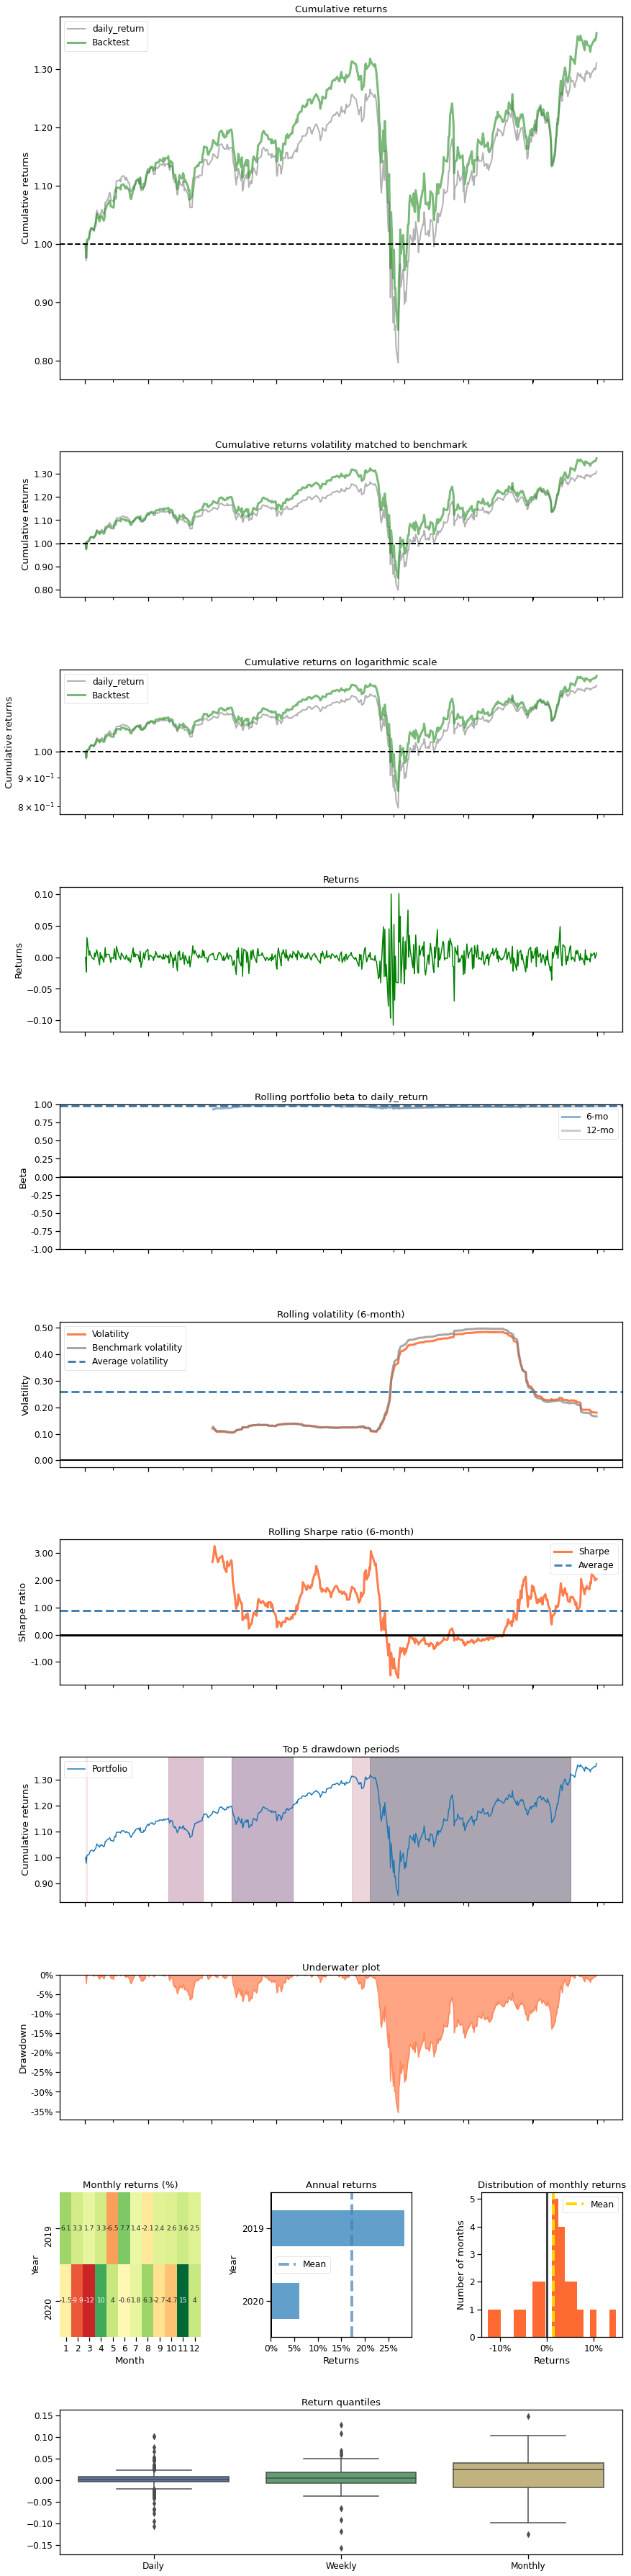

In [ ]:
import pyfolio
%matplotlib inline

baseline_df = get_baseline(
        ticker='^DJI', start='2019-01-01', end='2021-01-01'
    )

baseline_returns = get_daily_return(baseline_df, value_col_name="close")

with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat,
                                       benchmark_rets=baseline_returns, set_context=False)

## Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading Using Ensemble Strategy

Tutorials to use OpenAI DRL to trade multiple stocks using ensemble strategy in one Jupyter Notebook | Presented at ICAIF 2020

* This notebook is the reimplementation of our paper: Deep Reinforcement Learning for Automated Stock Trading: An Ensemble Strategy, using FinRL.
* Check out medium blog for detailed explanations: https://medium.com/@ai4finance/deep-reinforcement-learning-for-automated-stock-trading-f1dad0126a02
* Please report any issues to our Github: https://github.com/AI4Finance-LLC/FinRL-Library/issues
* **Pytorch Version** 



### Part 1. Problem Definition

This problem is to design an automated trading solution for single stock trading. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use
an action space {−k, ..., −1, 0, 1, ..., k}, where k denotes the number of shares. For example, "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: Dow 30 consituents


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


### Part 2. Getting Started- Load Python Packages

### 2.1. Install all the packages through FinRL library


In [ ]:
# ## install finrl library
# !pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git


### 2.2. Check if the additional packages needed are present, if not install them. 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

### 2.3. Import Packages

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.config import config
from finrl.marketdata.yahoodownloader import YahooDownloader
from finrl.preprocessing.preprocessors import FeatureEngineer
from finrl.preprocessing.data import data_split
from finrl.env.env_stocktrading import StockTradingEnv
from finrl.model.models import DRLAgent,DRLEnsembleAgent
from finrl.trade.backtest import BackTestStats, BaselineStats, BackTestPlot

from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

### 2.4. Create Folders

In [ ]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

### Part 3. Download Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).




-----
class YahooDownloader:
    Provides methods for retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()
        Fetches data from yahoo API


In [ ]:
# from config.py start_date is a string
config.START_DATE

'2000-01-01'

In [ ]:
print(config.SRI_KEHATI_TICKER)

['AALI.JK', 'ADHI.JK', 'ASII.JK', 'BBCA.JK', 'BBNI.JK', 'BBRI.JK', 'BBTN.JK', 'BMRI.JK', 'BSDE.JK', 'INDF.JK', 'JPFA.JK', 'JSMR.JK', 'KLBF.JK', 'PGAS.JK', 'PJAA.JK', 'PPRO.JK', 'SIDO.JK', 'SMGR.JK', 'TINS.JK', 'TLKM.JK', 'UNTR.JK', 'UNVR.JK', 'WIKA.JK', 'WSKT.JK', 'WTON.JK']


In [ ]:
df = YahooDownloader(start_date = config.START_DATE,
                     end_date = '2021-01-19',
                     ticker_list = config.SRI_KEHATI_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [ ]:
df.head()

date        open        high         low       close     volume  \
0  2000-09-05  455.351990  455.351990  441.553986  266.565033  3712344.0   
1  2000-09-06  441.553986  464.552002  436.954010  269.284821  6793100.0   
2  2000-09-07  450.752991  459.951996  446.153015  269.284821  5011393.0   
3  2000-09-08  450.752991  455.351990  446.153015  266.565033  2277955.0   
4  2000-09-11  441.553986  441.553986  427.755005  255.684875   978363.0   

       tic  day  
0  UNTR.JK    1  
1  UNTR.JK    2  
2  UNTR.JK    3  
3  UNTR.JK    4  
4  UNTR.JK    0

In [ ]:
df.tail()

date     open     high      low    close       volume      tic  \
92689  2021-01-18  26300.0  26850.0  25950.0  26700.0    4282500.0  UNTR.JK   
92690  2021-01-18   6950.0   7525.0   6900.0   7500.0   44943900.0  UNVR.JK   
92691  2021-01-18   2410.0   2450.0   2220.0   2250.0  234257600.0  WIKA.JK   
92692  2021-01-18   1960.0   2080.0   1905.0   1920.0  727533400.0  WSKT.JK   
92693  2021-01-18    430.0    525.0    430.0    450.0  418011900.0  WTON.JK   

       day  
92689    0  
92690    0  
92691    0  
92692    0  
92693    0

In [ ]:
df.shape

(92694, 8)

In [ ]:
df.sort_values(['date','tic']).head()

date        open        high         low       close     volume  \
0  2000-09-05  455.351990  455.351990  441.553986  266.565033  3712344.0   
1  2000-09-06  441.553986  464.552002  436.954010  269.284821  6793100.0   
2  2000-09-07  450.752991  459.951996  446.153015  269.284821  5011393.0   
3  2000-09-08  450.752991  455.351990  446.153015  266.565033  2277955.0   
4  2000-09-11  441.553986  441.553986  427.755005  255.684875   978363.0   

       tic  day  
0  UNTR.JK    1  
1  UNTR.JK    2  
2  UNTR.JK    3  
3  UNTR.JK    4  
4  UNTR.JK    0

### Part 4: Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
* Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: MACD and RSI.
* Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

In [ ]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = config.TECHNICAL_INDICATORS_LIST,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)

Successfully added technical indicators
Successfully added turbulence index


In [ ]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)

In [ ]:
processed_full.sample(5)

date      tic         open         high         low  \
162406  2018-06-19  BMRI.JK  6950.000000  6950.000000  6950.00000   
48915   2006-01-13  SMGR.JK  1980.000000  2010.000000  1980.00000   
36453   2004-09-02  JPFA.JK    39.000000    39.000000    34.00000   
85244   2010-01-05  BBTN.JK   807.497986   817.111023   797.88501   
122724  2014-02-12  PPRO.JK     0.000000     0.000000     0.00000   

              close      volume  day       macd       boll_ub       boll_lb  \
162406  6408.632812         0.0  1.0 -73.885197   5749.483119   5065.588414   
48915    920.721130   2165000.0  4.0  -0.464230    317.536346    253.201218   
36453     15.950438         0.0  3.0  62.406856   1438.484387   1071.852808   
85244    654.591553  39935197.0  1.0 -93.445048  12551.882930  11932.725078   
122724     0.000000         0.0  0.0   0.000000      0.000000      0.000000   

           rsi_30      cci_30      dx_30  close_30_sma  close_60_sma  \
162406  45.006104  -15.139464   6.759148   5536.032666   5844.029118   
48915   54.011935    3.365310   7.897184    287.093089    276.979535   
36453   61.834484  136.335470  47.312038   1219.007263   1153.802943   
85244   45.776714  -63.198131   5.239607  12302.148307  12496.153890   
122724   0.000000    0.000000   0.000000      0.000000      0.000000   

        turbulence  
162406    0.088732  
48915    10.552925  
36453     1.176868  
85244     6.265504  
122724    0.000000

### 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

In [ ]:
config.TECHNICAL_INDICATORS_LIST

['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

In [ ]:
stock_dimension = len(processed_full.tic.unique())
state_space = 1 + 2*stock_dimension + len(config.TECHNICAL_INDICATORS_LIST)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 25, State Space: 251


In [ ]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 50_000_000/100, #Since in Indonesia the minimum number of shares per trx is 100, then we scaled the initial amount by dividing it with 100 
    "buy_cost_pct": 0.0019, #IPOT has 0.19% buy cost
    "sell_cost_pct": 0.0029, #IPOT has 0.29% sell cost
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": config.TECHNICAL_INDICATORS_LIST, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4,
    "print_verbosity":5
    
}

### 6: Implement DRL Algorithms
* The implementation of the DRL algorithms are based on **OpenAI Baselines** and **Stable Baselines**. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

* In this notebook, we are training and validating 3 agents (A2C, PPO, DDPG) using Rolling-window Ensemble Method ([reference code](https://github.com/AI4Finance-LLC/Deep-Reinforcement-Learning-for-Automated-Stock-Trading-Ensemble-Strategy-ICAIF-2020/blob/80415db8fa7b2179df6bd7e81ce4fe8dbf913806/model/models.py#L92))

In [ ]:
rebalance_window = 63 # rebalance_window is the number of days to retrain the model
validation_window = 63 # validation_window is the number of days to do validation and trading (e.g. if validation_window=63, then both validation and trading period will be 63 days)
train_start = '2000-01-01'
train_end = '2019-01-01'
val_test_start = '2019-01-01'
val_test_end = '2021-01-18'

ensemble_agent = DRLEnsembleAgent(df=processed_full,
                 train_period=(train_start,train_end),
                 val_test_period=(val_test_start,val_test_end),
                 rebalance_window=rebalance_window, 
                 validation_window=validation_window, 
                 **env_kwargs)

In [ ]:
A2C_model_kwargs = {
                    'n_steps': 5,
                    'ent_coef': 0.01,
                    'learning_rate': 0.0005
                    }

PPO_model_kwargs = {
                    "ent_coef":0.01,
                    "n_steps": 2048,
                    "learning_rate": 0.00025,
                    "batch_size": 128
                    }

DDPG_model_kwargs = {
                      "action_noise":"ornstein_uhlenbeck",
                      "buffer_size": 50_000,
                      "learning_rate": 0.000005,
                      "batch_size": 128
                    }

timesteps_dict = {'a2c' : 100_000, 
                 'ppo' : 100_000, 
                 'ddpg' : 50_000
                 }

In [ ]:
df_summary = ensemble_agent.run_ensemble_strategy(A2C_model_kwargs,
                                                 PPO_model_kwargs,
                                                 DDPG_model_kwargs,
                                                 timesteps_dict)

============Start Ensemble Strategy============
nan
turbulence_threshold:  5625265.115256409
======Model training from:  2000-01-01 to  2019-01-02
======A2C Training========
{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0005}
Using cpu device
Logging to tensorboard_log/a2c/a2c_126_1
------------------------------------
| time/                 |          |
|    fps                | 99       |
|    iterations         | 100      |
|    time_elapsed       | 5        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -35.6    |
|    explained_variance | 0.229    |
|    learning_rate      | 0.0005   |
|    n_updates          | 99       |
|    policy_loss        | -77      |
|    std                | 1        |
|    value_loss         | 4.79     |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 99        |
|    iterations         | 200       |
|  

------------------------------------
| time/                 |          |
|    fps                | 99       |
|    iterations         | 1500     |
|    time_elapsed       | 75       |
|    total_timesteps    | 7500     |
| train/                |          |
|    entropy_loss       | -35.6    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0005   |
|    n_updates          | 1499     |
|    policy_loss        | -176     |
|    std                | 1        |
|    value_loss         | 33.1     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 99       |
|    iterations         | 1600     |
|    time_elapsed       | 80       |
|    total_timesteps    | 8000     |
| train/                |          |
|    entropy_loss       | -35.6    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 1599     |
|    policy_loss        | -24.8    |
|

------------------------------------
| time/                 |          |
|    fps                | 99       |
|    iterations         | 2900     |
|    time_elapsed       | 145      |
|    total_timesteps    | 14500    |
| train/                |          |
|    entropy_loss       | -35.7    |
|    explained_variance | -0.17    |
|    learning_rate      | 0.0005   |
|    n_updates          | 2899     |
|    policy_loss        | -32.9    |
|    std                | 1.01     |
|    value_loss         | 1.59     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 99       |
|    iterations         | 3000     |
|    time_elapsed       | 150      |
|    total_timesteps    | 15000    |
| train/                |          |
|    entropy_loss       | -35.7    |
|    explained_variance | -0.412   |
|    learning_rate      | 0.0005   |
|    n_updates          | 2999     |
|    policy_loss        | -112     |
|

-------------------------------------
| time/                 |           |
|    fps                | 99        |
|    iterations         | 4400      |
|    time_elapsed       | 221       |
|    total_timesteps    | 22000     |
| train/                |           |
|    entropy_loss       | -35.8     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0005    |
|    n_updates          | 4399      |
|    policy_loss        | -2.06e+03 |
|    std                | 1.01      |
|    value_loss         | 3.85e+03  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 99       |
|    iterations         | 4500     |
|    time_elapsed       | 226      |
|    total_timesteps    | 22500    |
| train/                |          |
|    entropy_loss       | -35.8    |
|    explained_variance | -0.00306 |
|    learning_rate      | 0.0005   |
|    n_updates          | 4499     |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 99       |
|    iterations         | 5800     |
|    time_elapsed       | 291      |
|    total_timesteps    | 29000    |
| train/                |          |
|    entropy_loss       | -35.8    |
|    explained_variance | 0.00796  |
|    learning_rate      | 0.0005   |
|    n_updates          | 5799     |
|    policy_loss        | -945     |
|    std                | 1.01     |
|    value_loss         | 1.04e+03 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 99       |
|    iterations         | 5900     |
|    time_elapsed       | 296      |
|    total_timesteps    | 29500    |
| train/                |          |
|    entropy_loss       | -35.8    |
|    explained_variance | -0.00384 |
|    learning_rate      | 0.0005   |
|    n_updates          | 5899     |
|    policy_loss        | 6.92e+03 |
|

------------------------------------
| time/                 |          |
|    fps                | 99       |
|    iterations         | 7300     |
|    time_elapsed       | 367      |
|    total_timesteps    | 36500    |
| train/                |          |
|    entropy_loss       | -35.9    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 7299     |
|    policy_loss        | 3.2e+03  |
|    std                | 1.02     |
|    value_loss         | 1.44e+04 |
------------------------------------
------------------------------------
| environment/          |          |
|    portfolio_value    | 2.96e+07 |
|    total_cost         | 5.61e+05 |
|    total_reward       | 2.91e+07 |
|    total_reward_pct   | 5.82e+03 |
|    total_trades       | 37286    |
| time/                 |          |
|    fps                | 99       |
|    iterations         | 7400     |
|    time_elapsed       | 372      |
|    total_timesteps    | 37000    |
|

-------------------------------------
| time/                 |           |
|    fps                | 99        |
|    iterations         | 8700      |
|    time_elapsed       | 437       |
|    total_timesteps    | 43500     |
| train/                |           |
|    entropy_loss       | -35.8     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0005    |
|    n_updates          | 8699      |
|    policy_loss        | 1.87e+03  |
|    std                | 1.02      |
|    value_loss         | 4.61e+03  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 99       |
|    iterations         | 8800     |
|    time_elapsed       | 442      |
|    total_timesteps    | 44000    |
| train/                |          |
|    entropy_loss       | -35.8    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 8799     |
|    policy_loss       

------------------------------------
| environment/          |          |
|    portfolio_value    | 3.76e+07 |
|    total_cost         | 4.07e+05 |
|    total_reward       | 3.71e+07 |
|    total_reward_pct   | 7.43e+03 |
|    total_trades       | 34596    |
| time/                 |          |
|    fps                | 99       |
|    iterations         | 10100    |
|    time_elapsed       | 508      |
|    total_timesteps    | 50500    |
| train/                |          |
|    entropy_loss       | -35.9    |
|    explained_variance | 0.125    |
|    learning_rate      | 0.0005   |
|    n_updates          | 10099    |
|    policy_loss        | -3.73    |
|    std                | 1.02     |
|    value_loss         | 2.63     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 99       |
|    iterations         | 10200    |
|    time_elapsed       | 513      |
|    total_timesteps    | 51000    |
|

------------------------------------
| time/                 |          |
|    fps                | 99       |
|    iterations         | 11500    |
|    time_elapsed       | 579      |
|    total_timesteps    | 57500    |
| train/                |          |
|    entropy_loss       | -35.9    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 11499    |
|    policy_loss        | 1.3e+03  |
|    std                | 1.02     |
|    value_loss         | 1.86e+03 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 99        |
|    iterations         | 11600     |
|    time_elapsed       | 584       |
|    total_timesteps    | 58000     |
| train/                |           |
|    entropy_loss       | -36       |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0005    |
|    n_updates          | 11599     |
|    policy_loss        | 7

------------------------------------
| time/                 |          |
|    fps                | 99       |
|    iterations         | 13000    |
|    time_elapsed       | 655      |
|    total_timesteps    | 65000    |
| train/                |          |
|    entropy_loss       | -36.1    |
|    explained_variance | -0.314   |
|    learning_rate      | 0.0005   |
|    n_updates          | 12999    |
|    policy_loss        | 282      |
|    std                | 1.03     |
|    value_loss         | 65.8     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 99       |
|    iterations         | 13100    |
|    time_elapsed       | 660      |
|    total_timesteps    | 65500    |
| train/                |          |
|    entropy_loss       | -36.1    |
|    explained_variance | -0.00461 |
|    learning_rate      | 0.0005   |
|    n_updates          | 13099    |
|    policy_loss        | 169      |
|

-------------------------------------
| time/                 |           |
|    fps                | 99        |
|    iterations         | 14400     |
|    time_elapsed       | 725       |
|    total_timesteps    | 72000     |
| train/                |           |
|    entropy_loss       | -36       |
|    explained_variance | -0.000486 |
|    learning_rate      | 0.0005    |
|    n_updates          | 14399     |
|    policy_loss        | -2.47e+03 |
|    std                | 1.02      |
|    value_loss         | 4.58e+03  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 99       |
|    iterations         | 14500    |
|    time_elapsed       | 730      |
|    total_timesteps    | 72500    |
| train/                |          |
|    entropy_loss       | -36      |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 14499    |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 99       |
|    iterations         | 15800    |
|    time_elapsed       | 796      |
|    total_timesteps    | 79000    |
| train/                |          |
|    entropy_loss       | -36      |
|    explained_variance | 0.126    |
|    learning_rate      | 0.0005   |
|    n_updates          | 15799    |
|    policy_loss        | -183     |
|    std                | 1.03     |
|    value_loss         | 24.8     |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 99        |
|    iterations         | 15900     |
|    time_elapsed       | 801       |
|    total_timesteps    | 79500     |
| train/                |           |
|    entropy_loss       | -36.1     |
|    explained_variance | 0.00854   |
|    learning_rate      | 0.0005    |
|    n_updates          | 15899     |
|    policy_loss        | -

------------------------------------
| time/                 |          |
|    fps                | 99       |
|    iterations         | 17300    |
|    time_elapsed       | 872      |
|    total_timesteps    | 86500    |
| train/                |          |
|    entropy_loss       | -36      |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 17299    |
|    policy_loss        | 1.28e+03 |
|    std                | 1.03     |
|    value_loss         | 1.23e+03 |
------------------------------------
------------------------------------
| environment/          |          |
|    portfolio_value    | 2.02e+07 |
|    total_cost         | 2.67e+05 |
|    total_reward       | 1.97e+07 |
|    total_reward_pct   | 3.93e+03 |
|    total_trades       | 31457    |
| time/                 |          |
|    fps                | 99       |
|    iterations         | 17400    |
|    time_elapsed       | 877      |
|    total_timesteps    | 87000    |
|

------------------------------------
| time/                 |          |
|    fps                | 99       |
|    iterations         | 18700    |
|    time_elapsed       | 942      |
|    total_timesteps    | 93500    |
| train/                |          |
|    entropy_loss       | -36      |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 18699    |
|    policy_loss        | -947     |
|    std                | 1.03     |
|    value_loss         | 3.23e+03 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 99       |
|    iterations         | 18800    |
|    time_elapsed       | 947      |
|    total_timesteps    | 94000    |
| train/                |          |
|    entropy_loss       | -36.1    |
|    explained_variance | -0.465   |
|    learning_rate      | 0.0005   |
|    n_updates          | 18799    |
|    policy_loss        | 109      |
|

-----------------------------
| time/              |      |
|    fps             | 108  |
|    iterations      | 1    |
|    time_elapsed    | 18   |
|    total_timesteps | 2048 |
-----------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 106        |
|    iterations           | 2          |
|    time_elapsed         | 38         |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.01813078 |
|    clip_fraction        | 0.174      |
|    clip_range           | 0.2        |
|    entropy_loss         | -35.5      |
|    explained_variance   | 0.00997    |
|    learning_rate        | 0.00025    |
|    loss                 | 18.3       |
|    n_updates            | 10         |
|    policy_gradient_loss | -0.0288    |
|    std                  | 1          |
|    value_loss           | 57.5       |
----------------------------------------
-----------

-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 11          |
|    time_elapsed         | 215         |
|    total_timesteps      | 22528       |
| train/                  |             |
|    approx_kl            | 0.017748863 |
|    clip_fraction        | 0.147       |
|    clip_range           | 0.2         |
|    entropy_loss         | -35.7       |
|    explained_variance   | 0.112       |
|    learning_rate        | 0.00025     |
|    loss                 | 26.5        |
|    n_updates            | 100         |
|    policy_gradient_loss | -0.0171     |
|    std                  | 1.01        |
|    value_loss           | 94.7        |
-----------------------------------------
-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.54e+05    |
|    total_cost           | 6.19e+06    |
|    total_reward         | -2.46e

-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 20          |
|    time_elapsed         | 391         |
|    total_timesteps      | 40960       |
| train/                  |             |
|    approx_kl            | 0.020654386 |
|    clip_fraction        | 0.181       |
|    clip_range           | 0.2         |
|    entropy_loss         | -35.9       |
|    explained_variance   | 0.0661      |
|    learning_rate        | 0.00025     |
|    loss                 | 113         |
|    n_updates            | 190         |
|    policy_gradient_loss | -0.0158     |
|    std                  | 1.02        |
|    value_loss           | 192         |
-----------------------------------------
-----------------------------------------
| environment/            |             |
|    portfolio_value      | -5.43e+05   |
|    total_cost           | 1.42e+06    |
|    total_reward         | -1.04e

day: 4572, episode: 35
begin_total_asset: 500000.00
end_total_asset: 1584231.99
total_reward: 1084231.99
total_cost: 7989926.55
total_trades: 61014
Sharpe: 0.343
-----------------------------------------
| environment/            |             |
|    portfolio_value      | 1.58e+06    |
|    total_cost           | 7.99e+06    |
|    total_reward         | 1.08e+06    |
|    total_reward_pct     | 217         |
|    total_trades         | 61014       |
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 30          |
|    time_elapsed         | 588         |
|    total_timesteps      | 61440       |
| train/                  |             |
|    approx_kl            | 0.013875287 |
|    clip_fraction        | 0.192       |
|    clip_range           | 0.2         |
|    entropy_loss         | -36.2       |
|    explained_variance   | 0.15        |
|    learning_rate        | 0.00025     |
|    loss                 | 75.6        

-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 39          |
|    time_elapsed         | 765         |
|    total_timesteps      | 79872       |
| train/                  |             |
|    approx_kl            | 0.008213143 |
|    clip_fraction        | 0.0603      |
|    clip_range           | 0.2         |
|    entropy_loss         | -36.4       |
|    explained_variance   | 0.0168      |
|    learning_rate        | 0.00025     |
|    loss                 | 1.54e+04    |
|    n_updates            | 380         |
|    policy_gradient_loss | -0.00277    |
|    std                  | 1.04        |
|    value_loss           | 1.05e+04    |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 40          |
|    time_elapsed         | 784   

----------------------------------------
| time/                   |            |
|    fps                  | 104        |
|    iterations           | 48         |
|    time_elapsed         | 942        |
|    total_timesteps      | 98304      |
| train/                  |            |
|    approx_kl            | 0.02686143 |
|    clip_fraction        | 0.164      |
|    clip_range           | 0.2        |
|    entropy_loss         | -36.6      |
|    explained_variance   | 0.156      |
|    learning_rate        | 0.00025    |
|    loss                 | 247        |
|    n_updates            | 470        |
|    policy_gradient_loss | -0.00648   |
|    std                  | 1.05       |
|    value_loss           | 440        |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 49          |
|    time_elapsed         | 961         |
|    total_

------------------------------------
| time/                 |          |
|    fps                | 98       |
|    iterations         | 500      |
|    time_elapsed       | 25       |
|    total_timesteps    | 2500     |
| train/                |          |
|    entropy_loss       | -35.7    |
|    explained_variance | 0.0972   |
|    learning_rate      | 0.0005   |
|    n_updates          | 499      |
|    policy_loss        | 132      |
|    std                | 1.01     |
|    value_loss         | 186      |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 97        |
|    iterations         | 600       |
|    time_elapsed       | 30        |
|    total_timesteps    | 3000      |
| train/                |           |
|    entropy_loss       | -35.6     |
|    explained_variance | -0.0793   |
|    learning_rate      | 0.0005    |
|    n_updates          | 599       |
|    policy_loss        | -

------------------------------------
| time/                 |          |
|    fps                | 98       |
|    iterations         | 2000     |
|    time_elapsed       | 101      |
|    total_timesteps    | 10000    |
| train/                |          |
|    entropy_loss       | -35.6    |
|    explained_variance | -0.548   |
|    learning_rate      | 0.0005   |
|    n_updates          | 1999     |
|    policy_loss        | -39.5    |
|    std                | 1.01     |
|    value_loss         | 3.64     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 98       |
|    iterations         | 2100     |
|    time_elapsed       | 107      |
|    total_timesteps    | 10500    |
| train/                |          |
|    entropy_loss       | -35.6    |
|    explained_variance | -0.00373 |
|    learning_rate      | 0.0005   |
|    n_updates          | 2099     |
|    policy_loss        | 74.7     |
|

------------------------------------
| time/                 |          |
|    fps                | 98       |
|    iterations         | 3500     |
|    time_elapsed       | 178      |
|    total_timesteps    | 17500    |
| train/                |          |
|    entropy_loss       | -35.5    |
|    explained_variance | 0.00146  |
|    learning_rate      | 0.0005   |
|    n_updates          | 3499     |
|    policy_loss        | -80.1    |
|    std                | 1        |
|    value_loss         | 238      |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 98       |
|    iterations         | 3600     |
|    time_elapsed       | 183      |
|    total_timesteps    | 18000    |
| train/                |          |
|    entropy_loss       | -35.5    |
|    explained_variance | 0.00493  |
|    learning_rate      | 0.0005   |
|    n_updates          | 3599     |
|    policy_loss        | 260      |
|

------------------------------------
| time/                 |          |
|    fps                | 98       |
|    iterations         | 4900     |
|    time_elapsed       | 249      |
|    total_timesteps    | 24500    |
| train/                |          |
|    entropy_loss       | -35.5    |
|    explained_variance | 0.0877   |
|    learning_rate      | 0.0005   |
|    n_updates          | 4899     |
|    policy_loss        | -201     |
|    std                | 1        |
|    value_loss         | 43.6     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 98       |
|    iterations         | 5000     |
|    time_elapsed       | 254      |
|    total_timesteps    | 25000    |
| train/                |          |
|    entropy_loss       | -35.5    |
|    explained_variance | 2.44e-06 |
|    learning_rate      | 0.0005   |
|    n_updates          | 4999     |
|    policy_loss        | 958      |
|

------------------------------------
| time/                 |          |
|    fps                | 98       |
|    iterations         | 6400     |
|    time_elapsed       | 325      |
|    total_timesteps    | 32000    |
| train/                |          |
|    entropy_loss       | -35.6    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 6399     |
|    policy_loss        | -19.6    |
|    std                | 1        |
|    value_loss         | 0.405    |
------------------------------------
------------------------------------
| environment/          |          |
|    portfolio_value    | 6.66e+07 |
|    total_cost         | 1.53e+05 |
|    total_reward       | 6.61e+07 |
|    total_reward_pct   | 1.32e+04 |
|    total_trades       | 41479    |
| time/                 |          |
|    fps                | 98       |
|    iterations         | 6500     |
|    time_elapsed       | 330      |
|    total_timesteps    | 32500    |
|

------------------------------------
| time/                 |          |
|    fps                | 98       |
|    iterations         | 7800     |
|    time_elapsed       | 397      |
|    total_timesteps    | 39000    |
| train/                |          |
|    entropy_loss       | -35.6    |
|    explained_variance | -0.00769 |
|    learning_rate      | 0.0005   |
|    n_updates          | 7799     |
|    policy_loss        | 3e+03    |
|    std                | 1        |
|    value_loss         | 1.09e+04 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 98        |
|    iterations         | 7900      |
|    time_elapsed       | 402       |
|    total_timesteps    | 39500     |
| train/                |           |
|    entropy_loss       | -35.6     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0005    |
|    n_updates          | 7899      |
|    policy_loss        | -

day: 4635, episode: 10
begin_total_asset: 500000.00
end_total_asset: -7373126.51
total_reward: -7873126.51
total_cost: 475706.10
total_trades: 45224
Sharpe: -0.233
-------------------------------------
| environment/          |           |
|    portfolio_value    | -7.37e+06 |
|    total_cost         | 4.76e+05  |
|    total_reward       | -7.87e+06 |
|    total_reward_pct   | -1.57e+03 |
|    total_trades       | 45224     |
| time/                 |           |
|    fps                | 98        |
|    iterations         | 9300      |
|    time_elapsed       | 473       |
|    total_timesteps    | 46500     |
| train/                |           |
|    entropy_loss       | -35.6     |
|    explained_variance | 0         |
|    learning_rate      | 0.0005    |
|    n_updates          | 9299      |
|    policy_loss        | -88.2     |
|    std                | 1.01      |
|    value_loss         | 9.36      |
-------------------------------------
-------------------------------------


------------------------------------
| time/                 |          |
|    fps                | 98       |
|    iterations         | 10700    |
|    time_elapsed       | 545      |
|    total_timesteps    | 53500    |
| train/                |          |
|    entropy_loss       | -35.7    |
|    explained_variance | 0.000498 |
|    learning_rate      | 0.0005   |
|    n_updates          | 10699    |
|    policy_loss        | 1.06e+03 |
|    std                | 1.01     |
|    value_loss         | 1.23e+03 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 98       |
|    iterations         | 10800    |
|    time_elapsed       | 550      |
|    total_timesteps    | 54000    |
| train/                |          |
|    entropy_loss       | -35.6    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 10799    |
|    policy_loss        | 1.59e+03 |
|

------------------------------------
| time/                 |          |
|    fps                | 98       |
|    iterations         | 12200    |
|    time_elapsed       | 621      |
|    total_timesteps    | 61000    |
| train/                |          |
|    entropy_loss       | -35.6    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 12199    |
|    policy_loss        | -224     |
|    std                | 1.01     |
|    value_loss         | 45.6     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 98       |
|    iterations         | 12300    |
|    time_elapsed       | 626      |
|    total_timesteps    | 61500    |
| train/                |          |
|    entropy_loss       | -35.5    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 12299    |
|    policy_loss        | -64.1    |
|

------------------------------------
| time/                 |          |
|    fps                | 98       |
|    iterations         | 13700    |
|    time_elapsed       | 698      |
|    total_timesteps    | 68500    |
| train/                |          |
|    entropy_loss       | -35.5    |
|    explained_variance | 0.00115  |
|    learning_rate      | 0.0005   |
|    n_updates          | 13699    |
|    policy_loss        | -148     |
|    std                | 1        |
|    value_loss         | 128      |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 98       |
|    iterations         | 13800    |
|    time_elapsed       | 703      |
|    total_timesteps    | 69000    |
| train/                |          |
|    entropy_loss       | -35.5    |
|    explained_variance | 0.00258  |
|    learning_rate      | 0.0005   |
|    n_updates          | 13799    |
|    policy_loss        | -192     |
|

------------------------------------
| time/                 |          |
|    fps                | 98       |
|    iterations         | 15100    |
|    time_elapsed       | 769      |
|    total_timesteps    | 75500    |
| train/                |          |
|    entropy_loss       | -35.6    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 15099    |
|    policy_loss        | 170      |
|    std                | 1.01     |
|    value_loss         | 34       |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 98       |
|    iterations         | 15200    |
|    time_elapsed       | 774      |
|    total_timesteps    | 76000    |
| train/                |          |
|    entropy_loss       | -35.6    |
|    explained_variance | -0.00881 |
|    learning_rate      | 0.0005   |
|    n_updates          | 15199    |
|    policy_loss        | 1.45e+03 |
|

-------------------------------------
| time/                 |           |
|    fps                | 98        |
|    iterations         | 16600     |
|    time_elapsed       | 846       |
|    total_timesteps    | 83000     |
| train/                |           |
|    entropy_loss       | -35.6     |
|    explained_variance | -0.000384 |
|    learning_rate      | 0.0005    |
|    n_updates          | 16599     |
|    policy_loss        | -38.9     |
|    std                | 1.01      |
|    value_loss         | 325       |
-------------------------------------
-------------------------------------
| environment/          |           |
|    portfolio_value    | -3.14e+06 |
|    total_cost         | 6.12e+04  |
|    total_reward       | -3.64e+06 |
|    total_reward_pct   | -728      |
|    total_trades       | 52448     |
| time/                 |           |
|    fps                | 98        |
|    iterations         | 16700     |
|    time_elapsed       | 851       |
|    total_t

------------------------------------
| time/                 |          |
|    fps                | 98       |
|    iterations         | 18000    |
|    time_elapsed       | 918      |
|    total_timesteps    | 90000    |
| train/                |          |
|    entropy_loss       | -35.6    |
|    explained_variance | 0.000417 |
|    learning_rate      | 0.0005   |
|    n_updates          | 17999    |
|    policy_loss        | 2.47e+03 |
|    std                | 1        |
|    value_loss         | 6.37e+03 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 98        |
|    iterations         | 18100     |
|    time_elapsed       | 923       |
|    total_timesteps    | 90500     |
| train/                |           |
|    entropy_loss       | -35.5     |
|    explained_variance | 2.98e-07  |
|    learning_rate      | 0.0005    |
|    n_updates          | 18099     |
|    policy_loss        | -

------------------------------------
| time/                 |          |
|    fps                | 98       |
|    iterations         | 19400    |
|    time_elapsed       | 989      |
|    total_timesteps    | 97000    |
| train/                |          |
|    entropy_loss       | -35.5    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 19399    |
|    policy_loss        | 1.23e+03 |
|    std                | 1        |
|    value_loss         | 1.25e+04 |
------------------------------------
------------------------------------
| environment/          |          |
|    portfolio_value    | 1.24e+08 |
|    total_cost         | 1.3e+05  |
|    total_reward       | 1.24e+08 |
|    total_reward_pct   | 2.48e+04 |
|    total_trades       | 53609    |
| time/                 |          |
|    fps                | 98       |
|    iterations         | 19500    |
|    time_elapsed       | 994      |
|    total_timesteps    | 97500    |
|

----------------------------------------
| time/                   |            |
|    fps                  | 103        |
|    iterations           | 6          |
|    time_elapsed         | 118        |
|    total_timesteps      | 12288      |
| train/                  |            |
|    approx_kl            | 0.02122763 |
|    clip_fraction        | 0.261      |
|    clip_range           | 0.2        |
|    entropy_loss         | -35.7      |
|    explained_variance   | 0.248      |
|    learning_rate        | 0.00025    |
|    loss                 | 10.6       |
|    n_updates            | 50         |
|    policy_gradient_loss | -0.0248    |
|    std                  | 1.01       |
|    value_loss           | 28.2       |
----------------------------------------
day: 4635, episode: 25
begin_total_asset: 500000.00
end_total_asset: 249092.39
total_reward: -250907.61
total_cost: 6161972.75
total_trades: 59136
Sharpe: 0.227
-----------------------------------------
| environment/    

-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 15          |
|    time_elapsed         | 297         |
|    total_timesteps      | 30720       |
| train/                  |             |
|    approx_kl            | 0.006823021 |
|    clip_fraction        | 0.187       |
|    clip_range           | 0.2         |
|    entropy_loss         | -36.2       |
|    explained_variance   | 0.185       |
|    learning_rate        | 0.00025     |
|    loss                 | 138         |
|    n_updates            | 140         |
|    policy_gradient_loss | -0.0174     |
|    std                  | 1.03        |
|    value_loss           | 227         |
-----------------------------------------
-----------------------------------------
| environment/            |             |
|    portfolio_value      | 1.83e+07    |
|    total_cost           | 1.65e+07    |
|    total_reward         | 1.78e+

------------------------------------------
| time/                   |              |
|    fps                  | 103          |
|    iterations           | 24           |
|    time_elapsed         | 476          |
|    total_timesteps      | 49152        |
| train/                  |              |
|    approx_kl            | 0.0038075643 |
|    clip_fraction        | 0.0688       |
|    clip_range           | 0.2          |
|    entropy_loss         | -36.3        |
|    explained_variance   | 0.0478       |
|    learning_rate        | 0.00025      |
|    loss                 | 2.94e+03     |
|    n_updates            | 230          |
|    policy_gradient_loss | -0.0123      |
|    std                  | 1.03         |
|    value_loss           | 5.81e+03     |
------------------------------------------
-----------------------------------------
| environment/            |             |
|    portfolio_value      | 1.31e+07    |
|    total_cost           | 2.4e+07     |
|    total_rewa

----------------------------------------
| time/                   |            |
|    fps                  | 103        |
|    iterations           | 33         |
|    time_elapsed         | 655        |
|    total_timesteps      | 67584      |
| train/                  |            |
|    approx_kl            | 0.03435031 |
|    clip_fraction        | 0.21       |
|    clip_range           | 0.2        |
|    entropy_loss         | -36.7      |
|    explained_variance   | 0.365      |
|    learning_rate        | 0.00025    |
|    loss                 | 81.6       |
|    n_updates            | 320        |
|    policy_gradient_loss | -0.0114    |
|    std                  | 1.05       |
|    value_loss           | 132        |
----------------------------------------
-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.43e+07    |
|    total_cost           | 2.05e+07    |
|    total_reward         | 2.38e+07    |
|    total_

-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 42          |
|    time_elapsed         | 834         |
|    total_timesteps      | 86016       |
| train/                  |             |
|    approx_kl            | 0.010648734 |
|    clip_fraction        | 0.0353      |
|    clip_range           | 0.2         |
|    entropy_loss         | -36.9       |
|    explained_variance   | 0.0016      |
|    learning_rate        | 0.00025     |
|    loss                 | 6.78e+04    |
|    n_updates            | 410         |
|    policy_gradient_loss | -0.00285    |
|    std                  | 1.06        |
|    value_loss           | 1.44e+05    |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 43          |
|    time_elapsed         | 854   

day: 4635, episode: 50
begin_total_asset: 500000.00
end_total_asset: 50874364.54
total_reward: 50374364.54
total_cost: 1184.51
total_trades: 45414
Sharpe: 0.330
----------------------------------
| environment/        |          |
|    portfolio_value  | 5.45e+07 |
|    total_cost       | 3.05e+03 |
|    total_reward     | 5.4e+07  |
|    total_reward_pct | 1.08e+04 |
|    total_trades     | 46657    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 53       |
|    time_elapsed     | 694      |
|    total timesteps  | 37088    |
| train/              |          |
|    actor_loss       | 15.8     |
|    critic_loss      | 3.06e+03 |
|    learning_rate    | 5e-06    |
|    n_updates        | 32452    |
----------------------------------
day: 4635, episode: 55
begin_total_asset: 500000.00
end_total_asset: 53110018.05
total_reward: 52610018.05
total_cost: 1289.64
total_trades: 44705
Sharpe: 0.320
======DDPG Validation from:  2019-04-01 to  2019

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 8.77e+04    |
|    total_cost           | 3.7e+06     |
|    total_reward         | -4.12e+05   |
|    total_reward_pct     | -82.5       |
|    total_trades         | 58389       |
| time/                   |             |
|    fps                  | 102         |
|    iterations           | 10          |
|    time_elapsed         | 199         |
|    total_timesteps      | 20480       |
| train/                  |             |
|    approx_kl            | 0.021699026 |
|    clip_fraction        | 0.267       |
|    clip_range           | 0.2         |
|    entropy_loss         | -35.7       |
|    explained_variance   | 0.227       |
|    learning_rate        | 0.00025     |
|    loss                 | 5.88        |
|    n_updates            | 90          |
|    policy_gradient_loss | -0.00444    |
|    std                  | 1.01        |
|    value_loss           | 19.2  

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 1e+05       |
|    total_cost           | 4.37e+06    |
|    total_reward         | -4e+05      |
|    total_reward_pct     | -80         |
|    total_trades         | 59096       |
| time/                   |             |
|    fps                  | 102         |
|    iterations           | 19          |
|    time_elapsed         | 380         |
|    total_timesteps      | 38912       |
| train/                  |             |
|    approx_kl            | 0.020075489 |
|    clip_fraction        | 0.129       |
|    clip_range           | 0.2         |
|    entropy_loss         | -35.9       |
|    explained_variance   | 0.162       |
|    learning_rate        | 0.00025     |
|    loss                 | 25          |
|    n_updates            | 180         |
|    policy_gradient_loss | -0.01       |
|    std                  | 1.02        |
|    value_loss           | 55.4  

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.27e+04    |
|    total_cost           | 2.11e+06    |
|    total_reward         | -4.77e+05   |
|    total_reward_pct     | -95.5       |
|    total_trades         | 55905       |
| time/                   |             |
|    fps                  | 102         |
|    iterations           | 28          |
|    time_elapsed         | 561         |
|    total_timesteps      | 57344       |
| train/                  |             |
|    approx_kl            | 0.030743849 |
|    clip_fraction        | 0.291       |
|    clip_range           | 0.2         |
|    entropy_loss         | -36.2       |
|    explained_variance   | 0.309       |
|    learning_rate        | 0.00025     |
|    loss                 | 5.92        |
|    n_updates            | 270         |
|    policy_gradient_loss | -0.0026     |
|    std                  | 1.03        |
|    value_loss           | 14.1  

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.85e+06    |
|    total_cost           | 1.19e+07    |
|    total_reward         | 2.35e+06    |
|    total_reward_pct     | 470         |
|    total_trades         | 66080       |
| time/                   |             |
|    fps                  | 102         |
|    iterations           | 37          |
|    time_elapsed         | 742         |
|    total_timesteps      | 75776       |
| train/                  |             |
|    approx_kl            | 0.020789951 |
|    clip_fraction        | 0.137       |
|    clip_range           | 0.2         |
|    entropy_loss         | -36.6       |
|    explained_variance   | 0.0883      |
|    learning_rate        | 0.00025     |
|    loss                 | 212         |
|    n_updates            | 360         |
|    policy_gradient_loss | -0.0126     |
|    std                  | 1.05        |
|    value_loss           | 668   

day: 4698, episode: 20
begin_total_asset: 500000.00
end_total_asset: 1099259.40
total_reward: 599259.40
total_cost: 10359394.87
total_trades: 64063
Sharpe: 0.494
-----------------------------------------
| environment/            |             |
|    portfolio_value      | 1.1e+06     |
|    total_cost           | 1.04e+07    |
|    total_reward         | 5.99e+05    |
|    total_reward_pct     | 120         |
|    total_trades         | 64063       |
| time/                   |             |
|    fps                  | 102         |
|    iterations           | 46          |
|    time_elapsed         | 922         |
|    total_timesteps      | 94208       |
| train/                  |             |
|    approx_kl            | 0.010646532 |
|    clip_fraction        | 0.106       |
|    clip_range           | 0.2         |
|    entropy_loss         | -36.7       |
|    explained_variance   | 0.0786      |
|    learning_rate        | 0.00025     |
|    loss                 | 289         

------------------------------------
| time/                 |          |
|    fps                | 96       |
|    iterations         | 900      |
|    time_elapsed       | 46       |
|    total_timesteps    | 4500     |
| train/                |          |
|    entropy_loss       | -35.6    |
|    explained_variance | -0.0106  |
|    learning_rate      | 0.0005   |
|    n_updates          | 899      |
|    policy_loss        | 245      |
|    std                | 1        |
|    value_loss         | 55       |
------------------------------------
------------------------------------
| environment/          |          |
|    portfolio_value    | 7.03e+06 |
|    total_cost         | 9.55e+06 |
|    total_reward       | 6.53e+06 |
|    total_reward_pct   | 1.31e+03 |
|    total_trades       | 61821    |
| time/                 |          |
|    fps                | 97       |
|    iterations         | 1000     |
|    time_elapsed       | 51       |
|    total_timesteps    | 5000     |
|

------------------------------------
| time/                 |          |
|    fps                | 97       |
|    iterations         | 2300     |
|    time_elapsed       | 118      |
|    total_timesteps    | 11500    |
| train/                |          |
|    entropy_loss       | -35.6    |
|    explained_variance | -0.0176  |
|    learning_rate      | 0.0005   |
|    n_updates          | 2299     |
|    policy_loss        | 907      |
|    std                | 1        |
|    value_loss         | 1.37e+03 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 97       |
|    iterations         | 2400     |
|    time_elapsed       | 123      |
|    total_timesteps    | 12000    |
| train/                |          |
|    entropy_loss       | -35.5    |
|    explained_variance | 0.00452  |
|    learning_rate      | 0.0005   |
|    n_updates          | 2399     |
|    policy_loss        | -464     |
|

------------------------------------
| environment/          |          |
|    portfolio_value    | 3.74e+07 |
|    total_cost         | 2.08e+06 |
|    total_reward       | 3.69e+07 |
|    total_reward_pct   | 7.39e+03 |
|    total_trades       | 49670    |
| time/                 |          |
|    fps                | 97       |
|    iterations         | 3800     |
|    time_elapsed       | 195      |
|    total_timesteps    | 19000    |
| train/                |          |
|    entropy_loss       | -35.7    |
|    explained_variance | -0.494   |
|    learning_rate      | 0.0005   |
|    n_updates          | 3799     |
|    policy_loss        | -10.1    |
|    std                | 1.01     |
|    value_loss         | 1.64     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 97       |
|    iterations         | 3900     |
|    time_elapsed       | 200      |
|    total_timesteps    | 19500    |
|

------------------------------------
| time/                 |          |
|    fps                | 97       |
|    iterations         | 5200     |
|    time_elapsed       | 267      |
|    total_timesteps    | 26000    |
| train/                |          |
|    entropy_loss       | -35.7    |
|    explained_variance | 0.00482  |
|    learning_rate      | 0.0005   |
|    n_updates          | 5199     |
|    policy_loss        | 326      |
|    std                | 1.01     |
|    value_loss         | 476      |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 97        |
|    iterations         | 5300      |
|    time_elapsed       | 272       |
|    total_timesteps    | 26500     |
| train/                |           |
|    entropy_loss       | -35.7     |
|    explained_variance | -9.18e-05 |
|    learning_rate      | 0.0005    |
|    n_updates          | 5299      |
|    policy_loss        | -

------------------------------------
| time/                 |          |
|    fps                | 97       |
|    iterations         | 6700     |
|    time_elapsed       | 344      |
|    total_timesteps    | 33500    |
| train/                |          |
|    entropy_loss       | -35.8    |
|    explained_variance | -0.733   |
|    learning_rate      | 0.0005   |
|    n_updates          | 6699     |
|    policy_loss        | -21      |
|    std                | 1.01     |
|    value_loss         | 2.29     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 97       |
|    iterations         | 6800     |
|    time_elapsed       | 349      |
|    total_timesteps    | 34000    |
| train/                |          |
|    entropy_loss       | -35.8    |
|    explained_variance | 0.053    |
|    learning_rate      | 0.0005   |
|    n_updates          | 6799     |
|    policy_loss        | -117     |
|

-------------------------------------
| time/                 |           |
|    fps                | 97        |
|    iterations         | 8200      |
|    time_elapsed       | 421       |
|    total_timesteps    | 41000     |
| train/                |           |
|    entropy_loss       | -35.7     |
|    explained_variance | 0         |
|    learning_rate      | 0.0005    |
|    n_updates          | 8199      |
|    policy_loss        | -1.72e+04 |
|    std                | 1.01      |
|    value_loss         | 2.75e+05  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 97        |
|    iterations         | 8300      |
|    time_elapsed       | 426       |
|    total_timesteps    | 41500     |
| train/                |           |
|    entropy_loss       | -35.7     |
|    explained_variance | -0.000222 |
|    learning_rate      | 0.0005    |
|    n_updates          | 8299      |
|    policy_

------------------------------------
| time/                 |          |
|    fps                | 97       |
|    iterations         | 9600     |
|    time_elapsed       | 493      |
|    total_timesteps    | 48000    |
| train/                |          |
|    entropy_loss       | -35.7    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 9599     |
|    policy_loss        | 41.6     |
|    std                | 1.01     |
|    value_loss         | 3.58     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 97       |
|    iterations         | 9700     |
|    time_elapsed       | 498      |
|    total_timesteps    | 48500    |
| train/                |          |
|    entropy_loss       | -35.7    |
|    explained_variance | 0.00212  |
|    learning_rate      | 0.0005   |
|    n_updates          | 9699     |
|    policy_loss        | -257     |
|

-------------------------------------
| time/                 |           |
|    fps                | 97        |
|    iterations         | 11100     |
|    time_elapsed       | 570       |
|    total_timesteps    | 55500     |
| train/                |           |
|    entropy_loss       | -35.6     |
|    explained_variance | 5.01e-05  |
|    learning_rate      | 0.0005    |
|    n_updates          | 11099     |
|    policy_loss        | -2.92e+03 |
|    std                | 1.01      |
|    value_loss         | 1.41e+04  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 97        |
|    iterations         | 11200     |
|    time_elapsed       | 575       |
|    total_timesteps    | 56000     |
| train/                |           |
|    entropy_loss       | -35.6     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0005    |
|    n_updates          | 11199     |
|    policy_

------------------------------------
| time/                 |          |
|    fps                | 97       |
|    iterations         | 12500    |
|    time_elapsed       | 642      |
|    total_timesteps    | 62500    |
| train/                |          |
|    entropy_loss       | -35.7    |
|    explained_variance | 0.0464   |
|    learning_rate      | 0.0005   |
|    n_updates          | 12499    |
|    policy_loss        | -244     |
|    std                | 1.01     |
|    value_loss         | 83.9     |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 97        |
|    iterations         | 12600     |
|    time_elapsed       | 648       |
|    total_timesteps    | 63000     |
| train/                |           |
|    entropy_loss       | -35.7     |
|    explained_variance | 0.0291    |
|    learning_rate      | 0.0005    |
|    n_updates          | 12599     |
|    policy_loss        | -

------------------------------------
| time/                 |          |
|    fps                | 97       |
|    iterations         | 14000    |
|    time_elapsed       | 720      |
|    total_timesteps    | 70000    |
| train/                |          |
|    entropy_loss       | -35.7    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 13999    |
|    policy_loss        | 1.36e+04 |
|    std                | 1.01     |
|    value_loss         | 1.6e+05  |
------------------------------------
day: 4698, episode: 15
begin_total_asset: 500000.00
end_total_asset: 138312706.86
total_reward: 137812706.86
total_cost: 147690.05
total_trades: 52448
Sharpe: 0.235
------------------------------------
| environment/          |          |
|    portfolio_value    | 1.38e+08 |
|    total_cost         | 1.48e+05 |
|    total_reward       | 1.38e+08 |
|    total_reward_pct   | 2.76e+04 |
|    total_trades       | 52448    |
| time/              

------------------------------------
| time/                 |          |
|    fps                | 97       |
|    iterations         | 15400    |
|    time_elapsed       | 793      |
|    total_timesteps    | 77000    |
| train/                |          |
|    entropy_loss       | -35.8    |
|    explained_variance | -0.0122  |
|    learning_rate      | 0.0005   |
|    n_updates          | 15399    |
|    policy_loss        | -342     |
|    std                | 1.02     |
|    value_loss         | 5.48e+03 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 97        |
|    iterations         | 15500     |
|    time_elapsed       | 798       |
|    total_timesteps    | 77500     |
| train/                |           |
|    entropy_loss       | -35.9     |
|    explained_variance | -0.000404 |
|    learning_rate      | 0.0005    |
|    n_updates          | 15499     |
|    policy_loss        | 1

------------------------------------
| time/                 |          |
|    fps                | 97       |
|    iterations         | 16900    |
|    time_elapsed       | 870      |
|    total_timesteps    | 84500    |
| train/                |          |
|    entropy_loss       | -35.9    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0005   |
|    n_updates          | 16899    |
|    policy_loss        | -3.5e+03 |
|    std                | 1.02     |
|    value_loss         | 2.7e+04  |
------------------------------------
------------------------------------
| environment/          |          |
|    portfolio_value    | 6.37e+07 |
|    total_cost         | 1.88e+05 |
|    total_reward       | 6.32e+07 |
|    total_reward_pct   | 1.26e+04 |
|    total_trades       | 48423    |
| time/                 |          |
|    fps                | 97       |
|    iterations         | 17000    |
|    time_elapsed       | 875      |
|    total_timesteps    | 85000    |
|

------------------------------------
| time/                 |          |
|    fps                | 97       |
|    iterations         | 18300    |
|    time_elapsed       | 942      |
|    total_timesteps    | 91500    |
| train/                |          |
|    entropy_loss       | -35.9    |
|    explained_variance | 0.00149  |
|    learning_rate      | 0.0005   |
|    n_updates          | 18299    |
|    policy_loss        | 2.28e+03 |
|    std                | 1.02     |
|    value_loss         | 6.88e+03 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 97        |
|    iterations         | 18400     |
|    time_elapsed       | 948       |
|    total_timesteps    | 92000     |
| train/                |           |
|    entropy_loss       | -35.9     |
|    explained_variance | -0.000308 |
|    learning_rate      | 0.0005    |
|    n_updates          | 18399     |
|    policy_loss        | 3

-------------------------------------
| time/                 |           |
|    fps                | 97        |
|    iterations         | 19700     |
|    time_elapsed       | 1015      |
|    total_timesteps    | 98500     |
| train/                |           |
|    entropy_loss       | -35.9     |
|    explained_variance | 5.96e-08  |
|    learning_rate      | 0.0005    |
|    n_updates          | 19699     |
|    policy_loss        | -2.32e+03 |
|    std                | 1.02      |
|    value_loss         | 5.65e+03  |
-------------------------------------
------------------------------------
| environment/          |          |
|    portfolio_value    | 5.24e+07 |
|    total_cost         | 9.57e+04 |
|    total_reward       | 5.19e+07 |
|    total_reward_pct   | 1.04e+04 |
|    total_trades       | 51907    |
| time/                 |          |
|    fps                | 97       |
|    iterations         | 19800    |
|    time_elapsed       | 1020     |
|    total_timesteps   

-----------------------------------------
| time/                   |             |
|    fps                  | 102         |
|    iterations           | 8           |
|    time_elapsed         | 159         |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.029916165 |
|    clip_fraction        | 0.306       |
|    clip_range           | 0.2         |
|    entropy_loss         | -35.7       |
|    explained_variance   | 0.357       |
|    learning_rate        | 0.00025     |
|    loss                 | 1.4         |
|    n_updates            | 70          |
|    policy_gradient_loss | -0.0153     |
|    std                  | 1.01        |
|    value_loss           | 4.2         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 102         |
|    iterations           | 9           |
|    time_elapsed         | 179   

-----------------------------------------
| time/                   |             |
|    fps                  | 102         |
|    iterations           | 18          |
|    time_elapsed         | 360         |
|    total_timesteps      | 36864       |
| train/                  |             |
|    approx_kl            | 0.010163548 |
|    clip_fraction        | 0.116       |
|    clip_range           | 0.2         |
|    entropy_loss         | -35.9       |
|    explained_variance   | 0.298       |
|    learning_rate        | 0.00025     |
|    loss                 | 71.1        |
|    n_updates            | 170         |
|    policy_gradient_loss | -0.012      |
|    std                  | 1.02        |
|    value_loss           | 104         |
-----------------------------------------
day: 4698, episode: 30
begin_total_asset: 500000.00
end_total_asset: 1133654.94
total_reward: 633654.94
total_cost: 9592088.10
total_trades: 63769
Sharpe: 0.235
-----------------------------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 102         |
|    iterations           | 27          |
|    time_elapsed         | 541         |
|    total_timesteps      | 55296       |
| train/                  |             |
|    approx_kl            | 0.014180556 |
|    clip_fraction        | 0.144       |
|    clip_range           | 0.2         |
|    entropy_loss         | -36.2       |
|    explained_variance   | 0.463       |
|    learning_rate        | 0.00025     |
|    loss                 | 59.2        |
|    n_updates            | 260         |
|    policy_gradient_loss | -0.0135     |
|    std                  | 1.03        |
|    value_loss           | 117         |
-----------------------------------------
-----------------------------------------
| environment/            |             |
|    portfolio_value      | 1.33e+07    |
|    total_cost           | 1.6e+07     |
|    total_reward         | 1.28e+

-----------------------------------------
| time/                   |             |
|    fps                  | 102         |
|    iterations           | 36          |
|    time_elapsed         | 722         |
|    total_timesteps      | 73728       |
| train/                  |             |
|    approx_kl            | 0.005908137 |
|    clip_fraction        | 0.0408      |
|    clip_range           | 0.2         |
|    entropy_loss         | -36.3       |
|    explained_variance   | 0.0242      |
|    learning_rate        | 0.00025     |
|    loss                 | 3.59e+03    |
|    n_updates            | 350         |
|    policy_gradient_loss | -0.00936    |
|    std                  | 1.03        |
|    value_loss           | 1.29e+04    |
-----------------------------------------
-----------------------------------------
| environment/            |             |
|    portfolio_value      | 7.41e+05    |
|    total_cost           | 8.59e+06    |
|    total_reward         | 2.41e+

------------------------------------------
| time/                   |              |
|    fps                  | 101          |
|    iterations           | 45           |
|    time_elapsed         | 903          |
|    total_timesteps      | 92160        |
| train/                  |              |
|    approx_kl            | 0.0077820765 |
|    clip_fraction        | 0.0282       |
|    clip_range           | 0.2          |
|    entropy_loss         | -36.5        |
|    explained_variance   | 0.0312       |
|    learning_rate        | 0.00025      |
|    loss                 | 6.64e+03     |
|    n_updates            | 440          |
|    policy_gradient_loss | -0.00901     |
|    std                  | 1.04         |
|    value_loss           | 1.48e+04     |
------------------------------------------
-----------------------------------------
| environment/            |             |
|    portfolio_value      | -8.17e+06   |
|    total_cost           | 1.67e+06    |
|    total_rewa

------------------------------------
| time/                 |          |
|    fps                | 96       |
|    iterations         | 300      |
|    time_elapsed       | 15       |
|    total_timesteps    | 1500     |
| train/                |          |
|    entropy_loss       | -35.9    |
|    explained_variance | -0.0805  |
|    learning_rate      | 0.0005   |
|    n_updates          | 299      |
|    policy_loss        | 218      |
|    std                | 1.02     |
|    value_loss         | 65.9     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 96       |
|    iterations         | 400      |
|    time_elapsed       | 20       |
|    total_timesteps    | 2000     |
| train/                |          |
|    entropy_loss       | -35.8    |
|    explained_variance | 0.0193   |
|    learning_rate      | 0.0005   |
|    n_updates          | 399      |
|    policy_loss        | 741      |
|

------------------------------------
| time/                 |          |
|    fps                | 96       |
|    iterations         | 1800     |
|    time_elapsed       | 93       |
|    total_timesteps    | 9000     |
| train/                |          |
|    entropy_loss       | -35.9    |
|    explained_variance | 0.064    |
|    learning_rate      | 0.0005   |
|    n_updates          | 1799     |
|    policy_loss        | -143     |
|    std                | 1.02     |
|    value_loss         | 23.5     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 96       |
|    iterations         | 1900     |
|    time_elapsed       | 98       |
|    total_timesteps    | 9500     |
| train/                |          |
|    entropy_loss       | -35.9    |
|    explained_variance | 0.00593  |
|    learning_rate      | 0.0005   |
|    n_updates          | 1899     |
|    policy_loss        | -683     |
|

------------------------------------
| time/                 |          |
|    fps                | 95       |
|    iterations         | 3200     |
|    time_elapsed       | 166      |
|    total_timesteps    | 16000    |
| train/                |          |
|    entropy_loss       | -35.9    |
|    explained_variance | 0.176    |
|    learning_rate      | 0.0005   |
|    n_updates          | 3199     |
|    policy_loss        | -304     |
|    std                | 1.02     |
|    value_loss         | 83.2     |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 95        |
|    iterations         | 3300      |
|    time_elapsed       | 172       |
|    total_timesteps    | 16500     |
| train/                |           |
|    entropy_loss       | -35.9     |
|    explained_variance | -0.0462   |
|    learning_rate      | 0.0005    |
|    n_updates          | 3299      |
|    policy_loss        | -

------------------------------------
| time/                 |          |
|    fps                | 95       |
|    iterations         | 4700     |
|    time_elapsed       | 244      |
|    total_timesteps    | 23500    |
| train/                |          |
|    entropy_loss       | -35.9    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 4699     |
|    policy_loss        | 1.35e+04 |
|    std                | 1.02     |
|    value_loss         | 1.9e+05  |
------------------------------------
day: 4761, episode: 5
begin_total_asset: 500000.00
end_total_asset: 206570244.53
total_reward: 206070244.53
total_cost: 3648642.64
total_trades: 51778
Sharpe: -0.154
------------------------------------
| environment/          |          |
|    portfolio_value    | 2.07e+08 |
|    total_cost         | 3.65e+06 |
|    total_reward       | 2.06e+08 |
|    total_reward_pct   | 4.12e+04 |
|    total_trades       | 51778    |
| time/             

-------------------------------------
| time/                 |           |
|    fps                | 95        |
|    iterations         | 6100      |
|    time_elapsed       | 317       |
|    total_timesteps    | 30500     |
| train/                |           |
|    entropy_loss       | -35.8     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0005    |
|    n_updates          | 6099      |
|    policy_loss        | 2.44e+03  |
|    std                | 1.01      |
|    value_loss         | 5.52e+03  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 95        |
|    iterations         | 6200      |
|    time_elapsed       | 322       |
|    total_timesteps    | 31000     |
| train/                |           |
|    entropy_loss       | -35.7     |
|    explained_variance | -0.000216 |
|    learning_rate      | 0.0005    |
|    n_updates          | 6199      |
|    policy_

-------------------------------------
| time/                 |           |
|    fps                | 95        |
|    iterations         | 7600      |
|    time_elapsed       | 396       |
|    total_timesteps    | 38000     |
| train/                |           |
|    entropy_loss       | -35.7     |
|    explained_variance | 1.19e-07  |
|    learning_rate      | 0.0005    |
|    n_updates          | 7599      |
|    policy_loss        | -3.18e+04 |
|    std                | 1.01      |
|    value_loss         | 7.94e+05  |
-------------------------------------
------------------------------------
| environment/          |          |
|    portfolio_value    | 1.53e+08 |
|    total_cost         | 2.28e+06 |
|    total_reward       | 1.53e+08 |
|    total_reward_pct   | 3.06e+04 |
|    total_trades       | 44321    |
| time/                 |          |
|    fps                | 95       |
|    iterations         | 7700     |
|    time_elapsed       | 401      |
|    total_timesteps   

------------------------------------
| time/                 |          |
|    fps                | 95       |
|    iterations         | 9000     |
|    time_elapsed       | 468      |
|    total_timesteps    | 45000    |
| train/                |          |
|    entropy_loss       | -35.6    |
|    explained_variance | 0.000345 |
|    learning_rate      | 0.0005   |
|    n_updates          | 8999     |
|    policy_loss        | 931      |
|    std                | 1        |
|    value_loss         | 5.86e+03 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 95        |
|    iterations         | 9100      |
|    time_elapsed       | 474       |
|    total_timesteps    | 45500     |
| train/                |           |
|    entropy_loss       | -35.5     |
|    explained_variance | -0.000104 |
|    learning_rate      | 0.0005    |
|    n_updates          | 9099      |
|    policy_loss        | -

-------------------------------------
| time/                 |           |
|    fps                | 95        |
|    iterations         | 10400     |
|    time_elapsed       | 541       |
|    total_timesteps    | 52000     |
| train/                |           |
|    entropy_loss       | -35.3     |
|    explained_variance | 0.000633  |
|    learning_rate      | 0.0005    |
|    n_updates          | 10399     |
|    policy_loss        | -2.21e+03 |
|    std                | 0.995     |
|    value_loss         | 1.48e+04  |
-------------------------------------
------------------------------------
| environment/          |          |
|    portfolio_value    | 1.17e+08 |
|    total_cost         | 8.53e+05 |
|    total_reward       | 1.17e+08 |
|    total_reward_pct   | 2.34e+04 |
|    total_trades       | 43794    |
| time/                 |          |
|    fps                | 95       |
|    iterations         | 10500    |
|    time_elapsed       | 547      |
|    total_timesteps   

-------------------------------------
| time/                 |           |
|    fps                | 95        |
|    iterations         | 11800     |
|    time_elapsed       | 615       |
|    total_timesteps    | 59000     |
| train/                |           |
|    entropy_loss       | -35.4     |
|    explained_variance | 0.000699  |
|    learning_rate      | 0.0005    |
|    n_updates          | 11799     |
|    policy_loss        | -1.22e+03 |
|    std                | 0.999     |
|    value_loss         | 1.52e+03  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 95       |
|    iterations         | 11900    |
|    time_elapsed       | 620      |
|    total_timesteps    | 59500    |
| train/                |          |
|    entropy_loss       | -35.4    |
|    explained_variance | 0.013    |
|    learning_rate      | 0.0005   |
|    n_updates          | 11899    |
|    policy_loss       

-------------------------------------
| time/                 |           |
|    fps                | 95        |
|    iterations         | 13300     |
|    time_elapsed       | 693       |
|    total_timesteps    | 66500     |
| train/                |           |
|    entropy_loss       | -35.4     |
|    explained_variance | -0.000991 |
|    learning_rate      | 0.0005    |
|    n_updates          | 13299     |
|    policy_loss        | -8.04e+03 |
|    std                | 0.997     |
|    value_loss         | 5.61e+04  |
-------------------------------------
------------------------------------
| environment/          |          |
|    portfolio_value    | 2.64e+07 |
|    total_cost         | 1.04e+06 |
|    total_reward       | 2.59e+07 |
|    total_reward_pct   | 5.19e+03 |
|    total_trades       | 49959    |
| time/                 |          |
|    fps                | 95       |
|    iterations         | 13400    |
|    time_elapsed       | 698      |
|    total_timesteps   

-------------------------------------
| time/                 |           |
|    fps                | 95        |
|    iterations         | 14700     |
|    time_elapsed       | 766       |
|    total_timesteps    | 73500     |
| train/                |           |
|    entropy_loss       | -35.4     |
|    explained_variance | 0.00018   |
|    learning_rate      | 0.0005    |
|    n_updates          | 14699     |
|    policy_loss        | -6.63e+03 |
|    std                | 1         |
|    value_loss         | 9.29e+04  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 95        |
|    iterations         | 14800     |
|    time_elapsed       | 771       |
|    total_timesteps    | 74000     |
| train/                |           |
|    entropy_loss       | -35.4     |
|    explained_variance | -0.000263 |
|    learning_rate      | 0.0005    |
|    n_updates          | 14799     |
|    policy_

------------------------------------
| environment/          |          |
|    portfolio_value    | 1.41e+08 |
|    total_cost         | 2.43e+05 |
|    total_reward       | 1.4e+08  |
|    total_reward_pct   | 2.8e+04  |
|    total_trades       | 47555    |
| time/                 |          |
|    fps                | 95       |
|    iterations         | 16200    |
|    time_elapsed       | 844      |
|    total_timesteps    | 81000    |
| train/                |          |
|    entropy_loss       | -35.5    |
|    explained_variance | -0.695   |
|    learning_rate      | 0.0005   |
|    n_updates          | 16199    |
|    policy_loss        | -141     |
|    std                | 1        |
|    value_loss         | 18.9     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 95       |
|    iterations         | 16300    |
|    time_elapsed       | 849      |
|    total_timesteps    | 81500    |
|

------------------------------------
| time/                 |          |
|    fps                | 95       |
|    iterations         | 17600    |
|    time_elapsed       | 917      |
|    total_timesteps    | 88000    |
| train/                |          |
|    entropy_loss       | -35.5    |
|    explained_variance | 0.000324 |
|    learning_rate      | 0.0005   |
|    n_updates          | 17599    |
|    policy_loss        | 7.24e+03 |
|    std                | 1        |
|    value_loss         | 5.4e+04  |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 95       |
|    iterations         | 17700    |
|    time_elapsed       | 923      |
|    total_timesteps    | 88500    |
| train/                |          |
|    entropy_loss       | -35.5    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 17699    |
|    policy_loss        | 4.37e+03 |
|

day: 4761, episode: 20
begin_total_asset: 500000.00
end_total_asset: 74188026.04
total_reward: 73688026.04
total_cost: 56386.32
total_trades: 46172
Sharpe: 0.230
------------------------------------
| environment/          |          |
|    portfolio_value    | 7.42e+07 |
|    total_cost         | 5.64e+04 |
|    total_reward       | 7.37e+07 |
|    total_reward_pct   | 1.47e+04 |
|    total_trades       | 46172    |
| time/                 |          |
|    fps                | 95       |
|    iterations         | 19100    |
|    time_elapsed       | 996      |
|    total_timesteps    | 95500    |
| train/                |          |
|    entropy_loss       | -35.7    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 19099    |
|    policy_loss        | -327     |
|    std                | 1.01     |
|    value_loss         | 107      |
------------------------------------
------------------------------------
| time/                 

------------------------------------
| time/                 |          |
|    fps                | 96       |
|    iterations         | 500      |
|    time_elapsed       | 25       |
|    total_timesteps    | 2500     |
| train/                |          |
|    entropy_loss       | -35.7    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 499      |
|    policy_loss        | 1.2e+03  |
|    std                | 1.01     |
|    value_loss         | 5.17e+03 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 96        |
|    iterations         | 600       |
|    time_elapsed       | 31        |
|    total_timesteps    | 3000      |
| train/                |           |
|    entropy_loss       | -35.7     |
|    explained_variance | -0.00395  |
|    learning_rate      | 0.0005    |
|    n_updates          | 599       |
|    policy_loss        | -

------------------------------------
| environment/          |          |
|    portfolio_value    | 1.04e+08 |
|    total_cost         | 1.2e+07  |
|    total_reward       | 1.04e+08 |
|    total_reward_pct   | 2.08e+04 |
|    total_trades       | 60537    |
| time/                 |          |
|    fps                | 96       |
|    iterations         | 2000     |
|    time_elapsed       | 103      |
|    total_timesteps    | 10000    |
| train/                |          |
|    entropy_loss       | -35.8    |
|    explained_variance | -1.88    |
|    learning_rate      | 0.0005   |
|    n_updates          | 1999     |
|    policy_loss        | 67.4     |
|    std                | 1.01     |
|    value_loss         | 7.38     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 96       |
|    iterations         | 2100     |
|    time_elapsed       | 109      |
|    total_timesteps    | 10500    |
|

-------------------------------------
| time/                 |           |
|    fps                | 96        |
|    iterations         | 3400      |
|    time_elapsed       | 176       |
|    total_timesteps    | 17000     |
| train/                |           |
|    entropy_loss       | -35.7     |
|    explained_variance | 8.52e-06  |
|    learning_rate      | 0.0005    |
|    n_updates          | 3399      |
|    policy_loss        | -3.06e+05 |
|    std                | 1.01      |
|    value_loss         | 6.42e+07  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 96        |
|    iterations         | 3500      |
|    time_elapsed       | 181       |
|    total_timesteps    | 17500     |
| train/                |           |
|    entropy_loss       | -35.7     |
|    explained_variance | -0.000367 |
|    learning_rate      | 0.0005    |
|    n_updates          | 3499      |
|    policy_

------------------------------------
| environment/          |          |
|    portfolio_value    | 2.79e+08 |
|    total_cost         | 2.59e+06 |
|    total_reward       | 2.78e+08 |
|    total_reward_pct   | 5.57e+04 |
|    total_trades       | 50000    |
| time/                 |          |
|    fps                | 96       |
|    iterations         | 4800     |
|    time_elapsed       | 248      |
|    total_timesteps    | 24000    |
| train/                |          |
|    entropy_loss       | -35.7    |
|    explained_variance | 0.153    |
|    learning_rate      | 0.0005   |
|    n_updates          | 4799     |
|    policy_loss        | 14       |
|    std                | 1.01     |
|    value_loss         | 1.73     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 96       |
|    iterations         | 4900     |
|    time_elapsed       | 254      |
|    total_timesteps    | 24500    |
|

-------------------------------------
| time/                 |           |
|    fps                | 96        |
|    iterations         | 6200      |
|    time_elapsed       | 321       |
|    total_timesteps    | 31000     |
| train/                |           |
|    entropy_loss       | -35.6     |
|    explained_variance | 0.000141  |
|    learning_rate      | 0.0005    |
|    n_updates          | 6199      |
|    policy_loss        | -3.32e+03 |
|    std                | 1.01      |
|    value_loss         | 1.35e+04  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 96        |
|    iterations         | 6300      |
|    time_elapsed       | 326       |
|    total_timesteps    | 31500     |
| train/                |           |
|    entropy_loss       | -35.5     |
|    explained_variance | 6.5e-06   |
|    learning_rate      | 0.0005    |
|    n_updates          | 6299      |
|    policy_

------------------------------------
| environment/          |          |
|    portfolio_value    | 3.81e+08 |
|    total_cost         | 1.05e+06 |
|    total_reward       | 3.81e+08 |
|    total_reward_pct   | 7.61e+04 |
|    total_trades       | 45324    |
| time/                 |          |
|    fps                | 96       |
|    iterations         | 7700     |
|    time_elapsed       | 399      |
|    total_timesteps    | 38500    |
| train/                |          |
|    entropy_loss       | -35.7    |
|    explained_variance | 0.242    |
|    learning_rate      | 0.0005   |
|    n_updates          | 7699     |
|    policy_loss        | 2.14     |
|    std                | 1.01     |
|    value_loss         | 3.42     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 96       |
|    iterations         | 7800     |
|    time_elapsed       | 404      |
|    total_timesteps    | 39000    |
|

------------------------------------
| time/                 |          |
|    fps                | 96       |
|    iterations         | 9100     |
|    time_elapsed       | 472      |
|    total_timesteps    | 45500    |
| train/                |          |
|    entropy_loss       | -35.7    |
|    explained_variance | -0.308   |
|    learning_rate      | 0.0005   |
|    n_updates          | 9099     |
|    policy_loss        | 1.34e+03 |
|    std                | 1.01     |
|    value_loss         | 3.23e+03 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 96       |
|    iterations         | 9200     |
|    time_elapsed       | 477      |
|    total_timesteps    | 46000    |
| train/                |          |
|    entropy_loss       | -35.7    |
|    explained_variance | 0.00131  |
|    learning_rate      | 0.0005   |
|    n_updates          | 9199     |
|    policy_loss        | 1.05e+04 |
|

------------------------------------
| environment/          |          |
|    portfolio_value    | 2.34e+08 |
|    total_cost         | 7.43e+05 |
|    total_reward       | 2.33e+08 |
|    total_reward_pct   | 4.67e+04 |
|    total_trades       | 45192    |
| time/                 |          |
|    fps                | 96       |
|    iterations         | 10500    |
|    time_elapsed       | 545      |
|    total_timesteps    | 52500    |
| train/                |          |
|    entropy_loss       | -35.7    |
|    explained_variance | -0.664   |
|    learning_rate      | 0.0005   |
|    n_updates          | 10499    |
|    policy_loss        | -41.6    |
|    std                | 1.01     |
|    value_loss         | 3.94     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 96       |
|    iterations         | 10600    |
|    time_elapsed       | 550      |
|    total_timesteps    | 53000    |
|

------------------------------------
| time/                 |          |
|    fps                | 96       |
|    iterations         | 11900    |
|    time_elapsed       | 618      |
|    total_timesteps    | 59500    |
| train/                |          |
|    entropy_loss       | -35.8    |
|    explained_variance | -0.00983 |
|    learning_rate      | 0.0005   |
|    n_updates          | 11899    |
|    policy_loss        | -67.7    |
|    std                | 1.02     |
|    value_loss         | 173      |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 96        |
|    iterations         | 12000     |
|    time_elapsed       | 623       |
|    total_timesteps    | 60000     |
| train/                |           |
|    entropy_loss       | -35.8     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0005    |
|    n_updates          | 11999     |
|    policy_loss        | -

------------------------------------
| environment/          |          |
|    portfolio_value    | 4.08e+07 |
|    total_cost         | 4.75e+05 |
|    total_reward       | 4.03e+07 |
|    total_reward_pct   | 8.07e+03 |
|    total_trades       | 35301    |
| time/                 |          |
|    fps                | 96       |
|    iterations         | 13400    |
|    time_elapsed       | 696      |
|    total_timesteps    | 67000    |
| train/                |          |
|    entropy_loss       | -35.9    |
|    explained_variance | -0.0169  |
|    learning_rate      | 0.0005   |
|    n_updates          | 13399    |
|    policy_loss        | 124      |
|    std                | 1.02     |
|    value_loss         | 14.4     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 96       |
|    iterations         | 13500    |
|    time_elapsed       | 701      |
|    total_timesteps    | 67500    |
|

------------------------------------
| time/                 |          |
|    fps                | 96       |
|    iterations         | 14800    |
|    time_elapsed       | 768      |
|    total_timesteps    | 74000    |
| train/                |          |
|    entropy_loss       | -35.9    |
|    explained_variance | 0.000827 |
|    learning_rate      | 0.0005   |
|    n_updates          | 14799    |
|    policy_loss        | 1.34e+03 |
|    std                | 1.02     |
|    value_loss         | 1.35e+03 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 96       |
|    iterations         | 14900    |
|    time_elapsed       | 773      |
|    total_timesteps    | 74500    |
| train/                |          |
|    entropy_loss       | -35.9    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0005   |
|    n_updates          | 14899    |
|    policy_loss        | 501      |
|

------------------------------------
| time/                 |          |
|    fps                | 96       |
|    iterations         | 16300    |
|    time_elapsed       | 846      |
|    total_timesteps    | 81500    |
| train/                |          |
|    entropy_loss       | -35.7    |
|    explained_variance | -0.904   |
|    learning_rate      | 0.0005   |
|    n_updates          | 16299    |
|    policy_loss        | -56.6    |
|    std                | 1.01     |
|    value_loss         | 5.58     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 96       |
|    iterations         | 16400    |
|    time_elapsed       | 851      |
|    total_timesteps    | 82000    |
| train/                |          |
|    entropy_loss       | -35.8    |
|    explained_variance | -7.06    |
|    learning_rate      | 0.0005   |
|    n_updates          | 16399    |
|    policy_loss        | -229     |
|

-------------------------------------
| time/                 |           |
|    fps                | 96        |
|    iterations         | 17800     |
|    time_elapsed       | 924       |
|    total_timesteps    | 89000     |
| train/                |           |
|    entropy_loss       | -35.7     |
|    explained_variance | -0.0143   |
|    learning_rate      | 0.0005    |
|    n_updates          | 17799     |
|    policy_loss        | -1.51e+03 |
|    std                | 1.01      |
|    value_loss         | 2.58e+03  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 96        |
|    iterations         | 17900     |
|    time_elapsed       | 929       |
|    total_timesteps    | 89500     |
| train/                |           |
|    entropy_loss       | -35.6     |
|    explained_variance | 0         |
|    learning_rate      | 0.0005    |
|    n_updates          | 17899     |
|    policy_

------------------------------------
| time/                 |          |
|    fps                | 96       |
|    iterations         | 19200    |
|    time_elapsed       | 997      |
|    total_timesteps    | 96000    |
| train/                |          |
|    entropy_loss       | -35.9    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 19199    |
|    policy_loss        | 0.429    |
|    std                | 1.02     |
|    value_loss         | 0.000144 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 96       |
|    iterations         | 19300    |
|    time_elapsed       | 1002     |
|    total_timesteps    | 96500    |
| train/                |          |
|    entropy_loss       | -35.9    |
|    explained_variance | -1.27    |
|    learning_rate      | 0.0005   |
|    n_updates          | 19299    |
|    policy_loss        | -43.6    |
|

-----------------------------------------
| time/                   |             |
|    fps                  | 101         |
|    iterations           | 6           |
|    time_elapsed         | 120         |
|    total_timesteps      | 12288       |
| train/                  |             |
|    approx_kl            | 0.007866645 |
|    clip_fraction        | 0.0468      |
|    clip_range           | 0.2         |
|    entropy_loss         | -35.7       |
|    explained_variance   | -0.000744   |
|    learning_rate        | 0.00025     |
|    loss                 | 2.68e+03    |
|    n_updates            | 50          |
|    policy_gradient_loss | -0.00998    |
|    std                  | 1.01        |
|    value_loss           | 5.43e+03    |
-----------------------------------------
-----------------------------------------
| environment/            |             |
|    portfolio_value      | 4.09e+05    |
|    total_cost           | 9.84e+06    |
|    total_reward         | -9.05e

-----------------------------------------
| time/                   |             |
|    fps                  | 101         |
|    iterations           | 15          |
|    time_elapsed         | 303         |
|    total_timesteps      | 30720       |
| train/                  |             |
|    approx_kl            | 0.028389461 |
|    clip_fraction        | 0.207       |
|    clip_range           | 0.2         |
|    entropy_loss         | -35.9       |
|    explained_variance   | 0.116       |
|    learning_rate        | 0.00025     |
|    loss                 | 43.8        |
|    n_updates            | 140         |
|    policy_gradient_loss | -0.00756    |
|    std                  | 1.02        |
|    value_loss           | 85.6        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 101         |
|    iterations           | 16          |
|    time_elapsed         | 324   

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.94e+06    |
|    total_cost           | 1.84e+07    |
|    total_reward         | 2.44e+06    |
|    total_reward_pct     | 488         |
|    total_trades         | 70207       |
| time/                   |             |
|    fps                  | 101         |
|    iterations           | 24          |
|    time_elapsed         | 486         |
|    total_timesteps      | 49152       |
| train/                  |             |
|    approx_kl            | 0.010996166 |
|    clip_fraction        | 0.0755      |
|    clip_range           | 0.2         |
|    entropy_loss         | -36         |
|    explained_variance   | 0.0622      |
|    learning_rate        | 0.00025     |
|    loss                 | 496         |
|    n_updates            | 230         |
|    policy_gradient_loss | -0.00912    |
|    std                  | 1.02        |
|    value_loss           | 1.45e+

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 6.06e+05    |
|    total_cost           | 1.33e+07    |
|    total_reward         | 1.06e+05    |
|    total_reward_pct     | 21.3        |
|    total_trades         | 66554       |
| time/                   |             |
|    fps                  | 101         |
|    iterations           | 33          |
|    time_elapsed         | 668         |
|    total_timesteps      | 67584       |
| train/                  |             |
|    approx_kl            | 0.015811805 |
|    clip_fraction        | 0.126       |
|    clip_range           | 0.2         |
|    entropy_loss         | -36.5       |
|    explained_variance   | 0.067       |
|    learning_rate        | 0.00025     |
|    loss                 | 249         |
|    n_updates            | 320         |
|    policy_gradient_loss | -0.00633    |
|    std                  | 1.04        |
|    value_loss           | 908   

-----------------------------------------
| time/                   |             |
|    fps                  | 100         |
|    iterations           | 43          |
|    time_elapsed         | 871         |
|    total_timesteps      | 88064       |
| train/                  |             |
|    approx_kl            | 0.027635217 |
|    clip_fraction        | 0.222       |
|    clip_range           | 0.2         |
|    entropy_loss         | -36.8       |
|    explained_variance   | 0.287       |
|    learning_rate        | 0.00025     |
|    loss                 | 58.6        |
|    n_updates            | 420         |
|    policy_gradient_loss | -0.0105     |
|    std                  | 1.06        |
|    value_loss           | 126         |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 100        |
|    iterations           | 44         |
|    time_elapsed         | 892       

======DDPG Validation from:  2019-09-24 to  2019-12-20
======Best Model Retraining from:  2000-01-01 to  2019-12-20
{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0005}
Using cpu device
Logging to tensorboard_log/a2c/ensemble_315_1
------------------------------------
| time/                 |          |
|    fps                | 95       |
|    iterations         | 100      |
|    time_elapsed       | 5        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -35.7    |
|    explained_variance | 0.29     |
|    learning_rate      | 0.0005   |
|    n_updates          | 99       |
|    policy_loss        | -107     |
|    std                | 1.01     |
|    value_loss         | 9.71     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 95       |
|    iterations         | 200      |
|    time_elapsed       | 10       |
|    total_timesteps   

------------------------------------
| time/                 |          |
|    fps                | 95       |
|    iterations         | 1500     |
|    time_elapsed       | 78       |
|    total_timesteps    | 7500     |
| train/                |          |
|    entropy_loss       | -35.7    |
|    explained_variance | -0.0304  |
|    learning_rate      | 0.0005   |
|    n_updates          | 1499     |
|    policy_loss        | 351      |
|    std                | 1.01     |
|    value_loss         | 293      |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 95       |
|    iterations         | 1600     |
|    time_elapsed       | 84       |
|    total_timesteps    | 8000     |
| train/                |          |
|    entropy_loss       | -35.7    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 1599     |
|    policy_loss        | 815      |
|

------------------------------------
| time/                 |          |
|    fps                | 95       |
|    iterations         | 3000     |
|    time_elapsed       | 157      |
|    total_timesteps    | 15000    |
| train/                |          |
|    entropy_loss       | -35.9    |
|    explained_variance | -0.0372  |
|    learning_rate      | 0.0005   |
|    n_updates          | 2999     |
|    policy_loss        | 180      |
|    std                | 1.02     |
|    value_loss         | 299      |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 95       |
|    iterations         | 3100     |
|    time_elapsed       | 162      |
|    total_timesteps    | 15500    |
| train/                |          |
|    entropy_loss       | -35.9    |
|    explained_variance | -0.171   |
|    learning_rate      | 0.0005   |
|    n_updates          | 3099     |
|    policy_loss        | 128      |
|

-------------------------------------
| time/                 |           |
|    fps                | 95        |
|    iterations         | 4500      |
|    time_elapsed       | 235       |
|    total_timesteps    | 22500     |
| train/                |           |
|    entropy_loss       | -36.1     |
|    explained_variance | 0         |
|    learning_rate      | 0.0005    |
|    n_updates          | 4499      |
|    policy_loss        | -1.47e+04 |
|    std                | 1.03      |
|    value_loss         | 1.74e+05  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 95        |
|    iterations         | 4600      |
|    time_elapsed       | 241       |
|    total_timesteps    | 23000     |
| train/                |           |
|    entropy_loss       | -36.1     |
|    explained_variance | 0         |
|    learning_rate      | 0.0005    |
|    n_updates          | 4599      |
|    policy_

-------------------------------------
| time/                 |           |
|    fps                | 95        |
|    iterations         | 5900      |
|    time_elapsed       | 309       |
|    total_timesteps    | 29500     |
| train/                |           |
|    entropy_loss       | -36.5     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0005    |
|    n_updates          | 5899      |
|    policy_loss        | -3.21     |
|    std                | 1.04      |
|    value_loss         | 1.02      |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 95       |
|    iterations         | 6000     |
|    time_elapsed       | 314      |
|    total_timesteps    | 30000    |
| train/                |          |
|    entropy_loss       | -36.5    |
|    explained_variance | -0.0173  |
|    learning_rate      | 0.0005   |
|    n_updates          | 5999     |
|    policy_loss       

-------------------------------------
| time/                 |           |
|    fps                | 95        |
|    iterations         | 7400      |
|    time_elapsed       | 387       |
|    total_timesteps    | 37000     |
| train/                |           |
|    entropy_loss       | -36.4     |
|    explained_variance | -0.000374 |
|    learning_rate      | 0.0005    |
|    n_updates          | 7399      |
|    policy_loss        | -2.62e+03 |
|    std                | 1.04      |
|    value_loss         | 1.19e+04  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 95        |
|    iterations         | 7500      |
|    time_elapsed       | 393       |
|    total_timesteps    | 37500     |
| train/                |           |
|    entropy_loss       | -36.4     |
|    explained_variance | 0         |
|    learning_rate      | 0.0005    |
|    n_updates          | 7499      |
|    policy_

------------------------------------
| time/                 |          |
|    fps                | 95       |
|    iterations         | 8800     |
|    time_elapsed       | 461      |
|    total_timesteps    | 44000    |
| train/                |          |
|    entropy_loss       | -36.4    |
|    explained_variance | 0.911    |
|    learning_rate      | 0.0005   |
|    n_updates          | 8799     |
|    policy_loss        | 1.71     |
|    std                | 1.04     |
|    value_loss         | 0.061    |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 95       |
|    iterations         | 8900     |
|    time_elapsed       | 466      |
|    total_timesteps    | 44500    |
| train/                |          |
|    entropy_loss       | -36.4    |
|    explained_variance | 0.56     |
|    learning_rate      | 0.0005   |
|    n_updates          | 8899     |
|    policy_loss        | 115      |
|

-------------------------------------
| time/                 |           |
|    fps                | 95        |
|    iterations         | 10200     |
|    time_elapsed       | 534       |
|    total_timesteps    | 51000     |
| train/                |           |
|    entropy_loss       | -36.3     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0005    |
|    n_updates          | 10199     |
|    policy_loss        | -978      |
|    std                | 1.04      |
|    value_loss         | 3.5e+03   |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 95        |
|    iterations         | 10300     |
|    time_elapsed       | 540       |
|    total_timesteps    | 51500     |
| train/                |           |
|    entropy_loss       | -36.3     |
|    explained_variance | -0.000231 |
|    learning_rate      | 0.0005    |
|    n_updates          | 10299     |
|    policy_

------------------------------------
| time/                 |          |
|    fps                | 95       |
|    iterations         | 11700    |
|    time_elapsed       | 613      |
|    total_timesteps    | 58500    |
| train/                |          |
|    entropy_loss       | -36.4    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 11699    |
|    policy_loss        | -19.1    |
|    std                | 1.04     |
|    value_loss         | 0.376    |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 95       |
|    iterations         | 11800    |
|    time_elapsed       | 619      |
|    total_timesteps    | 59000    |
| train/                |          |
|    entropy_loss       | -36.4    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 11799    |
|    policy_loss        | 479      |
|

------------------------------------
| time/                 |          |
|    fps                | 95       |
|    iterations         | 13200    |
|    time_elapsed       | 692      |
|    total_timesteps    | 66000    |
| train/                |          |
|    entropy_loss       | -36.4    |
|    explained_variance | 0.000267 |
|    learning_rate      | 0.0005   |
|    n_updates          | 13199    |
|    policy_loss        | 6.35e+03 |
|    std                | 1.04     |
|    value_loss         | 3.65e+04 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 95        |
|    iterations         | 13300     |
|    time_elapsed       | 697       |
|    total_timesteps    | 66500     |
| train/                |           |
|    entropy_loss       | -36.4     |
|    explained_variance | 0         |
|    learning_rate      | 0.0005    |
|    n_updates          | 13299     |
|    policy_loss        | -

------------------------------------
| time/                 |          |
|    fps                | 95       |
|    iterations         | 14600    |
|    time_elapsed       | 766      |
|    total_timesteps    | 73000    |
| train/                |          |
|    entropy_loss       | -36.5    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 14599    |
|    policy_loss        | -9.75    |
|    std                | 1.04     |
|    value_loss         | 0.418    |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 95       |
|    iterations         | 14700    |
|    time_elapsed       | 771      |
|    total_timesteps    | 73500    |
| train/                |          |
|    entropy_loss       | -36.5    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 14699    |
|    policy_loss        | 363      |
|

------------------------------------
| time/                 |          |
|    fps                | 95       |
|    iterations         | 16100    |
|    time_elapsed       | 845      |
|    total_timesteps    | 80500    |
| train/                |          |
|    entropy_loss       | -36.6    |
|    explained_variance | 0.00102  |
|    learning_rate      | 0.0005   |
|    n_updates          | 16099    |
|    policy_loss        | 5.07e+03 |
|    std                | 1.05     |
|    value_loss         | 2.6e+04  |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 95        |
|    iterations         | 16200     |
|    time_elapsed       | 850       |
|    total_timesteps    | 81000     |
| train/                |           |
|    entropy_loss       | -36.6     |
|    explained_variance | 0.000942  |
|    learning_rate      | 0.0005    |
|    n_updates          | 16199     |
|    policy_loss        | -

------------------------------------
| time/                 |          |
|    fps                | 95       |
|    iterations         | 17500    |
|    time_elapsed       | 919      |
|    total_timesteps    | 87500    |
| train/                |          |
|    entropy_loss       | -36.6    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 17499    |
|    policy_loss        | -16.5    |
|    std                | 1.05     |
|    value_loss         | 0.539    |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 95       |
|    iterations         | 17600    |
|    time_elapsed       | 924      |
|    total_timesteps    | 88000    |
| train/                |          |
|    entropy_loss       | -36.6    |
|    explained_variance | 0.0306   |
|    learning_rate      | 0.0005   |
|    n_updates          | 17599    |
|    policy_loss        | 37.1     |
|

------------------------------------
| time/                 |          |
|    fps                | 95       |
|    iterations         | 19000    |
|    time_elapsed       | 998      |
|    total_timesteps    | 95000    |
| train/                |          |
|    entropy_loss       | -36.6    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0005   |
|    n_updates          | 18999    |
|    policy_loss        | 740      |
|    std                | 1.05     |
|    value_loss         | 1.63e+03 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 95       |
|    iterations         | 19100    |
|    time_elapsed       | 1003     |
|    total_timesteps    | 95500    |
| train/                |          |
|    entropy_loss       | -36.6    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 19099    |
|    policy_loss        | -1.8e+03 |
|

------------------------------------
| time/                 |          |
|    fps                | 95       |
|    iterations         | 400      |
|    time_elapsed       | 20       |
|    total_timesteps    | 2000     |
| train/                |          |
|    entropy_loss       | -35.7    |
|    explained_variance | -0.0021  |
|    learning_rate      | 0.0005   |
|    n_updates          | 399      |
|    policy_loss        | -409     |
|    std                | 1.01     |
|    value_loss         | 1.02e+03 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 95       |
|    iterations         | 500      |
|    time_elapsed       | 26       |
|    total_timesteps    | 2500     |
| train/                |          |
|    entropy_loss       | -35.7    |
|    explained_variance | 0.00189  |
|    learning_rate      | 0.0005   |
|    n_updates          | 499      |
|    policy_loss        | 1.13e+03 |
|

-------------------------------------
| time/                 |           |
|    fps                | 95        |
|    iterations         | 1900      |
|    time_elapsed       | 99        |
|    total_timesteps    | 9500      |
| train/                |           |
|    entropy_loss       | -35.7     |
|    explained_variance | -9.13e-05 |
|    learning_rate      | 0.0005    |
|    n_updates          | 1899      |
|    policy_loss        | -6.72e+03 |
|    std                | 1.01      |
|    value_loss         | 5.52e+04  |
-------------------------------------
------------------------------------
| environment/          |          |
|    portfolio_value    | 3.98e+07 |
|    total_cost         | 1.1e+07  |
|    total_reward       | 3.93e+07 |
|    total_reward_pct   | 7.86e+03 |
|    total_trades       | 68082    |
| time/                 |          |
|    fps                | 95       |
|    iterations         | 2000     |
|    time_elapsed       | 105      |
|    total_timesteps   

-------------------------------------
| time/                 |           |
|    fps                | 95        |
|    iterations         | 3300      |
|    time_elapsed       | 173       |
|    total_timesteps    | 16500     |
| train/                |           |
|    entropy_loss       | -35.7     |
|    explained_variance | 0         |
|    learning_rate      | 0.0005    |
|    n_updates          | 3299      |
|    policy_loss        | -2.83e+03 |
|    std                | 1.01      |
|    value_loss         | 6.14e+03  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 95       |
|    iterations         | 3400     |
|    time_elapsed       | 178      |
|    total_timesteps    | 17000    |
| train/                |          |
|    entropy_loss       | -35.7    |
|    explained_variance | 0.0276   |
|    learning_rate      | 0.0005   |
|    n_updates          | 3399     |
|    policy_loss       

-------------------------------------
| time/                 |           |
|    fps                | 95        |
|    iterations         | 4800      |
|    time_elapsed       | 252       |
|    total_timesteps    | 24000     |
| train/                |           |
|    entropy_loss       | -35.8     |
|    explained_variance | -7.69e-05 |
|    learning_rate      | 0.0005    |
|    n_updates          | 4799      |
|    policy_loss        | -2.1e+03  |
|    std                | 1.01      |
|    value_loss         | 3.59e+04  |
-------------------------------------
day: 4824, episode: 5
begin_total_asset: 500000.00
end_total_asset: 118828023.31
total_reward: 118328023.31
total_cost: 2019169.25
total_trades: 63372
Sharpe: 0.229
------------------------------------
| environment/          |          |
|    portfolio_value    | 1.19e+08 |
|    total_cost         | 2.02e+06 |
|    total_reward       | 1.18e+08 |
|    total_reward_pct   | 2.37e+04 |
|    total_trades       | 63372    |
| time

-------------------------------------
| time/                 |           |
|    fps                | 95        |
|    iterations         | 6200      |
|    time_elapsed       | 326       |
|    total_timesteps    | 31000     |
| train/                |           |
|    entropy_loss       | -35.8     |
|    explained_variance | -0.00505  |
|    learning_rate      | 0.0005    |
|    n_updates          | 6199      |
|    policy_loss        | -2.08e+03 |
|    std                | 1.01      |
|    value_loss         | 6.13e+03  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 95        |
|    iterations         | 6300      |
|    time_elapsed       | 331       |
|    total_timesteps    | 31500     |
| train/                |           |
|    entropy_loss       | -35.7     |
|    explained_variance | -0.000384 |
|    learning_rate      | 0.0005    |
|    n_updates          | 6299      |
|    policy_

-------------------------------------
| time/                 |           |
|    fps                | 95        |
|    iterations         | 7700      |
|    time_elapsed       | 404       |
|    total_timesteps    | 38500     |
| train/                |           |
|    entropy_loss       | -35.8     |
|    explained_variance | -1.81e-05 |
|    learning_rate      | 0.0005    |
|    n_updates          | 7699      |
|    policy_loss        | -4.29e+03 |
|    std                | 1.02      |
|    value_loss         | 1.57e+04  |
-------------------------------------
------------------------------------
| environment/          |          |
|    portfolio_value    | 7.33e+07 |
|    total_cost         | 6.39e+05 |
|    total_reward       | 7.28e+07 |
|    total_reward_pct   | 1.46e+04 |
|    total_trades       | 65764    |
| time/                 |          |
|    fps                | 95       |
|    iterations         | 7800     |
|    time_elapsed       | 410      |
|    total_timesteps   

-------------------------------------
| time/                 |           |
|    fps                | 95        |
|    iterations         | 9100      |
|    time_elapsed       | 478       |
|    total_timesteps    | 45500     |
| train/                |           |
|    entropy_loss       | -35.8     |
|    explained_variance | -0.0291   |
|    learning_rate      | 0.0005    |
|    n_updates          | 9099      |
|    policy_loss        | -3.98e+03 |
|    std                | 1.02      |
|    value_loss         | 1.39e+04  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 95        |
|    iterations         | 9200      |
|    time_elapsed       | 483       |
|    total_timesteps    | 46000     |
| train/                |           |
|    entropy_loss       | -35.8     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0005    |
|    n_updates          | 9199      |
|    policy_

-------------------------------------
| time/                 |           |
|    fps                | 95        |
|    iterations         | 10500     |
|    time_elapsed       | 552       |
|    total_timesteps    | 52500     |
| train/                |           |
|    entropy_loss       | -35.7     |
|    explained_variance | -4.57e-05 |
|    learning_rate      | 0.0005    |
|    n_updates          | 10499     |
|    policy_loss        | -3.01e+03 |
|    std                | 1.01      |
|    value_loss         | 2.75e+04  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 95       |
|    iterations         | 10600    |
|    time_elapsed       | 557      |
|    total_timesteps    | 53000    |
| train/                |          |
|    entropy_loss       | -35.7    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 10599    |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 95       |
|    iterations         | 11900    |
|    time_elapsed       | 626      |
|    total_timesteps    | 59500    |
| train/                |          |
|    entropy_loss       | -35.6    |
|    explained_variance | -0.0118  |
|    learning_rate      | 0.0005   |
|    n_updates          | 11899    |
|    policy_loss        | 61.7     |
|    std                | 1.01     |
|    value_loss         | 10       |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 95        |
|    iterations         | 12000     |
|    time_elapsed       | 631       |
|    total_timesteps    | 60000     |
| train/                |           |
|    entropy_loss       | -35.6     |
|    explained_variance | -0.00356  |
|    learning_rate      | 0.0005    |
|    n_updates          | 11999     |
|    policy_loss        | -

-------------------------------------
| time/                 |           |
|    fps                | 95        |
|    iterations         | 13400     |
|    time_elapsed       | 705       |
|    total_timesteps    | 67000     |
| train/                |           |
|    entropy_loss       | -35.7     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0005    |
|    n_updates          | 13399     |
|    policy_loss        | 192       |
|    std                | 1.01      |
|    value_loss         | 136       |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 95        |
|    iterations         | 13500     |
|    time_elapsed       | 710       |
|    total_timesteps    | 67500     |
| train/                |           |
|    entropy_loss       | -35.8     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0005    |
|    n_updates          | 13499     |
|    policy_

------------------------------------
| time/                 |          |
|    fps                | 94       |
|    iterations         | 14800    |
|    time_elapsed       | 778      |
|    total_timesteps    | 74000    |
| train/                |          |
|    entropy_loss       | -35.8    |
|    explained_variance | -0.242   |
|    learning_rate      | 0.0005   |
|    n_updates          | 14799    |
|    policy_loss        | 19.4     |
|    std                | 1.02     |
|    value_loss         | 18.2     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 94       |
|    iterations         | 14900    |
|    time_elapsed       | 784      |
|    total_timesteps    | 74500    |
| train/                |          |
|    entropy_loss       | -35.8    |
|    explained_variance | -0.00166 |
|    learning_rate      | 0.0005   |
|    n_updates          | 14899    |
|    policy_loss        | 746      |
|

------------------------------------
| time/                 |          |
|    fps                | 94       |
|    iterations         | 16300    |
|    time_elapsed       | 858      |
|    total_timesteps    | 81500    |
| train/                |          |
|    entropy_loss       | -35.9    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 16299    |
|    policy_loss        | 1.71e+03 |
|    std                | 1.02     |
|    value_loss         | 2.81e+03 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 94       |
|    iterations         | 16400    |
|    time_elapsed       | 863      |
|    total_timesteps    | 82000    |
| train/                |          |
|    entropy_loss       | -35.9    |
|    explained_variance | -0.00016 |
|    learning_rate      | 0.0005   |
|    n_updates          | 16399    |
|    policy_loss        | -706     |
|

------------------------------------
| time/                 |          |
|    fps                | 94       |
|    iterations         | 17700    |
|    time_elapsed       | 932      |
|    total_timesteps    | 88500    |
| train/                |          |
|    entropy_loss       | -35.9    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 17699    |
|    policy_loss        | 34.5     |
|    std                | 1.02     |
|    value_loss         | 2.7      |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 94       |
|    iterations         | 17800    |
|    time_elapsed       | 937      |
|    total_timesteps    | 89000    |
| train/                |          |
|    entropy_loss       | -35.9    |
|    explained_variance | 0.00232  |
|    learning_rate      | 0.0005   |
|    n_updates          | 17799    |
|    policy_loss        | 13.4     |
|

-------------------------------------
| time/                 |           |
|    fps                | 94        |
|    iterations         | 19200     |
|    time_elapsed       | 1011      |
|    total_timesteps    | 96000     |
| train/                |           |
|    entropy_loss       | -35.7     |
|    explained_variance | 1.19e-07  |
|    learning_rate      | 0.0005    |
|    n_updates          | 19199     |
|    policy_loss        | -2.21e+03 |
|    std                | 1.01      |
|    value_loss         | 3.89e+03  |
-------------------------------------
day: 4824, episode: 20
begin_total_asset: 500000.00
end_total_asset: 43024454.76
total_reward: 42524454.76
total_cost: 141167.73
total_trades: 52354
Sharpe: 0.569
------------------------------------
| environment/          |          |
|    portfolio_value    | 4.3e+07  |
|    total_cost         | 1.41e+05 |
|    total_reward       | 4.25e+07 |
|    total_reward_pct   | 8.5e+03  |
|    total_trades       | 52354    |
| time/ 

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.25e+05    |
|    total_cost           | 7.52e+06    |
|    total_reward         | -2.75e+05   |
|    total_reward_pct     | -55         |
|    total_trades         | 63225       |
| time/                   |             |
|    fps                  | 100         |
|    iterations           | 5           |
|    time_elapsed         | 101         |
|    total_timesteps      | 10240       |
| train/                  |             |
|    approx_kl            | 0.010251563 |
|    clip_fraction        | 0.0826      |
|    clip_range           | 0.2         |
|    entropy_loss         | -35.7       |
|    explained_variance   | 0.0349      |
|    learning_rate        | 0.00025     |
|    loss                 | 74.5        |
|    n_updates            | 40          |
|    policy_gradient_loss | -0.0144     |
|    std                  | 1.01        |
|    value_loss           | 219   

-----------------------------------------
| time/                   |             |
|    fps                  | 100         |
|    iterations           | 14          |
|    time_elapsed         | 286         |
|    total_timesteps      | 28672       |
| train/                  |             |
|    approx_kl            | 0.015736062 |
|    clip_fraction        | 0.091       |
|    clip_range           | 0.2         |
|    entropy_loss         | -35.9       |
|    explained_variance   | 0.0374      |
|    learning_rate        | 0.00025     |
|    loss                 | 270         |
|    n_updates            | 130         |
|    policy_gradient_loss | -0.0147     |
|    std                  | 1.02        |
|    value_loss           | 668         |
-----------------------------------------
-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.06e+06    |
|    total_cost           | 1.67e+07    |
|    total_reward         | 1.56e+

-----------------------------------------
| time/                   |             |
|    fps                  | 99          |
|    iterations           | 23          |
|    time_elapsed         | 471         |
|    total_timesteps      | 47104       |
| train/                  |             |
|    approx_kl            | 0.023166934 |
|    clip_fraction        | 0.209       |
|    clip_range           | 0.2         |
|    entropy_loss         | -36.2       |
|    explained_variance   | 0.302       |
|    learning_rate        | 0.00025     |
|    loss                 | 30.2        |
|    n_updates            | 220         |
|    policy_gradient_loss | -0.0163     |
|    std                  | 1.03        |
|    value_loss           | 70.8        |
-----------------------------------------
-----------------------------------------
| environment/            |             |
|    portfolio_value      | 8.73e+05    |
|    total_cost           | 1.2e+07     |
|    total_reward         | 3.73e+

-----------------------------------------
| time/                   |             |
|    fps                  | 99          |
|    iterations           | 32          |
|    time_elapsed         | 656         |
|    total_timesteps      | 65536       |
| train/                  |             |
|    approx_kl            | 0.015313565 |
|    clip_fraction        | 0.174       |
|    clip_range           | 0.2         |
|    entropy_loss         | -36.4       |
|    explained_variance   | 0.108       |
|    learning_rate        | 0.00025     |
|    loss                 | 113         |
|    n_updates            | 310         |
|    policy_gradient_loss | -0.0162     |
|    std                  | 1.04        |
|    value_loss           | 313         |
-----------------------------------------
day: 4824, episode: 35
begin_total_asset: 500000.00
end_total_asset: 120910.72
total_reward: -379089.28
total_cost: 5299803.07
total_trades: 61343
Sharpe: 0.483
-----------------------------------------

----------------------------------------
| time/                   |            |
|    fps                  | 99         |
|    iterations           | 42         |
|    time_elapsed         | 861        |
|    total_timesteps      | 86016      |
| train/                  |            |
|    approx_kl            | 0.01968382 |
|    clip_fraction        | 0.118      |
|    clip_range           | 0.2        |
|    entropy_loss         | -36.6      |
|    explained_variance   | 0.15       |
|    learning_rate        | 0.00025    |
|    loss                 | 219        |
|    n_updates            | 410        |
|    policy_gradient_loss | -0.0082    |
|    std                  | 1.05       |
|    value_loss           | 1.1e+03    |
----------------------------------------
------------------------------------------
| environment/            |              |
|    portfolio_value      | 1.89e+07     |
|    total_cost           | 2.55e+07     |
|    total_reward         | 1.84e+07     |
|    t

In [ ]:
df_summary

Iter   Val Start     Val End Model Used A2C Sharpe PPO Sharpe DDPG Sharpe
0  126  2019-01-02  2019-04-01       DDPG  -0.230842 -0.0926179    0.320516
1  189  2019-04-01  2019-06-27        PPO -0.0330591 -0.0154111  -0.0335808
2  252  2019-06-27  2019-09-24        A2C  0.0826873  -0.316546   -0.203569
3  315  2019-09-24  2019-12-20        A2C   0.409842  -0.078961    0.409062
4  378  2019-12-20  2020-03-24       DDPG  -0.914022  -0.897626   -0.654031
5  441  2020-03-24  2020-07-01        PPO   0.373885   0.408824    0.369866
6  504  2020-07-01  2020-10-02       DDPG   -0.16808  -0.154769    0.325383

### Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

In [ ]:
unique_trade_date = processed_full[(processed_full.date > val_test_start)&(processed_full.date <= val_test_end)].date.unique()

In [ ]:
df_trade_date = pd.DataFrame({'datadate':unique_trade_date})

df_account_value=pd.DataFrame()
for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
    temp = pd.read_csv('results/account_value_trade_{}_{}.csv'.format('ensemble',i))
    df_account_value = df_account_value.append(temp,ignore_index=True)
sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
print('Sharpe Ratio: ',sharpe)
df_account_value=df_account_value.join(df_trade_date[validation_window:].reset_index(drop=True))

Sharpe Ratio:  0.17377457928215234


In [ ]:
df_account_value.head()

account_value        date  daily_return    datadate
0  500000.000000  2019-04-01           NaN  2019-04-01
1  498557.292308  2019-04-02     -0.002885  2019-04-02
2  497280.859251  2019-04-03     -0.002560  2019-04-03
3  515844.876585  2019-04-04      0.037331  2019-04-04
4  496792.628660  2019-04-05     -0.036934  2019-04-05

<AxesSubplot:>

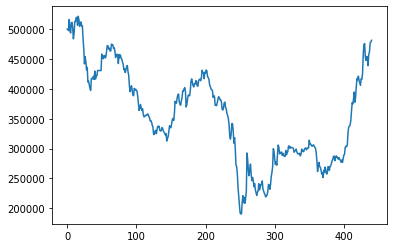

In [ ]:
%matplotlib inline
df_account_value.account_value.plot()

### 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [ ]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = BackTestStats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)

==============Get Backtest Results===========
Annual return         -0.021889
Cumulative returns    -0.037990
Annual volatility      0.459591
Sharpe ratio           0.173775
Calmar ratio          -0.034518
Stability              0.327646
Max drawdown          -0.634133
Omega ratio            1.033623
Sortino ratio          0.276953
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.986957
Daily value at risk   -0.057586
Alpha                  0.000000
Beta                   1.000000
dtype: float64


### 7.2 BackTestPlot

==============Compare to IHSG===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (430, 8)


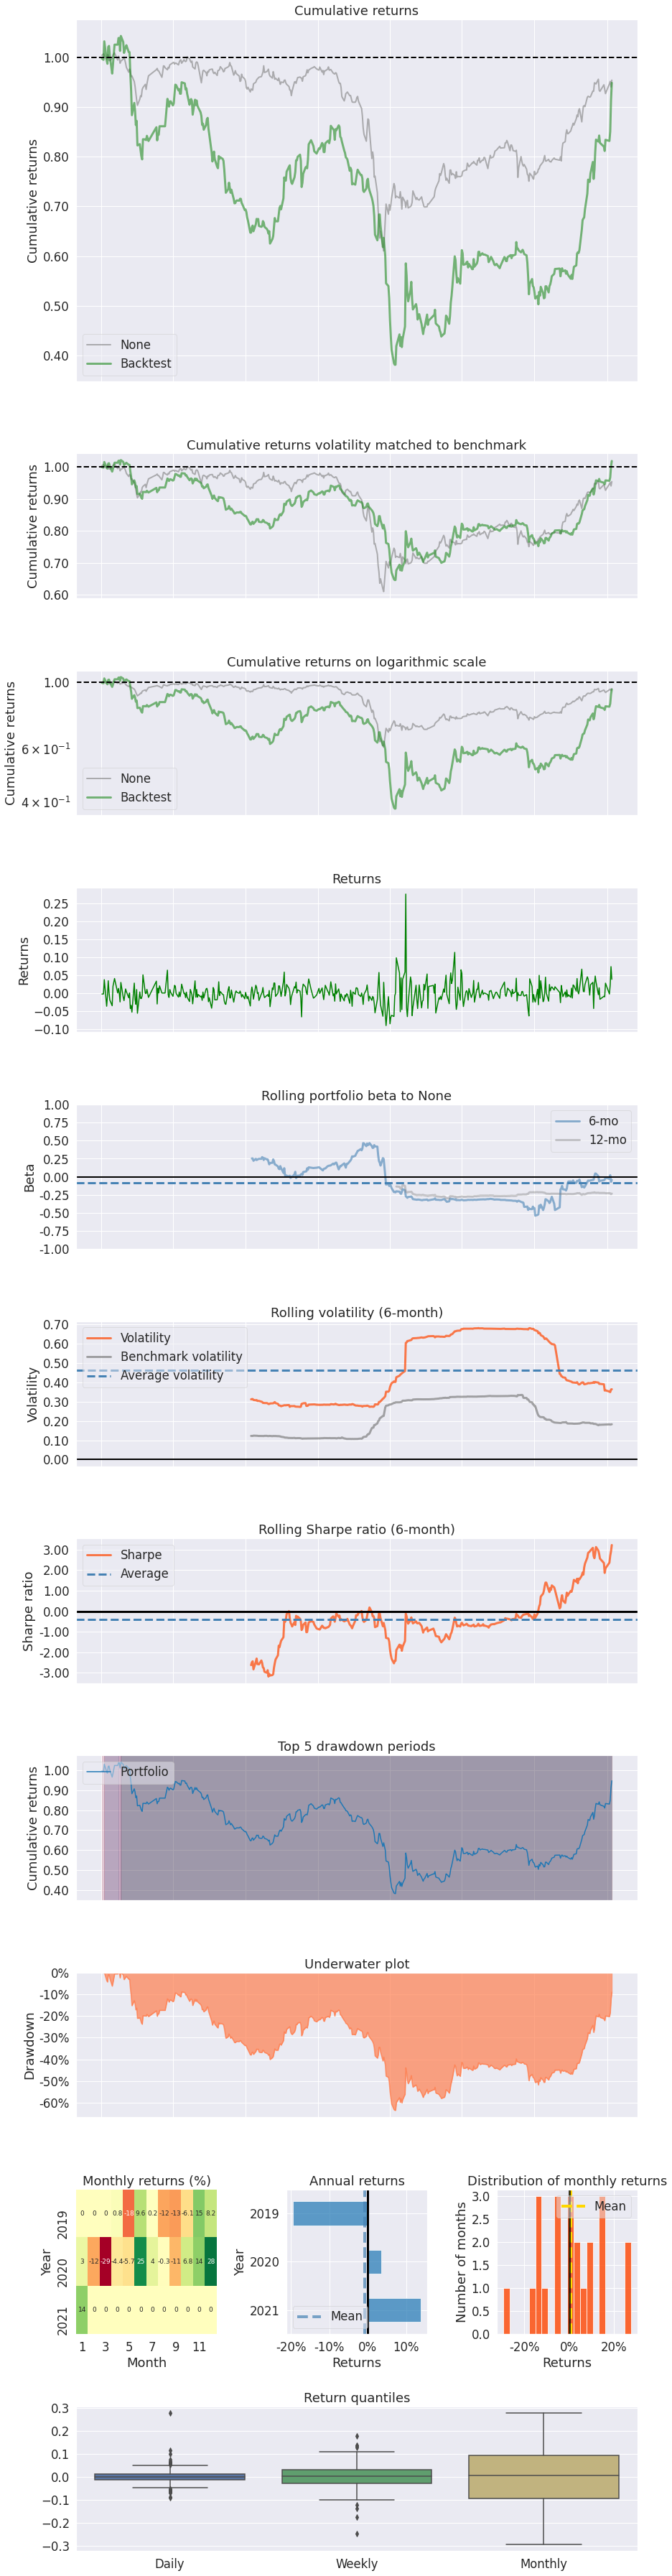

In [ ]:
print("==============Compare to IHSG===========")
%matplotlib inline
BackTestPlot(df_account_value, 
             baseline_ticker = '^JKSE', 
             baseline_start = df_account_value.loc[0,'date'],
             baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])

### 7.3 Baseline Stats

In [ ]:
print("==============Get Baseline Stats===========")
baseline_perf_stats=BaselineStats('^JKSE',
                                  baseline_start = df_account_value.loc[0,'date'],
                                  baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (430, 8)
Annual return         -0.027420
Cumulative returns    -0.046334
Annual volatility      0.216841
Sharpe ratio          -0.020512
Calmar ratio          -0.069439
Stability              0.398216
Max drawdown          -0.394883
Omega ratio            0.996064
Sortino ratio         -0.028793
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.041591
Daily value at risk   -0.027337
Alpha                  0.000000
Beta                   1.000000
dtype: float64


# Advanced Reinforcement Learning Material

This section contains links to advanced RL material. We will add working code examples as and when they are ready.

## Inverse Reinforcement Learning

[LEARNING "WHAT-IF" EXPLANATIONS
FOR SEQUENTIAL DECISION-MAKING](https://arxiv.org/pdf/2007.13531.pdf)

## Reinforcement Learning for Text

[Microsoft TextWorld](https://github.com/microsoft/TextWorld)

## Distributional Reinforcement Learning

[A Distributional Perspective on Reinforcement Learning](http://proceedings.mlr.press/v70/bellemare17a/bellemare17a.pdf)

[A distributional code for value in dopamine-based reinforcement learning
](https://www.nature.com/articles/s41586-019-1924-6)

## Reinforcement Learning for Neuroscience and Social Robots

[Deep Reinforcement Learning and
its Neuroscientific Implications](https://arxiv.org/pdf/2007.03750.pdf)

[Social robot learning with deep
reinforcement learning and realistic
reward shaping](https://uu.diva-portal.org/smash/get/diva2:1365641/FULLTEXT01.pdf)

# Homework

In the last homework, we brainstormed about how we would include RL in a social scientific context. In this homework, you can either:

**a)** Use a Deep RL based method on any social scientific context or dataset.

**b)** Use a Deep RL method on one of the environments from the OpenAI gym.